# NASLib tutorial and intro to exercise

[NASLib](https://github.com/automl/NASLib) is framework that was built in order to facilitate neural architecture search (NAS) research and development. Please refer to the slides and to the [NAS survey paper](https://arxiv.org/abs/1808.05377) for more details. At the high-level NASLib consists of 4 main building blocks which (can) interact with each other:
- search spaces (cell search space, hierarchical, ...)
- optimizers (one-shot/weight-sharing optimizers, black-box optimizers)
- predictors (performance estimators that given an architecture as input, output its performance)
- evaluators (run the architecture search loop and the final network training pipeline)

**NOTE: NASLib is currently under development. This exercise is meant to be beneficial for both students and the NASLib developers. In case of any issues or bugs please contact us and we will try to fix those. If you are interested in working to extend the library please contact Arber.**

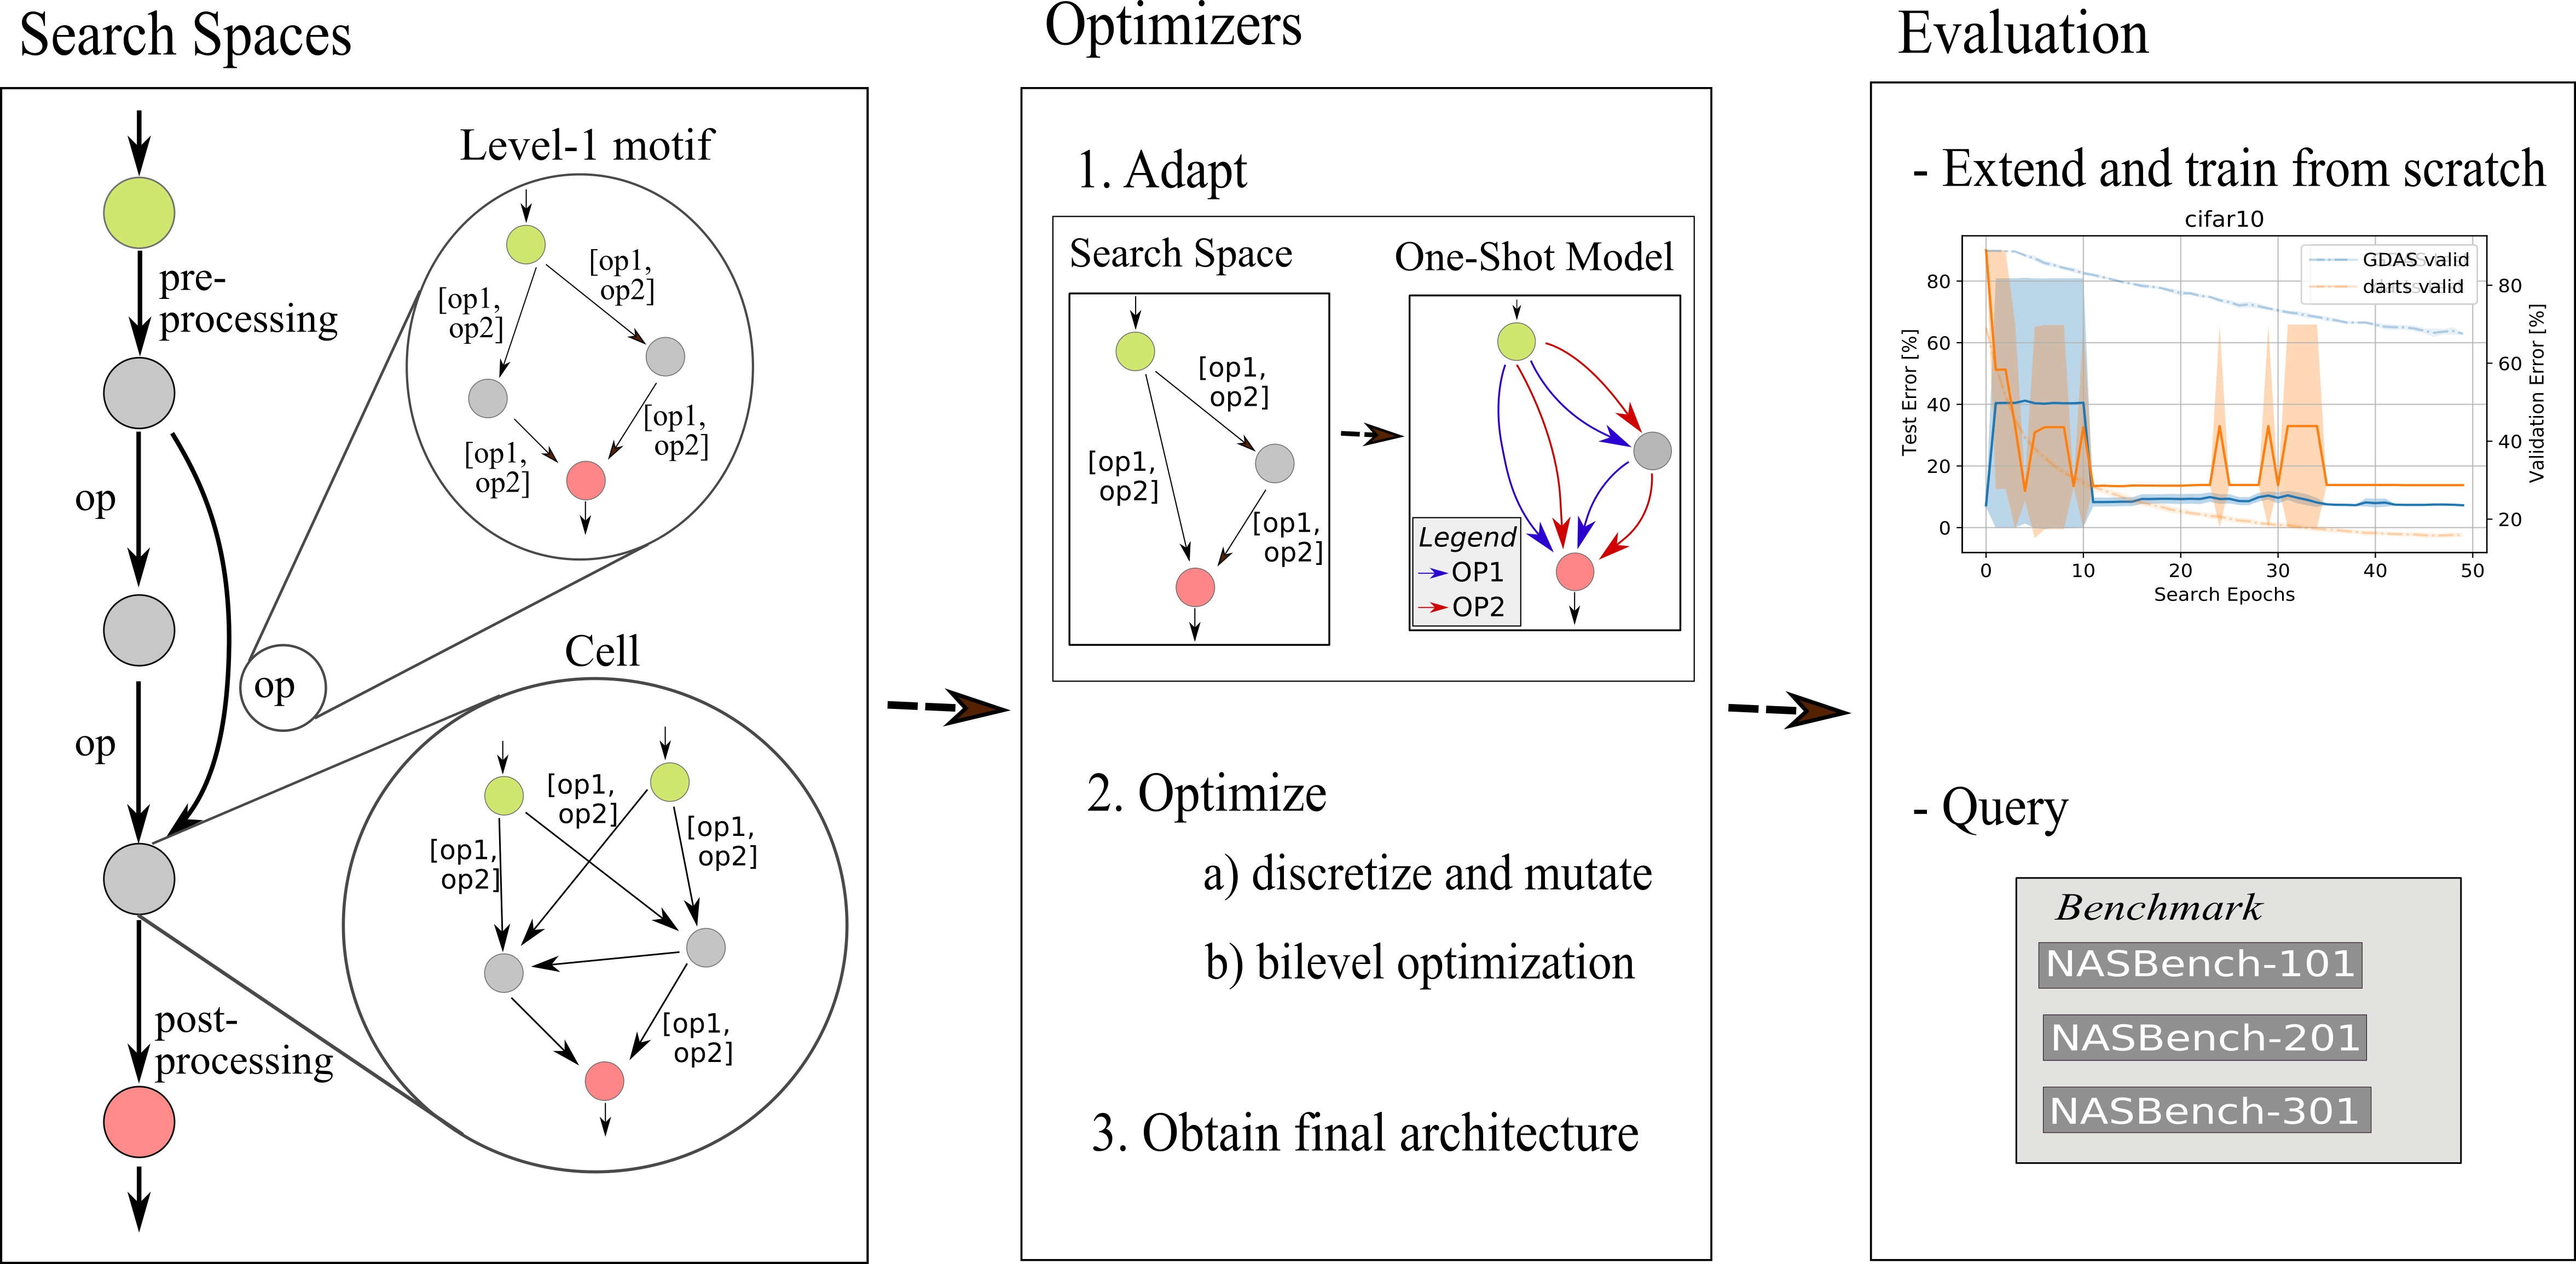

## Installation and setup 

To setup your environment and install NASLib follow these steps:
```
git clone -b dllab22 https://github.com/automl/NASLib/
cd NASLib
conda create -n naslib_exercises python=3.7
conda activate naslib_exercises
pip install --upgrade pip setuptools wheel
pip install -e .
pip install jupyter gdown
source scripts/download_data.sh nb201 cifar10
```


## Cell search spaces in NASLib 

The search space representation is of primary importance for NASLib in ensuring that optimizers and search spaces can be combined in a variety of ways. The predominant way of representing NAS search spaces is the directed acyclic graph (DAG). 
In order to accomplish the aforementioned functionality of search spaces and computational graphs, we inherit in our basic graph classes from both [PyTorch](https://pytorch.org/) and [NetworkX](https://github.com/networkx/networkx). The latter is a well-maintained and tested Python package for graph creation and manipulation, where node and edge attributes can be arbitrary Python objects. This framework allows us to represent multiple layers of graphs on top of the computational graph, allowing us to treat nodes and edges both as primitive operations (e.g. convolution), but also nested graph-structures such as a DARTS cell, to create e.g. macro architectures of stacked cells. NetworkX allows to easily construct the search space via `add_node`, `remove_node`, `add_edge`, `remove_edge`, or traverse the topologically sorted graph in the forward pass of the PyTorch module using `networkx.algorithms.dag.topological_sort`.

### Case study: NAS-Bench-201

[The NAS-Bench-201](https://openreview.net/forum?id=HJxyZkBKDr) is a tabular benchmark, i.e. a benchmark where you can simply query (already has been trained) the performance and other metrics of a specific architecture in the search space given that as an input. Its search space consists of a single normal cell which is replicated multiple times in a macro architecture interleaved by manually defined resnet-like reduction cells. The cell topology is fixed in the cell and consists of:
- 1 input, 2 intermediate and 1 output node;
- a summation operation on each of the intermediate and output nodes;
- 5 operation choices in each of the edges connecting 2 nodes
    - 'none'
    - 'skip_connect'
    - 'nor_conv_1x1'
    - 'nor_conv_3x3'
    - 'avg_pool_3x3'
    
For an example on how this search space is defined using the NASLib terminology, refer  [here](https://github.com/automl/NASLib/blob/predictors/naslib/search_spaces/nasbench201/graph.py).

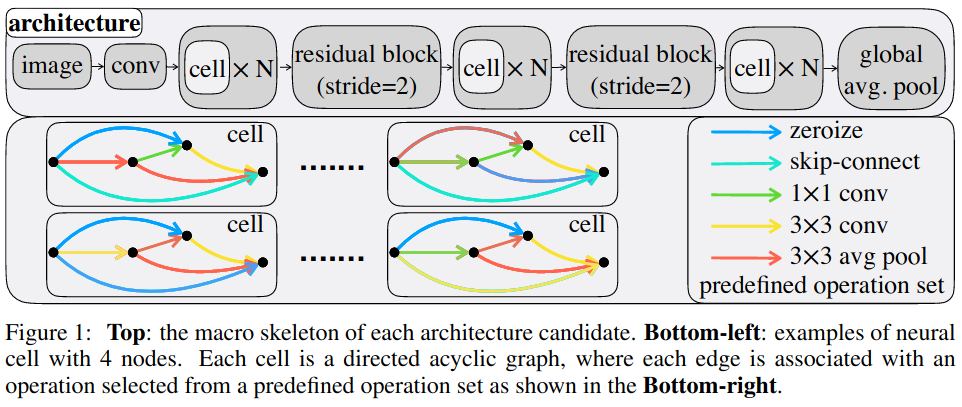

In [4]:
from naslib.search_spaces import NasBench201SearchSpace as NB201

# instantiate the search space object
search_space = NB201()

WARNING [05/23 18:55:43 nl.search_spaces.core.graph]: Update function could not be veryfied. Be cautious with the setting of `private_edge_data` in `update_edges()`
WARNING [05/23 18:55:43 nl.search_spaces.core.graph]: Update function could not be veryfied. Be cautious with the setting of `private_edge_data` in `update_edges()`
WARNING [05/23 18:55:43 nl.search_spaces.core.graph]: Update function could not be veryfied. Be cautious with the setting of `private_edge_data` in `update_edges()`


## Black-box optimizers in NASLib

After learning about the search space object, now we can add the other component of NAS: the NAS optimizer which you will use to search for an optimal architecture in that search space. A search space graph object can be interpreted in different ways depending on the type of optimizer being used. Here is the point where the search space and optimizer objects interact by parsing information from each other. 

In [5]:
# import some utilities and parse the configuration file
import logging

from naslib.utils import utils, setup_logger, get_dataset_api

# This will read the parameters from the default yaml configuration file, which in this 
# case is located in NASLib/naslib/benchmarks/nas_predictors/discrete_config.yaml.
# You do not have to change this but you can play around with its parameters.
config = utils.get_config_from_args(config_type="nas_predictor")
utils.set_seed(config.seed)
utils.log_args(config)

logger = setup_logger(config.save + "/log.log")
logger.setLevel(logging.INFO)

Namespace(config_file='/home/khaled/Uni/Deep Learning Lab/NASLib/naslib/benchmarks/nas_predictors/discrete_config.yaml', dist_backend='nccl', dist_url='tcp://127.0.0.1:8888', eval_only=False, gpu=None, model_path=None, multiprocessing_distributed=False, opts=[], rank=0, resume=False, seed=0, world_size=1)
[05/23 18:55:51 nl.utils.utils]: Command line args: Namespace(config_file='/home/khaled/Uni/Deep Learning Lab/NASLib/naslib/benchmarks/nas_predictors/discrete_config.yaml', dist_backend='nccl', dist_url='tcp://127.0.0.1:8888', eval_only=False, gpu=None, model_path=None, multiprocessing_distributed=False, opts=[], rank=0, resume=False, seed=0, world_size=1)
[05/23 18:55:51 nl.utils.utils]: Experiment dir : run/cifar10/nas_predictors/nasbench201/var_sparse_gp/0
[05/23 18:55:51 nl.utils.utils]: Experiment dir : run/cifar10/nas_predictors/nasbench201/var_sparse_gp/0/search
[05/23 18:55:51 nl.utils.utils]: Experiment dir : run/cifar10/nas_predictors/nasbench201/var_sparse_gp/0/eval
[05/23 

In [6]:
from naslib.optimizers import RegularizedEvolution as RE

# instantiate the optimizer object using the configuration file parameters
optimizer = RE(config)

After parsing the configuration file and instantiating the NAS optimizer and search space objects, we have to adapt the search space based on the optimizer type. 
A black-box optimizer such as Random Search will sample single architectures using the `sample_random_architecture` method of the search space object (e.g. by sampling one operation at each graph edge from the operation choices in NAS-Bench-201) throughout the optimization process.
On the other hand most one-shot optimizers, such as [DARTS](https://arxiv.org/abs/1806.09055), will interpret a set of operation choices on an edge as a `MixedOp` and assign an appropriate number of architectural weights (between 0 and 1, such that the sum is 1) to the outputs of each operation in order to obtain the continuous relaxation. 

Download the NAS-Bench-201 data from https://drive.google.com/file/d/17EBlTidimMaGrb3fE0APbljJl-ocgfs4/view?usp=sharing and place it in `NASLib/naslib/data/`. Alternatively run ```source scripts/download_data.sh nb201 cifar10```


In [8]:
# this will load the NAS-Bench-201 data (architectures and their accuracy, runtime, etc).
dataset_api = get_dataset_api(config.search_space, config.dataset)

# adapt the search space to the optimizer type
optimizer.adapt_search_space(search_space, dataset_api=dataset_api)

## Running the search

Now the only step left is to run the search. Fro this we will use the `Trainer` object in NASLib:

In [9]:
from naslib.defaults.trainer import Trainer

# since the optimizer has parsed the information of the search space, we do not need to pass the search
# space object to the trainer when instantiating it.
trainer = Trainer(optimizer, config, lightweight_output=True)

[05/23 18:56:36 nl.defaults.trainer]: param size = 0.000000MB


In [10]:
# call only a method to run the search for the number of iterations specified in the yaml configuration file.
trainer.search()

[05/23 18:56:40 nl.defaults.trainer]: Start training
[05/23 18:56:40 nl.optimizers.discrete.re.optimizer]: Start sampling architectures to fill the population
WARNING [05/23 18:56:40 nl.search_spaces.core.graph]: Update function could not be veryfied. Be cautious with the setting of `private_edge_data` in `update_edges()`
WARNING [05/23 18:56:40 nl.search_spaces.core.graph]: Update function could not be veryfied. Be cautious with the setting of `private_edge_data` in `update_edges()`
[05/23 18:56:40 nl.optimizers.discrete.re.optimizer]: Population size 1
[05/23 18:56:40 nl.defaults.trainer]: Epoch 0, Anytime results: {'cifar10-valid': {'train_losses': [1.933049173965454, 1.6435673345184325, 1.5047246058654786, 1.3834531283569336, 1.286956615371704, 1.1839038812637328, 1.1257015887069701, 1.0640545072746277, 1.008200834274292, 0.9675810929870605, 0.9294775085449218, 0.8978886487960815, 0.8689233894729614, 0.835043701877594, 0.8149485078430175, 0.7993172987365723, 0.7647924902915955, 0.7

[05/23 18:56:40 nl.defaults.trainer]: Epoch 0 done. Train accuracy (top1, top5): 99.11600, 0.00000, Validation accuracy: 86.81000, 0.00000
[05/23 18:56:40 nl.optimizers.discrete.re.optimizer]: Start sampling architectures to fill the population
[05/23 18:56:41 nl.defaults.trainer]: Epoch 1 done. Train accuracy (top1, top5): 99.11600, 0.00000, Validation accuracy: 86.81000, 0.00000
[05/23 18:56:41 nl.optimizers.discrete.re.optimizer]: Start sampling architectures to fill the population
[05/23 18:56:41 nl.defaults.trainer]: Epoch 2 done. Train accuracy (top1, top5): 99.11600, 0.00000, Validation accuracy: 86.81000, 0.00000
[05/23 18:56:41 nl.optimizers.discrete.re.optimizer]: Start sampling architectures to fill the population
[05/23 18:56:41 nl.defaults.trainer]: Epoch 3 done. Train accuracy (top1, top5): 99.11600, 0.00000, Validation accuracy: 86.81000, 0.00000
[05/23 18:56:41 nl.optimizers.discrete.re.optimizer]: Start sampling architectures to fill the population
[05/23 18:56:41 nl.d

[05/23 18:56:45 nl.defaults.trainer]: Epoch 21 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 18:56:45 nl.optimizers.discrete.re.optimizer]: Start sampling architectures to fill the population
[05/23 18:56:46 nl.defaults.trainer]: Epoch 22 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 18:56:46 nl.optimizers.discrete.re.optimizer]: Start sampling architectures to fill the population
[05/23 18:56:46 nl.optimizers.discrete.re.optimizer]: Population size 24
[05/23 18:56:46 nl.defaults.trainer]: Epoch 23 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 18:56:46 nl.optimizers.discrete.re.optimizer]: Start sampling architectures to fill the population
[05/23 18:56:46 nl.defaults.trainer]: Epoch 24 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 18:56:46 nl.optimizers.discrete.re.optimiz

[05/23 18:56:51 nl.defaults.trainer]: Epoch 43 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 18:56:51 nl.defaults.trainer]: Epoch 44 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 18:56:51 nl.defaults.trainer]: Epoch 45 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 18:56:51 nl.defaults.trainer]: Epoch 46 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 18:56:51 nl.defaults.trainer]: Epoch 47 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 18:56:52 nl.defaults.trainer]: Epoch 48 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 18:56:52 nl.defaults.trainer]: Epoch 49 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 18:56:52 nl.d

[05/23 18:56:56 nl.defaults.trainer]: Epoch 66 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 18:56:56 nl.defaults.trainer]: Epoch 67 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 18:56:57 nl.defaults.trainer]: Epoch 68 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 18:56:57 nl.defaults.trainer]: Epoch 69 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 18:56:57 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000


KeyboardInterrupt: 

In [ ]:
# After the search is done, we want to evaluate the test performance of
# the best architecture found using the validation set.
trainer.evaluate(dataset_api=dataset_api)

## NAS predictors

The performance predictors in NASLib are categorized in 4 classes:
- *Model-based predictors*
    - These are usually regression models (e.g. Gaussian Processes or XGBoost) that are trained with a data (x, y), where x is the architecture encoding and y is the validation performance of the trained architectures. At test time, they predict the performance of new architectures from the space.
- *Learning curve predictors*
    - These predictors estimate the architecture ranking (e.g. at epoch 100) by using the performance at a lower epoch or some other statistics. An example is early stopping. By early stopping the training at epoch 30, we hope that the ranking of the architectures will be the same as the ranking at epoch 100.
- *Zero-cost predictors*
    - These predictors usually run only a single mini-batch iteration through a sampled architecture and use some statistics (e.g. norm of gradients) in order to determine how good that architecture is.
- *One-shot predictors*
    - This class of predictors utilizes the shared weights of the one-shot model in order to rank the architectures based on the validation performance using these shared weights.
    
In NASLib we have implemented **31 predictors** that can be easily imported and evaluated on the tabular benchmarks. Check also this file for some more details: https://github.com/automl/NASLib/blob/master/docs/predictors.md and our paper: https://arxiv.org/abs/2104.01177

In [11]:
# Load the predictor evaluator and the predictor (XGBoost in this case)
from naslib.defaults.predictor_evaluator import PredictorEvaluator
from naslib.predictors import XGBoost

# read the new configuration file that has the parameters of the predictor model
# NOTE: it is important to set config_type="predictor" here
config = utils.get_config_from_args(args=["--config-file", "../naslib/benchmarks/predictors/predictor_config.yaml"], 
                                    config_type="predictor")
utils.set_seed(config.seed)
utils.log_args(config)

logger = setup_logger(config.save + "/log.log")
logger.setLevel(logging.INFO)

# Now instantiate the predictor (every predictor works with certain encoding types for the architecture)
predictor = XGBoost(encoding_type='adjacency_one_hot', hpo_wrapper=False)
# Instantiate the evaluator
predictor_evaluator = PredictorEvaluator(predictor, config=config)
# similarly to the conventional NAS search that we saw before, the predictor evaluator also adapts to 
# the search space at hand
predictor_evaluator.adapt_search_space(search_space, load_labeled=False, 
                                       dataset_api=dataset_api)
# No search in this case. We only train the predictor on the training data and evaluate it on the test data.
# Note that the training data here is the pair (arch, performance) and not (image, label).
predictor_evaluator.evaluate()

['--config-file', '../naslib/benchmarks/predictors/predictor_config.yaml']
[05/23 18:57:12 nl.utils.utils]: Command line args: ['--config-file', '../naslib/benchmarks/predictors/predictor_config.yaml']
[05/23 18:57:12 nl.utils.utils]: Experiment dir : run/cifar10/predictors/xgb/1000
[05/23 18:57:12 nl.utils.utils]: Experiment dir : run/cifar10/predictors/xgb/1000/search
[05/23 18:57:12 nl.utils.utils]: Experiment dir : run/cifar10/predictors/xgb/1000/eval
[05/23 18:57:12 nl.utils.utils]: experiment_type.............................single
[05/23 18:57:12 nl.utils.utils]: search_space...........................nasbench201
[05/23 18:57:12 nl.utils.utils]: dataset....................................cifar10
[05/23 18:57:12 nl.utils.utils]: predictor......................................xgb
[05/23 18:57:12 nl.utils.utils]: uniform_random...................................1
[05/23 18:57:12 nl.utils.utils]: test_size......................................100
[05/23 18:57:12 nl.utils.utils]: tra

[CfgNode({'experiment_type': 'single', 'search_space': 'nasbench201', 'dataset': 'cifar10', 'predictor': 'xgb', 'uniform_random': 1, 'test_size': 100, 'train_size_single': 50, 'train_size_list': [5, 8, 14, 24, 42, 71, 121, 205], 'fidelity_single': 5, 'fidelity_list': [1, 2, 3, 5, 7, 9, 13, 19, 26, 37, 52, 73], 'out_dir': 'run', 'max_hpo_time': 0, 'seed': 1000, 'search': CfgNode({'seed': 1000, 'batch_size': 256, 'data_size': 25000, 'cutout': False, 'cutout_length': 16, 'cutout_prob': 1.0, 'train_portion': 0.7}), 'save': 'run/cifar10/predictors/xgb/1000', 'data': '/home/khaled/Uni/Deep Learning Lab/NASLib/naslib/data'}),
 {'mae': 4.320324826049804,
  'rmse': 8.385226457743993,
  'pearson': 0.35911963551925935,
  'spearman': 0.48864365998706494,
  'kendalltau': 0.35577120352397784,
  'kt_2dec': 0.35567687978766804,
  'kt_1dec': 0.3563206034824803,
  'precision_10': 0.5,
  'precision_20': 0.45,
  'train_size': 50,
  'fidelity': 5,
  'train_time': 462.41313511133194,
  'fit_time': 1.8492705

The stdout shows some metrics such as the rank correlation (Spearman or Kendall Tau) of 100 sampled architectures from the test set. This shows how good the ranking of the architectures based on the performance predictor is compared to the true ranking from NAS-Bench-201.

## Using the predictors as surrogate models in Bayesian Optimization

In order to use the aforementioned predictors as surrogate models inside Bayesian Optimization, we need to have a mean prediction and uncertainty estimates for every architecture. Some of the models (e.g. GPs) already provide this, but for some others such as MLPs we construct an ensemble of MLPs in order to obtain the uncertainty estimates.

This code snippet shows how to run [BANANAS](https://arxiv.org/abs/1910.11858) with some of the performance predictors as surrogate models. We will do 3 trials with 3 different seeds of BANANAS for 300 iterations. For this we need to firstly generate the configuration files. The bash commands below do this. 

In [13]:
%%bash
optimizer=re
predictors=(mlp lgb xgb rf gp none) #removed bayes_lin_reg, because it was causing an error for some reason

start_seed=0

# folders:
# this supposes your location is at NASLib/docs. Change the base_file location based on where you
# opened the notebook
base_file=../naslib
save_dir=re_run
out_dir=$save_dir\_$start_seed

# search space / data:
search_space=nasbench201
dataset=cifar10
search_epochs=300

# trials / seeds:
trials=3
end_seed=$(($start_seed + $trials - 1))

# create config files
for i in $(seq 0 $((${#predictors[@]}-1)) )
do
    predictor=${predictors[$i]}
    python $base_file/benchmarks/create_configs.py --predictor $predictor \
    --epochs $search_epochs --start_seed $start_seed --trials $trials \
    --out_dir $out_dir --dataset=$dataset --config_type nas_predictor \
    --search_space $search_space --optimizer $optimizer
done

Similarly to how we ran RE before, write a function that gets a configuration file and optimizer as input and runs them.

In [14]:
from naslib.optimizers import Bananas

def run_optimizer(config_file="../docs/bananas_run_0/cifar10/configs/nas_predictors/config_bananas_gp_0.yaml",
                  nas_optimizer=Bananas) -> None:
    # TODO: add all the utilities, such as config file reading, logging as before.
    # afterwards instantiate the search space, optimizer, trainer and run the search + evaluation
    
    #config file reading
    config = utils.get_config_from_args(args=["--config-file", config_file], config_type="nas_predictor")
    utils.set_seed(config.seed)
    utils.log_args(config)
    
    #logging
    logger = setup_logger(config.save + "/log.log")
    logger.setLevel(logging.INFO)
    
    #instantiate the search space
    dataset_api = get_dataset_api(config.search_space, config.dataset)
    
    #instantiate the optimizer
    optimizer = nas_optimizer(config)
    optimizer.adapt_search_space(search_space, dataset_api=dataset_api)
    
    #instantiate trainer and run the search + evaluation
    trainer = Trainer(optimizer, config, lightweight_output=True)
    trainer.search()
    trainer.evaluate(dataset_api=dataset_api)
    pass

In [15]:
run_optimizer()

['--config-file', '../docs/bananas_run_0/cifar10/configs/nas_predictors/config_bananas_gp_0.yaml']
[05/23 17:39:50 nl.utils.utils]: Command line args: ['--config-file', '../docs/bananas_run_0/cifar10/configs/nas_predictors/config_bananas_gp_0.yaml']
[05/23 17:39:50 nl.utils.utils]: Experiment dir : bananas_run_0/cifar10/nas_predictors/nasbench201/gp/0
[05/23 17:39:50 nl.utils.utils]: Experiment dir : bananas_run_0/cifar10/nas_predictors/nasbench201/gp/0/search
[05/23 17:39:50 nl.utils.utils]: Experiment dir : bananas_run_0/cifar10/nas_predictors/nasbench201/gp/0/eval
[05/23 17:39:50 nl.utils.utils]: dataset....................................cifar10
[05/23 17:39:50 nl.utils.utils]: optimizer..................................bananas
[05/23 17:39:50 nl.utils.utils]: out_dir..............................bananas_run_0
[05/23 17:39:50 nl.utils.utils]: searchacq_fn_optimization: random_sampling
acq_fn_type: its
batch_size: 256
checkpoint_freq: 5000
cutout: False
cutout_length: 16
cutout_prob

[05/23 17:39:58 nl.defaults.trainer]: Epoch 0 done. Train accuracy (top1, top5): 99.11600, 0.00000, Validation accuracy: 86.81000, 0.00000
[05/23 17:39:58 nl.defaults.trainer]: Epoch 1 done. Train accuracy (top1, top5): 99.11600, 0.00000, Validation accuracy: 86.81000, 0.00000
[05/23 17:39:58 nl.defaults.trainer]: Epoch 2 done. Train accuracy (top1, top5): 99.11600, 0.00000, Validation accuracy: 86.81000, 0.00000
[05/23 17:39:58 nl.defaults.trainer]: Epoch 3 done. Train accuracy (top1, top5): 99.11600, 0.00000, Validation accuracy: 86.81000, 0.00000
[05/23 17:39:59 nl.defaults.trainer]: Epoch 4 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 17:39:59 nl.defaults.trainer]: Epoch 5 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 17:39:59 nl.defaults.trainer]: Epoch 6 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 17:39:59 nl.defaults

/home/khaled/miniconda3/envs/naslib/lib/python3.7/site-packages/pyro/contrib/gp/models/gpr.py:126: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1337.)
  Lff = Kff.cholesky()
/home/khaled/miniconda3/envs/naslib/lib/python3.7/site-packages/pyro/contrib/gp/util.py:109: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced wi

Finished fitting GP
Finished fitting GP
[05/23 17:40:56 nl.defaults.trainer]: Epoch 20, Anytime results: {'cifar10-valid': {'train_losses': [1.7726301501464843, 1.2632741512680055, 1.0350315731430053, 0.9116640870666504, 0.8138554672622681, 0.7384605021095276, 0.6771002819061279, 0.6386288579177857, 0.5977942006492615, 0.566234061164856, 0.5407228638648987, 0.5169966495037079, 0.5059799674415588, 0.49211094816207884, 0.47442392370224, 0.4547991913414001, 0.45366372842788694, 0.44375011929512026, 0.4291874082946777, 0.4207805109882355, 0.4070393644332886, 0.4128223983192444, 0.3933644982147217, 0.3912780677032471, 0.39287704973220827, 0.37701327048301697, 0.3703632626247406, 0.36252842462539675, 0.3545865700340271, 0.36439799418449403, 0.35175954774856566, 0.352374792804718, 0.3494409676837921, 0.34050146408081056, 0.33357596693992614, 0.3253499046516418, 0.3226811494445801, 0.32070203971862793, 0.32613728584289553, 0.3122583133125305, 0.31861459453582763, 0.29858239007949827, 0.3031420

[05/23 17:40:56 nl.defaults.trainer]: Epoch 20 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 17:40:56 nl.defaults.trainer]: Epoch 21 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 17:40:57 nl.defaults.trainer]: Epoch 22 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 17:40:57 nl.defaults.trainer]: Epoch 23 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 17:40:57 nl.defaults.trainer]: Epoch 24 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 17:40:57 nl.defaults.trainer]: Epoch 25 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 17:40:57 nl.defaults.trainer]: Epoch 26 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 17:40:57 nl.d

[05/23 17:41:40 nl.defaults.trainer]: Epoch 40 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 17:41:40 nl.defaults.trainer]: Epoch 41 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 17:41:40 nl.defaults.trainer]: Epoch 42 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 17:41:40 nl.defaults.trainer]: Epoch 43 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 17:41:40 nl.defaults.trainer]: Epoch 44 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 17:41:40 nl.defaults.trainer]: Epoch 45 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 17:41:40 nl.defaults.trainer]: Epoch 46 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 17:41:40 nl.d

[05/23 17:42:22 nl.defaults.trainer]: Epoch 60 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 90.51000, 0.00000
[05/23 17:42:22 nl.defaults.trainer]: Epoch 61 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 90.51000, 0.00000
[05/23 17:42:22 nl.defaults.trainer]: Epoch 62 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 90.51000, 0.00000
[05/23 17:42:22 nl.defaults.trainer]: Epoch 63 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 90.51000, 0.00000
[05/23 17:42:22 nl.defaults.trainer]: Epoch 64 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 90.51000, 0.00000
[05/23 17:42:22 nl.defaults.trainer]: Epoch 65 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 90.51000, 0.00000
[05/23 17:42:22 nl.defaults.trainer]: Epoch 66 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 90.51000, 0.00000
[05/23 17:42:22 nl.d

[05/23 17:43:06 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.78000, 0.00000
[05/23 17:43:06 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.78000, 0.00000
[05/23 17:43:07 nl.defaults.trainer]: Epoch 82 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.78000, 0.00000
[05/23 17:43:07 nl.defaults.trainer]: Epoch 83 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.78000, 0.00000
[05/23 17:43:07 nl.defaults.trainer]: Epoch 84 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.78000, 0.00000
[05/23 17:43:07 nl.defaults.trainer]: Epoch 85 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.78000, 0.00000
[05/23 17:43:07 nl.defaults.trainer]: Epoch 86 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.78000, 0.00000
[05/23 17:43:07 nl.d

[05/23 17:43:50 nl.defaults.trainer]: Epoch 100 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.78000, 0.00000
[05/23 17:43:50 nl.defaults.trainer]: Epoch 101 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.78000, 0.00000
[05/23 17:43:50 nl.defaults.trainer]: Epoch 102 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.78000, 0.00000
[05/23 17:43:50 nl.defaults.trainer]: Epoch 103 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.87000, 0.00000
[05/23 17:43:50 nl.defaults.trainer]: Epoch 104 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.87000, 0.00000
[05/23 17:43:50 nl.defaults.trainer]: Epoch 105 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.87000, 0.00000
[05/23 17:43:50 nl.defaults.trainer]: Epoch 106 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.87000, 0.00000
[05/23 17:43:

[05/23 17:44:30 nl.defaults.trainer]: Epoch 120 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.87000, 0.00000
[05/23 17:44:30 nl.defaults.trainer]: Epoch 121 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.87000, 0.00000
[05/23 17:44:30 nl.defaults.trainer]: Epoch 122 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.87000, 0.00000
[05/23 17:44:31 nl.defaults.trainer]: Epoch 123 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.87000, 0.00000
[05/23 17:44:31 nl.defaults.trainer]: Epoch 124 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.87000, 0.00000
[05/23 17:44:31 nl.defaults.trainer]: Epoch 125 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.87000, 0.00000
[05/23 17:44:31 nl.defaults.trainer]: Epoch 126 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.87000, 0.00000
[05/23 17:44:

[05/23 17:45:15 nl.defaults.trainer]: Epoch 140 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.87000, 0.00000
[05/23 17:45:15 nl.defaults.trainer]: Epoch 141 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.87000, 0.00000
[05/23 17:45:15 nl.defaults.trainer]: Epoch 142 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.87000, 0.00000
[05/23 17:45:15 nl.defaults.trainer]: Epoch 143 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.87000, 0.00000
[05/23 17:45:15 nl.defaults.trainer]: Epoch 144 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.87000, 0.00000
[05/23 17:45:15 nl.defaults.trainer]: Epoch 145 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.87000, 0.00000
[05/23 17:45:15 nl.defaults.trainer]: Epoch 146 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.87000, 0.00000
[05/23 17:45:

[05/23 17:45:57 nl.defaults.trainer]: Epoch 160 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 17:45:57 nl.defaults.trainer]: Epoch 161 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 17:45:57 nl.defaults.trainer]: Epoch 162 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 17:45:57 nl.defaults.trainer]: Epoch 163 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 17:45:57 nl.defaults.trainer]: Epoch 164 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 17:45:57 nl.defaults.trainer]: Epoch 165 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 17:45:57 nl.defaults.trainer]: Epoch 166 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 17:45:

[05/23 17:46:41 nl.defaults.trainer]: Epoch 180 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 17:46:41 nl.defaults.trainer]: Epoch 181 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 17:46:41 nl.defaults.trainer]: Epoch 182 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:46:41 nl.defaults.trainer]: Epoch 183 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:46:41 nl.defaults.trainer]: Epoch 184 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:46:41 nl.defaults.trainer]: Epoch 185 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:46:41 nl.defaults.trainer]: Epoch 186 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 1

[05/23 17:47:25 nl.defaults.trainer]: Epoch 200 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:47:25 nl.defaults.trainer]: Epoch 201 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:47:25 nl.defaults.trainer]: Epoch 202 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:47:25 nl.defaults.trainer]: Epoch 203 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:47:25 nl.defaults.trainer]: Epoch 204 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:47:25 nl.defaults.trainer]: Epoch 205 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:47:25 nl.defaults.trainer]: Epoch 206 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23

[05/23 17:48:09 nl.defaults.trainer]: Epoch 220 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:48:09 nl.defaults.trainer]: Epoch 221 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:48:09 nl.defaults.trainer]: Epoch 222 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:48:09 nl.defaults.trainer]: Epoch 223 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:48:09 nl.defaults.trainer]: Epoch 224 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:48:09 nl.defaults.trainer]: Epoch 225 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:48:09 nl.defaults.trainer]: Epoch 226 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23

[05/23 17:48:55 nl.defaults.trainer]: Epoch 240 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:48:55 nl.defaults.trainer]: Epoch 241 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:48:55 nl.defaults.trainer]: Epoch 242 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:48:55 nl.defaults.trainer]: Epoch 243 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:48:55 nl.defaults.trainer]: Epoch 244 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:48:55 nl.defaults.trainer]: Epoch 245 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:48:55 nl.defaults.trainer]: Epoch 246 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23

[05/23 17:49:42 nl.defaults.trainer]: Epoch 260 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:49:42 nl.defaults.trainer]: Epoch 261 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:49:42 nl.defaults.trainer]: Epoch 262 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:49:42 nl.defaults.trainer]: Epoch 263 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:49:42 nl.defaults.trainer]: Epoch 264 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:49:42 nl.defaults.trainer]: Epoch 265 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:49:42 nl.defaults.trainer]: Epoch 266 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23

[05/23 17:50:35 nl.defaults.trainer]: Epoch 280 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:50:35 nl.defaults.trainer]: Epoch 281 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:50:35 nl.defaults.trainer]: Epoch 282 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:50:35 nl.defaults.trainer]: Epoch 283 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:50:35 nl.defaults.trainer]: Epoch 284 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:50:35 nl.defaults.trainer]: Epoch 285 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23 17:50:35 nl.defaults.trainer]: Epoch 286 done. Train accuracy (top1, top5): 100.00000, 0.00000, Validation accuracy: 91.33000, 0.00000
[05/23

# TASK: Implement a Regularized Evolution version that uses the performance predictors as surrogate models during the search

The Regularized Evolution (RE) code that we ran above uses the true validation performance as queried from NAS-Bench-201. Using the tabular benchmark this is certainly cheap since we are only simulating the true run. However, in real world scenarios these tabular entries are not available so we have to train every sampled/mutated architecture from scratch. This is the most expensive step in black-box optimization for NAS.

The NAS performance predictors can drastically accelerate the search by utilizing the performance as predicted by the surrogate model (performance predictor). In this exercise you will have to implement a RE version that utilizes the performance predictors to estimate the performance of the sampled architectures instead of querying that from the tabular benchmark. Sample the very first architectures in the population and query those from NB201. Then fit the performance predictor. Afterwards, every 10 iterations query again the performance from NB201 and refit the predictor. In between, however, use the performance returned by the predictor inside RE.

HINT: Check how the performance predictors are utilized inside the BANANAS implementation in NASLib.

In [32]:
import torch
import numpy as np

from naslib.optimizers.discrete.bananas.acquisition_functions import acquisition_function
from naslib.search_spaces.core.query_metrics import Metric
from naslib.utils.logging import log_every_n_seconds
from naslib.predictors.ensemble import Ensemble


class RE_predictor(RE):
    def __init__(self, config):
        # you probably would need to add some more attributes to the __init__ method
        super().__init__(config)
        self.xtrain = []
        self.ytrain = []
        self.train_error = 0.0
        self.ensemble=[]
        self.num_ensemble = config.search.num_ensemble
        self.predictor_type = config.search.predictor_type
        self.acq_fn_type = config.search.acq_fn_type

        
    
    def adapt_search_space(self, search_space, scope=None, dataset_api=None):
        assert search_space.QUERYABLE, "Regularized evolution is currently only implemented for benchmarks."
        self.search_space = search_space.clone()
        self.scope = scope if scope else search_space.OPTIMIZER_SCOPE
        self.dataset_api = dataset_api
        self.ss_type = self.search_space.get_type()
        
    
    def new_epoch(self, epoch):
        # This is the main method that you have to override in order to add the performance predictors
        if epoch < self.population_size:
            logger.info("Start sampling architectures to fill the population")
            # If there is no scope defined, let's use the search space default one
            
            model = torch.nn.Module()   # hacky way to get arch and accuracy checkpointable
            model.arch = self.search_space.clone()
            model.arch.sample_random_architecture(dataset_api=self.dataset_api)        
            model.accuracy = model.arch.query(self.performance_metric, 
                                              self.dataset, 
                                              dataset_api=self.dataset_api)
            
            self.population.append(model)
            self._update_history(model)
            log_every_n_seconds(logging.INFO, "Population size {}".format(len(self.population)))
            
        else:
            sample = []
            while len(sample) < self.sample_size:
                candidate = np.random.choice(list(self.population))
                sample.append(candidate)
            
            parent = max(sample, key=lambda x: x.accuracy)

            child = torch.nn.Module()   # hacky way to get arch and accuracy checkpointable
            child.arch = self.search_space.clone()
            child.arch.mutate(parent.arch, dataset_api=self.dataset_api)
            if epoch % 10 == 0 or self.predictor_type == 'none':
                child.accuracy = child.arch.query(self.performance_metric, 
                                              self.dataset, 
                                              dataset_api=self.dataset_api)
                self.xtrain = [m.arch for m in self.population]
                self.ytrain = [m.accuracy for m in self.population]
                if self.predictor_type != 'none':
                    self.ensemble = Ensemble(num_ensemble=self.num_ensemble,
                                        ss_type=self.ss_type,
                                        predictor_type=self.predictor_type, 
                                        config=self.config)
                    self.train_error = self.ensemble.fit(self.xtrain, self.ytrain)
                    
            else:
                acq_fn = acquisition_function(ensemble=self.ensemble, 
                                              ytrain=self.ytrain,
                                              acq_fn_type=self.acq_fn_type)
                child.accuracy = acq_fn(child.arch)

            self.population.append(child)
            self._update_history(child)        
    

Now generate the new yaml configuration files using the bash commands as shown above. Just change "bananas" to "re".

In [34]:
#TODO: Run the RE_predictor optimizer

# for config_file in list_of_config_files:
#    run_optimizer(config_file=config_file, nas_optimizer=RE_predictor)
import os
list_of_config_files = []
list_of_config_files = ["../docs/re_run_0/cifar10/configs/nas_predictors/" + f for f in os.listdir("../docs/re_run_0/cifar10/configs/nas_predictors/")]
for config_file in list_of_config_files:
   run_optimizer(config_file=config_file, nas_optimizer=RE_predictor)

['--config-file', '../docs/re_run_0/cifar10/configs/nas_predictors/config_re_none_1.yaml']
[05/23 19:47:30 nl.utils.utils]: Command line args: ['--config-file', '../docs/re_run_0/cifar10/configs/nas_predictors/config_re_none_1.yaml']
[05/23 19:47:30 nl.utils.utils]: Experiment dir : re_run_0/cifar10/nas_predictors/nasbench201/none/1
[05/23 19:47:30 nl.utils.utils]: Experiment dir : re_run_0/cifar10/nas_predictors/nasbench201/none/1/search
[05/23 19:47:30 nl.utils.utils]: Experiment dir : re_run_0/cifar10/nas_predictors/nasbench201/none/1/eval
[05/23 19:47:30 nl.utils.utils]: dataset....................................cifar10
[05/23 19:47:30 nl.utils.utils]: optimizer.......................................re
[05/23 19:47:30 nl.utils.utils]: out_dir...................................re_run_0
[05/23 19:47:30 nl.utils.utils]: searchacq_fn_optimization: random_sampling
acq_fn_type: its
batch_size: 256
checkpoint_freq: 5000
cutout: False
cutout_length: 16
cutout_prob: 1.0
data_size: 25000
en

[05/23 19:47:39 nl.defaults.trainer]: Epoch 0 done. Train accuracy (top1, top5): 96.58000, 0.00000, Validation accuracy: 85.09000, 0.00000
[05/23 19:47:39 naslib]: Start sampling architectures to fill the population
[05/23 19:47:40 nl.defaults.trainer]: Epoch 1 done. Train accuracy (top1, top5): 96.58000, 0.00000, Validation accuracy: 85.09000, 0.00000
[05/23 19:47:40 naslib]: Start sampling architectures to fill the population
[05/23 19:47:40 nl.defaults.trainer]: Epoch 2 done. Train accuracy (top1, top5): 98.42400, 0.00000, Validation accuracy: 85.52000, 0.00000
[05/23 19:47:40 naslib]: Start sampling architectures to fill the population
[05/23 19:47:40 nl.defaults.trainer]: Epoch 3 done. Train accuracy (top1, top5): 99.88400, 0.00000, Validation accuracy: 87.22000, 0.00000
[05/23 19:47:40 naslib]: Start sampling architectures to fill the population
[05/23 19:47:40 nl.defaults.trainer]: Epoch 4 done. Train accuracy (top1, top5): 99.88400, 0.00000, Validation accuracy: 87.22000, 0.000

[05/23 19:47:44 nl.defaults.trainer]: Epoch 25 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:47:44 naslib]: Start sampling architectures to fill the population
[05/23 19:47:45 nl.defaults.trainer]: Epoch 26 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:47:45 naslib]: Start sampling architectures to fill the population
[05/23 19:47:48 nl.defaults.trainer]: Epoch 27 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:47:48 naslib]: Start sampling architectures to fill the population
[05/23 19:47:49 nl.defaults.trainer]: Epoch 28 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:47:49 naslib]: Start sampling architectures to fill the population
[05/23 19:47:49 nl.defaults.trainer]: Epoch 29 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 

[05/23 19:47:50 nl.defaults.trainer]: Epoch 33 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.58000, 0.00000
[05/23 19:47:50 nl.defaults.trainer]: Epoch 34 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:47:50 nl.defaults.trainer]: Epoch 35 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:47:50 nl.defaults.trainer]: Epoch 36 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:47:50 nl.defaults.trainer]: Epoch 37 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:47:50 nl.defaults.trainer]: Epoch 38 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:47:51 nl.defaults.trainer]: Epoch 39 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:47:51 nl.d

[05/23 19:47:55 nl.defaults.trainer]: Epoch 60 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:47:55 nl.defaults.trainer]: Epoch 61 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:47:55 nl.defaults.trainer]: Epoch 62 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:47:55 nl.defaults.trainer]: Epoch 63 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:47:55 nl.defaults.trainer]: Epoch 64 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:47:56 nl.defaults.trainer]: Epoch 65 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:47:56 nl.defaults.trainer]: Epoch 66 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:47:56 nl.d

[05/23 19:48:00 nl.defaults.trainer]: Epoch 77 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:48:00 nl.defaults.trainer]: Epoch 78 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:48:00 nl.defaults.trainer]: Epoch 79 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:48:01 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:48:01 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:48:01 nl.defaults.trainer]: Epoch 82 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:48:01 nl.defaults.trainer]: Epoch 83 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:48:01 nl.d

[05/23 19:48:05 nl.defaults.trainer]: Epoch 102 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:48:05 nl.defaults.trainer]: Epoch 103 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:48:06 nl.defaults.trainer]: Epoch 104 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:48:06 nl.defaults.trainer]: Epoch 105 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:48:06 nl.defaults.trainer]: Epoch 106 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:48:06 nl.defaults.trainer]: Epoch 107 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:48:06 nl.defaults.trainer]: Epoch 108 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:48:

[05/23 19:48:11 nl.defaults.trainer]: Epoch 125 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:48:11 nl.defaults.trainer]: Epoch 126 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:48:11 nl.defaults.trainer]: Epoch 127 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:48:11 nl.defaults.trainer]: Epoch 128 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:48:12 nl.defaults.trainer]: Epoch 129 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:48:12 nl.defaults.trainer]: Epoch 130 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:48:12 nl.defaults.trainer]: Epoch 131 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:48:

[05/23 19:48:16 nl.defaults.trainer]: Epoch 137 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:48:16 nl.defaults.trainer]: Epoch 138 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:48:16 nl.defaults.trainer]: Epoch 139 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:48:16 nl.defaults.trainer]: Epoch 140 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:48:16 nl.defaults.trainer]: Epoch 141 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:48:17 nl.defaults.trainer]: Epoch 142 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:48:17 nl.defaults.trainer]: Epoch 143 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
[05/23 19:48:

[05/23 19:48:21 nl.defaults.trainer]: Epoch 164 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:21 nl.defaults.trainer]: Epoch 165 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:21 nl.defaults.trainer]: Epoch 166 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:21 nl.defaults.trainer]: Epoch 167 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:22 nl.defaults.trainer]: Epoch 168 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:22 nl.defaults.trainer]: Epoch 169 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:22 nl.defaults.trainer]: Epoch 170 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:

[05/23 19:48:26 nl.defaults.trainer]: Epoch 190 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:26 nl.defaults.trainer]: Epoch 191 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:26 nl.defaults.trainer]: Epoch 192 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:26 nl.defaults.trainer]: Epoch 193 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:27 nl.defaults.trainer]: Epoch 194 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:27 nl.defaults.trainer]: Epoch 195 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:27 nl.defaults.trainer]: Epoch 196 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:

[05/23 19:48:32 nl.defaults.trainer]: Epoch 207 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:32 nl.defaults.trainer]: Epoch 208 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:32 nl.defaults.trainer]: Epoch 209 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:32 nl.defaults.trainer]: Epoch 210 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:32 nl.defaults.trainer]: Epoch 211 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:33 nl.defaults.trainer]: Epoch 212 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:33 nl.defaults.trainer]: Epoch 213 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:

[05/23 19:48:37 nl.defaults.trainer]: Epoch 230 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:37 nl.defaults.trainer]: Epoch 231 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:37 nl.defaults.trainer]: Epoch 232 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:37 nl.defaults.trainer]: Epoch 233 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:38 nl.defaults.trainer]: Epoch 234 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:38 nl.defaults.trainer]: Epoch 235 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:38 nl.defaults.trainer]: Epoch 236 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:

[05/23 19:48:42 nl.defaults.trainer]: Epoch 256 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:42 nl.defaults.trainer]: Epoch 257 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:42 nl.defaults.trainer]: Epoch 258 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:42 nl.defaults.trainer]: Epoch 259 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:42 nl.defaults.trainer]: Epoch 260 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:43 nl.defaults.trainer]: Epoch 261 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:43 nl.defaults.trainer]: Epoch 262 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:

[05/23 19:48:47 nl.defaults.trainer]: Epoch 274 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:48 nl.defaults.trainer]: Epoch 275 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:48 nl.defaults.trainer]: Epoch 276 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:48 nl.defaults.trainer]: Epoch 277 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:48 nl.defaults.trainer]: Epoch 278 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:48 nl.defaults.trainer]: Epoch 279 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:48 nl.defaults.trainer]: Epoch 280 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 91.20000, 0.00000
[05/23 19:48:

[05/23 19:48:57 nl.defaults.trainer]: Epoch 0 done. Train accuracy (top1, top5): 99.92800, 0.00000, Validation accuracy: 88.82000, 0.00000
[05/23 19:48:57 naslib]: Start sampling architectures to fill the population
[05/23 19:48:57 nl.defaults.trainer]: Epoch 1 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
[05/23 19:48:57 naslib]: Start sampling architectures to fill the population
[05/23 19:48:58 nl.defaults.trainer]: Epoch 2 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
[05/23 19:48:58 naslib]: Start sampling architectures to fill the population
[05/23 19:48:58 nl.defaults.trainer]: Epoch 3 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
[05/23 19:48:58 naslib]: Start sampling architectures to fill the population
[05/23 19:48:58 nl.defaults.trainer]: Epoch 4 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.000

[05/23 19:49:02 nl.defaults.trainer]: Epoch 29 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:03 nl.defaults.trainer]: Epoch 30 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:03 nl.defaults.trainer]: Epoch 31 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:03 nl.defaults.trainer]: Epoch 32 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:04 nl.defaults.trainer]: Epoch 33 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:04 nl.defaults.trainer]: Epoch 34 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:04 nl.defaults.trainer]: Epoch 35 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:04 nl.d

[05/23 19:49:07 nl.defaults.trainer]: Epoch 42 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:08 nl.defaults.trainer]: Epoch 43 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:08 nl.defaults.trainer]: Epoch 44 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:08 nl.defaults.trainer]: Epoch 45 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:08 nl.defaults.trainer]: Epoch 46 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:09 nl.defaults.trainer]: Epoch 47 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:09 nl.defaults.trainer]: Epoch 48 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:09 nl.d

[05/23 19:49:13 nl.defaults.trainer]: Epoch 64 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:13 nl.defaults.trainer]: Epoch 65 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:13 nl.defaults.trainer]: Epoch 66 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:13 nl.defaults.trainer]: Epoch 67 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:13 nl.defaults.trainer]: Epoch 68 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:14 nl.defaults.trainer]: Epoch 69 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:14 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:14 nl.d

[05/23 19:49:18 nl.defaults.trainer]: Epoch 87 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:18 nl.defaults.trainer]: Epoch 88 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:20 nl.defaults.trainer]: Epoch 89 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:21 nl.defaults.trainer]: Epoch 90 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:21 nl.defaults.trainer]: Epoch 91 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:21 nl.defaults.trainer]: Epoch 92 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:21 nl.defaults.trainer]: Epoch 93 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:21 nl.d

[05/23 19:49:23 nl.defaults.trainer]: Epoch 100 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:23 nl.defaults.trainer]: Epoch 101 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:23 nl.defaults.trainer]: Epoch 102 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:23 nl.defaults.trainer]: Epoch 103 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:24 nl.defaults.trainer]: Epoch 104 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:24 nl.defaults.trainer]: Epoch 105 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:24 nl.defaults.trainer]: Epoch 106 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:

[05/23 19:49:28 nl.defaults.trainer]: Epoch 122 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:28 nl.defaults.trainer]: Epoch 123 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:28 nl.defaults.trainer]: Epoch 124 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:28 nl.defaults.trainer]: Epoch 125 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:29 nl.defaults.trainer]: Epoch 126 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:29 nl.defaults.trainer]: Epoch 127 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:29 nl.defaults.trainer]: Epoch 128 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:

[05/23 19:49:33 nl.defaults.trainer]: Epoch 143 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:33 nl.defaults.trainer]: Epoch 144 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:33 nl.defaults.trainer]: Epoch 145 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:34 nl.defaults.trainer]: Epoch 146 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:34 nl.defaults.trainer]: Epoch 147 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:34 nl.defaults.trainer]: Epoch 148 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:34 nl.defaults.trainer]: Epoch 149 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:

[05/23 19:49:38 nl.defaults.trainer]: Epoch 155 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:38 nl.defaults.trainer]: Epoch 156 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:38 nl.defaults.trainer]: Epoch 157 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:39 nl.defaults.trainer]: Epoch 158 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:39 nl.defaults.trainer]: Epoch 159 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:39 nl.defaults.trainer]: Epoch 160 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:39 nl.defaults.trainer]: Epoch 161 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:

[05/23 19:49:43 nl.defaults.trainer]: Epoch 178 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:43 nl.defaults.trainer]: Epoch 179 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:44 nl.defaults.trainer]: Epoch 180 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:44 nl.defaults.trainer]: Epoch 181 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:44 nl.defaults.trainer]: Epoch 182 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:44 nl.defaults.trainer]: Epoch 183 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:45 nl.defaults.trainer]: Epoch 184 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:

[05/23 19:49:49 nl.defaults.trainer]: Epoch 199 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:50 nl.defaults.trainer]: Epoch 200 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:50 nl.defaults.trainer]: Epoch 201 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:50 nl.defaults.trainer]: Epoch 202 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:50 nl.defaults.trainer]: Epoch 203 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:50 nl.defaults.trainer]: Epoch 204 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:51 nl.defaults.trainer]: Epoch 205 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:

[05/23 19:49:54 nl.defaults.trainer]: Epoch 218 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:54 nl.defaults.trainer]: Epoch 219 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:57 nl.defaults.trainer]: Epoch 220 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:57 nl.defaults.trainer]: Epoch 221 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:57 nl.defaults.trainer]: Epoch 222 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:58 nl.defaults.trainer]: Epoch 223 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:58 nl.defaults.trainer]: Epoch 224 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:

[05/23 19:49:59 nl.defaults.trainer]: Epoch 230 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:49:59 nl.defaults.trainer]: Epoch 231 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:50:00 nl.defaults.trainer]: Epoch 232 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:50:00 nl.defaults.trainer]: Epoch 233 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:50:00 nl.defaults.trainer]: Epoch 234 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:50:00 nl.defaults.trainer]: Epoch 235 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:50:00 nl.defaults.trainer]: Epoch 236 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:50:

[05/23 19:50:04 nl.defaults.trainer]: Epoch 252 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:50:04 nl.defaults.trainer]: Epoch 253 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:50:05 nl.defaults.trainer]: Epoch 254 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:50:05 nl.defaults.trainer]: Epoch 255 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:50:05 nl.defaults.trainer]: Epoch 256 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:50:05 nl.defaults.trainer]: Epoch 257 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:50:05 nl.defaults.trainer]: Epoch 258 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:50:

[05/23 19:50:09 nl.defaults.trainer]: Epoch 275 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:50:10 nl.defaults.trainer]: Epoch 276 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:50:10 nl.defaults.trainer]: Epoch 277 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:50:10 nl.defaults.trainer]: Epoch 278 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:50:10 nl.defaults.trainer]: Epoch 279 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:50:11 nl.defaults.trainer]: Epoch 280 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:50:11 nl.defaults.trainer]: Epoch 281 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:50:

[05/23 19:50:16 nl.defaults.trainer]: Epoch 293 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:50:16 nl.defaults.trainer]: Epoch 294 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:50:16 nl.defaults.trainer]: Epoch 295 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:50:17 nl.defaults.trainer]: Epoch 296 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:50:17 nl.defaults.trainer]: Epoch 297 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:50:17 nl.defaults.trainer]: Epoch 298 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:50:17 nl.defaults.trainer]: Epoch 299 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:50:

[05/23 19:50:21 nl.defaults.trainer]: Epoch 12 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
[05/23 19:50:21 naslib]: Start sampling architectures to fill the population
[05/23 19:50:21 nl.defaults.trainer]: Epoch 13 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
[05/23 19:50:21 naslib]: Start sampling architectures to fill the population
[05/23 19:50:21 nl.defaults.trainer]: Epoch 14 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
[05/23 19:50:21 naslib]: Start sampling architectures to fill the population
[05/23 19:50:22 nl.defaults.trainer]: Epoch 15 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
[05/23 19:50:22 naslib]: Start sampling architectures to fill the population
[05/23 19:50:22 nl.defaults.trainer]: Epoch 16 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 

[05/23 19:50:26 nl.defaults.trainer]: Epoch 38 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:50:26 nl.defaults.trainer]: Epoch 39 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:50:27 nl.defaults.trainer]: Epoch 40 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:50:27 nl.defaults.trainer]: Epoch 41 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:50:27 nl.defaults.trainer]: Epoch 42 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:50:27 nl.defaults.trainer]: Epoch 43 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:50:28 nl.defaults.trainer]: Epoch 44 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:50:28 nl.d

[05/23 19:50:33 nl.defaults.trainer]: Epoch 59 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:50:33 nl.defaults.trainer]: Epoch 60 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:50:33 nl.defaults.trainer]: Epoch 61 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:50:34 nl.defaults.trainer]: Epoch 62 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:50:34 nl.defaults.trainer]: Epoch 63 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:50:34 nl.defaults.trainer]: Epoch 64 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:50:34 nl.defaults.trainer]: Epoch 65 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:50:35 nl.d

[05/23 19:50:38 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:50:38 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:50:38 nl.defaults.trainer]: Epoch 82 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:50:39 nl.defaults.trainer]: Epoch 83 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:50:39 nl.defaults.trainer]: Epoch 84 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:50:39 nl.defaults.trainer]: Epoch 85 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:50:39 nl.defaults.trainer]: Epoch 86 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:50:39 nl.d

[05/23 19:50:43 nl.defaults.trainer]: Epoch 103 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:50:43 nl.defaults.trainer]: Epoch 104 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:50:44 nl.defaults.trainer]: Epoch 105 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:50:44 nl.defaults.trainer]: Epoch 106 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:50:44 nl.defaults.trainer]: Epoch 107 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:50:44 nl.defaults.trainer]: Epoch 108 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:50:44 nl.defaults.trainer]: Epoch 109 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 19:50:

[05/23 19:50:48 nl.defaults.trainer]: Epoch 116 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:50:48 nl.defaults.trainer]: Epoch 117 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:50:49 nl.defaults.trainer]: Epoch 118 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:50:49 nl.defaults.trainer]: Epoch 119 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:50:49 nl.defaults.trainer]: Epoch 120 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:50:50 nl.defaults.trainer]: Epoch 121 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:50:50 nl.defaults.trainer]: Epoch 122 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:50:

[05/23 19:50:53 nl.defaults.trainer]: Epoch 139 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:50:54 nl.defaults.trainer]: Epoch 140 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:50:54 nl.defaults.trainer]: Epoch 141 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:50:54 nl.defaults.trainer]: Epoch 142 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:50:55 nl.defaults.trainer]: Epoch 143 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:50:55 nl.defaults.trainer]: Epoch 144 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:50:55 nl.defaults.trainer]: Epoch 145 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:50:

[05/23 19:50:58 nl.defaults.trainer]: Epoch 160 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:50:59 nl.defaults.trainer]: Epoch 161 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:50:59 nl.defaults.trainer]: Epoch 162 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:50:59 nl.defaults.trainer]: Epoch 163 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:50:59 nl.defaults.trainer]: Epoch 164 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:50:59 nl.defaults.trainer]: Epoch 165 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:00 nl.defaults.trainer]: Epoch 166 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:

[05/23 19:51:06 nl.defaults.trainer]: Epoch 182 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:06 nl.defaults.trainer]: Epoch 183 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:06 nl.defaults.trainer]: Epoch 184 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:06 nl.defaults.trainer]: Epoch 185 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:07 nl.defaults.trainer]: Epoch 186 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:07 nl.defaults.trainer]: Epoch 187 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:07 nl.defaults.trainer]: Epoch 188 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:

[05/23 19:51:11 nl.defaults.trainer]: Epoch 204 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:11 nl.defaults.trainer]: Epoch 205 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:11 nl.defaults.trainer]: Epoch 206 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:11 nl.defaults.trainer]: Epoch 207 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:12 nl.defaults.trainer]: Epoch 208 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:12 nl.defaults.trainer]: Epoch 209 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:12 nl.defaults.trainer]: Epoch 210 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:

[05/23 19:51:16 nl.defaults.trainer]: Epoch 227 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:16 nl.defaults.trainer]: Epoch 228 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:16 nl.defaults.trainer]: Epoch 229 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:17 nl.defaults.trainer]: Epoch 230 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:17 nl.defaults.trainer]: Epoch 231 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:17 nl.defaults.trainer]: Epoch 232 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:17 nl.defaults.trainer]: Epoch 233 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:

[05/23 19:51:21 nl.defaults.trainer]: Epoch 249 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:21 nl.defaults.trainer]: Epoch 250 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:24 nl.defaults.trainer]: Epoch 251 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:24 nl.defaults.trainer]: Epoch 252 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:24 nl.defaults.trainer]: Epoch 253 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:25 nl.defaults.trainer]: Epoch 254 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:25 nl.defaults.trainer]: Epoch 255 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:

[05/23 19:51:26 nl.defaults.trainer]: Epoch 260 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:26 nl.defaults.trainer]: Epoch 261 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:27 nl.defaults.trainer]: Epoch 262 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:27 nl.defaults.trainer]: Epoch 263 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:27 nl.defaults.trainer]: Epoch 264 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:27 nl.defaults.trainer]: Epoch 265 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:27 nl.defaults.trainer]: Epoch 266 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:

[05/23 19:51:31 nl.defaults.trainer]: Epoch 282 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:31 nl.defaults.trainer]: Epoch 283 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:32 nl.defaults.trainer]: Epoch 284 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:32 nl.defaults.trainer]: Epoch 285 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:32 nl.defaults.trainer]: Epoch 286 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:32 nl.defaults.trainer]: Epoch 287 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:32 nl.defaults.trainer]: Epoch 288 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 19:51:

[05/23 19:51:37 nl.defaults.trainer]: Epoch 0 done. Train accuracy (top1, top5): 99.11600, 0.00000, Validation accuracy: 86.81000, 0.00000
[05/23 19:51:37 naslib]: Start sampling architectures to fill the population
[05/23 19:51:37 nl.defaults.trainer]: Epoch 1 done. Train accuracy (top1, top5): 99.11600, 0.00000, Validation accuracy: 86.81000, 0.00000
[05/23 19:51:37 naslib]: Start sampling architectures to fill the population
[05/23 19:51:37 nl.defaults.trainer]: Epoch 2 done. Train accuracy (top1, top5): 99.11600, 0.00000, Validation accuracy: 86.81000, 0.00000
[05/23 19:51:37 naslib]: Start sampling architectures to fill the population
[05/23 19:51:37 nl.defaults.trainer]: Epoch 3 done. Train accuracy (top1, top5): 99.11600, 0.00000, Validation accuracy: 86.81000, 0.00000
[05/23 19:51:37 naslib]: Start sampling architectures to fill the population
[05/23 19:51:37 nl.defaults.trainer]: Epoch 4 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.000

[05/23 19:51:42 nl.defaults.trainer]: Epoch 19 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:51:42 naslib]: Start sampling architectures to fill the population
[05/23 19:51:42 nl.defaults.trainer]: Epoch 20 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:51:42 naslib]: Start sampling architectures to fill the population
[05/23 19:51:42 nl.defaults.trainer]: Epoch 21 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:51:42 naslib]: Start sampling architectures to fill the population
[05/23 19:51:42 nl.defaults.trainer]: Epoch 22 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:51:42 naslib]: Start sampling architectures to fill the population
[05/23 19:51:42 nl.defaults.trainer]: Epoch 23 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 

[05/23 19:51:50 nl.defaults.trainer]: Epoch 30 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:51:51 nl.defaults.trainer]: Epoch 31 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:51:51 nl.defaults.trainer]: Epoch 32 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:51:51 nl.defaults.trainer]: Epoch 33 done. Train accuracy (top1, top5): 99.87600, 0.00000, Validation accuracy: 89.67000, 0.00000
[05/23 19:51:51 nl.defaults.trainer]: Epoch 34 done. Train accuracy (top1, top5): 99.87600, 0.00000, Validation accuracy: 89.67000, 0.00000
[05/23 19:51:51 nl.defaults.trainer]: Epoch 35 done. Train accuracy (top1, top5): 99.87600, 0.00000, Validation accuracy: 89.67000, 0.00000
[05/23 19:51:51 nl.defaults.trainer]: Epoch 36 done. Train accuracy (top1, top5): 99.47600, 0.00000, Validation accuracy: 87.01000, 0.00000
[05/23 19:51:52 nl.d

[05/23 19:51:58 nl.defaults.trainer]: Epoch 40 done. Train accuracy (top1, top5): 99.47600, 0.00000, Validation accuracy: 87.01000, 0.00000
[05/23 19:51:59 nl.defaults.trainer]: Epoch 41 done. Train accuracy (top1, top5): 99.47600, 0.00000, Validation accuracy: 87.01000, 0.00000
[05/23 19:51:59 nl.defaults.trainer]: Epoch 42 done. Train accuracy (top1, top5): 99.47600, 0.00000, Validation accuracy: 87.01000, 0.00000
[05/23 19:51:59 nl.defaults.trainer]: Epoch 43 done. Train accuracy (top1, top5): 99.47600, 0.00000, Validation accuracy: 87.01000, 0.00000
[05/23 19:51:59 nl.defaults.trainer]: Epoch 44 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:51:59 nl.defaults.trainer]: Epoch 45 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:00 nl.defaults.trainer]: Epoch 46 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:00 nl.d

[05/23 19:52:07 nl.defaults.trainer]: Epoch 50 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:07 nl.defaults.trainer]: Epoch 51 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:07 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:07 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:07 nl.defaults.trainer]: Epoch 54 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:08 nl.defaults.trainer]: Epoch 55 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:08 nl.defaults.trainer]: Epoch 56 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:08 nl.d

[05/23 19:52:15 nl.defaults.trainer]: Epoch 60 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:15 nl.defaults.trainer]: Epoch 61 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:17 nl.defaults.trainer]: Epoch 62 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:17 nl.defaults.trainer]: Epoch 63 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:17 nl.defaults.trainer]: Epoch 64 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:17 nl.defaults.trainer]: Epoch 65 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:18 nl.defaults.trainer]: Epoch 66 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:18 nl.d

[05/23 19:52:24 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:25 nl.defaults.trainer]: Epoch 71 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:25 nl.defaults.trainer]: Epoch 72 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:25 nl.defaults.trainer]: Epoch 73 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:25 nl.defaults.trainer]: Epoch 74 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:25 nl.defaults.trainer]: Epoch 75 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:25 nl.defaults.trainer]: Epoch 76 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:26 nl.d

[05/23 19:52:33 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:33 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:33 nl.defaults.trainer]: Epoch 82 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:33 nl.defaults.trainer]: Epoch 83 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:33 nl.defaults.trainer]: Epoch 84 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:33 nl.defaults.trainer]: Epoch 85 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:34 nl.defaults.trainer]: Epoch 86 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:34 nl.d

[05/23 19:52:41 nl.defaults.trainer]: Epoch 90 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:41 nl.defaults.trainer]: Epoch 91 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:41 nl.defaults.trainer]: Epoch 92 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:41 nl.defaults.trainer]: Epoch 93 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:41 nl.defaults.trainer]: Epoch 94 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:41 nl.defaults.trainer]: Epoch 95 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:42 nl.defaults.trainer]: Epoch 96 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:42 nl.d

[05/23 19:52:49 nl.defaults.trainer]: Epoch 100 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:49 nl.defaults.trainer]: Epoch 101 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:49 nl.defaults.trainer]: Epoch 102 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:49 nl.defaults.trainer]: Epoch 103 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:49 nl.defaults.trainer]: Epoch 104 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:50 nl.defaults.trainer]: Epoch 105 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:50 nl.defaults.trainer]: Epoch 106 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:

[05/23 19:52:57 nl.defaults.trainer]: Epoch 110 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:57 nl.defaults.trainer]: Epoch 111 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:57 nl.defaults.trainer]: Epoch 112 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:57 nl.defaults.trainer]: Epoch 113 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:57 nl.defaults.trainer]: Epoch 114 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:58 nl.defaults.trainer]: Epoch 115 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:58 nl.defaults.trainer]: Epoch 116 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:52:

[05/23 19:53:07 nl.defaults.trainer]: Epoch 120 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:07 nl.defaults.trainer]: Epoch 121 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:07 nl.defaults.trainer]: Epoch 122 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:08 nl.defaults.trainer]: Epoch 123 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:08 nl.defaults.trainer]: Epoch 124 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:08 nl.defaults.trainer]: Epoch 125 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:08 nl.defaults.trainer]: Epoch 126 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:

[05/23 19:53:15 nl.defaults.trainer]: Epoch 130 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:15 nl.defaults.trainer]: Epoch 131 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:15 nl.defaults.trainer]: Epoch 132 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:15 nl.defaults.trainer]: Epoch 133 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:16 nl.defaults.trainer]: Epoch 134 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:16 nl.defaults.trainer]: Epoch 135 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:16 nl.defaults.trainer]: Epoch 136 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:

[05/23 19:53:23 nl.defaults.trainer]: Epoch 140 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:23 nl.defaults.trainer]: Epoch 141 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:23 nl.defaults.trainer]: Epoch 142 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:24 nl.defaults.trainer]: Epoch 143 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:24 nl.defaults.trainer]: Epoch 144 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:24 nl.defaults.trainer]: Epoch 145 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:24 nl.defaults.trainer]: Epoch 146 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:

[05/23 19:53:32 nl.defaults.trainer]: Epoch 150 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:32 nl.defaults.trainer]: Epoch 151 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:32 nl.defaults.trainer]: Epoch 152 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:32 nl.defaults.trainer]: Epoch 153 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:32 nl.defaults.trainer]: Epoch 154 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:32 nl.defaults.trainer]: Epoch 155 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:33 nl.defaults.trainer]: Epoch 156 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:

[05/23 19:53:40 nl.defaults.trainer]: Epoch 160 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:40 nl.defaults.trainer]: Epoch 161 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:40 nl.defaults.trainer]: Epoch 162 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:40 nl.defaults.trainer]: Epoch 163 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:41 nl.defaults.trainer]: Epoch 164 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:41 nl.defaults.trainer]: Epoch 165 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:41 nl.defaults.trainer]: Epoch 166 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:

[05/23 19:53:48 nl.defaults.trainer]: Epoch 170 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:48 nl.defaults.trainer]: Epoch 171 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:48 nl.defaults.trainer]: Epoch 172 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:49 nl.defaults.trainer]: Epoch 173 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:49 nl.defaults.trainer]: Epoch 174 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:49 nl.defaults.trainer]: Epoch 175 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:49 nl.defaults.trainer]: Epoch 176 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:

[05/23 19:53:56 nl.defaults.trainer]: Epoch 180 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:56 nl.defaults.trainer]: Epoch 181 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:57 nl.defaults.trainer]: Epoch 182 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:57 nl.defaults.trainer]: Epoch 183 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:57 nl.defaults.trainer]: Epoch 184 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:53:57 nl.defaults.trainer]: Epoch 185 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:00 nl.defaults.trainer]: Epoch 186 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:

[05/23 19:54:07 nl.defaults.trainer]: Epoch 190 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:07 nl.defaults.trainer]: Epoch 191 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:07 nl.defaults.trainer]: Epoch 192 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:08 nl.defaults.trainer]: Epoch 193 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:08 nl.defaults.trainer]: Epoch 194 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:08 nl.defaults.trainer]: Epoch 195 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:08 nl.defaults.trainer]: Epoch 196 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:

[05/23 19:54:16 nl.defaults.trainer]: Epoch 200 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:16 nl.defaults.trainer]: Epoch 201 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:16 nl.defaults.trainer]: Epoch 202 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:16 nl.defaults.trainer]: Epoch 203 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:16 nl.defaults.trainer]: Epoch 204 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:16 nl.defaults.trainer]: Epoch 205 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:17 nl.defaults.trainer]: Epoch 206 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:

[05/23 19:54:24 nl.defaults.trainer]: Epoch 210 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:24 nl.defaults.trainer]: Epoch 211 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:24 nl.defaults.trainer]: Epoch 212 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:24 nl.defaults.trainer]: Epoch 213 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:25 nl.defaults.trainer]: Epoch 214 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:25 nl.defaults.trainer]: Epoch 215 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:25 nl.defaults.trainer]: Epoch 216 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:

[05/23 19:54:32 nl.defaults.trainer]: Epoch 220 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:32 nl.defaults.trainer]: Epoch 221 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:32 nl.defaults.trainer]: Epoch 222 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:33 nl.defaults.trainer]: Epoch 223 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:33 nl.defaults.trainer]: Epoch 224 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:33 nl.defaults.trainer]: Epoch 225 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:33 nl.defaults.trainer]: Epoch 226 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:

[05/23 19:54:40 nl.defaults.trainer]: Epoch 230 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:41 nl.defaults.trainer]: Epoch 231 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:41 nl.defaults.trainer]: Epoch 232 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:41 nl.defaults.trainer]: Epoch 233 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:41 nl.defaults.trainer]: Epoch 234 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:41 nl.defaults.trainer]: Epoch 235 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:42 nl.defaults.trainer]: Epoch 236 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:

[05/23 19:54:49 nl.defaults.trainer]: Epoch 240 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:49 nl.defaults.trainer]: Epoch 241 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:49 nl.defaults.trainer]: Epoch 242 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:49 nl.defaults.trainer]: Epoch 243 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:49 nl.defaults.trainer]: Epoch 244 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:50 nl.defaults.trainer]: Epoch 245 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:50 nl.defaults.trainer]: Epoch 246 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:

[05/23 19:54:57 nl.defaults.trainer]: Epoch 250 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:57 nl.defaults.trainer]: Epoch 251 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:57 nl.defaults.trainer]: Epoch 252 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:57 nl.defaults.trainer]: Epoch 253 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:58 nl.defaults.trainer]: Epoch 254 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:58 nl.defaults.trainer]: Epoch 255 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:58 nl.defaults.trainer]: Epoch 256 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:54:

[05/23 19:55:07 nl.defaults.trainer]: Epoch 260 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:55:08 nl.defaults.trainer]: Epoch 261 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:55:08 nl.defaults.trainer]: Epoch 262 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:55:08 nl.defaults.trainer]: Epoch 263 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:55:08 nl.defaults.trainer]: Epoch 264 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:55:08 nl.defaults.trainer]: Epoch 265 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:55:09 nl.defaults.trainer]: Epoch 266 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:55:

[05/23 19:55:16 nl.defaults.trainer]: Epoch 270 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:55:16 nl.defaults.trainer]: Epoch 271 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:55:16 nl.defaults.trainer]: Epoch 272 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:55:16 nl.defaults.trainer]: Epoch 273 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:55:16 nl.defaults.trainer]: Epoch 274 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:55:17 nl.defaults.trainer]: Epoch 275 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:55:17 nl.defaults.trainer]: Epoch 276 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:55:

[05/23 19:55:24 nl.defaults.trainer]: Epoch 280 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:55:24 nl.defaults.trainer]: Epoch 281 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:55:25 nl.defaults.trainer]: Epoch 282 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:55:25 nl.defaults.trainer]: Epoch 283 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:55:25 nl.defaults.trainer]: Epoch 284 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:55:25 nl.defaults.trainer]: Epoch 285 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:55:25 nl.defaults.trainer]: Epoch 286 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:55:

[05/23 19:55:32 nl.defaults.trainer]: Epoch 290 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:55:33 nl.defaults.trainer]: Epoch 291 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:55:33 nl.defaults.trainer]: Epoch 292 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:55:33 nl.defaults.trainer]: Epoch 293 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:55:33 nl.defaults.trainer]: Epoch 294 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:55:33 nl.defaults.trainer]: Epoch 295 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:55:33 nl.defaults.trainer]: Epoch 296 done. Train accuracy (top1, top5): 99.88000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 19:55:

[05/23 19:55:37 nl.defaults.trainer]: Epoch 5 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:55:37 naslib]: Start sampling architectures to fill the population
[05/23 19:55:38 nl.defaults.trainer]: Epoch 6 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:55:38 naslib]: Start sampling architectures to fill the population
[05/23 19:55:38 nl.defaults.trainer]: Epoch 7 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:55:38 naslib]: Start sampling architectures to fill the population
[05/23 19:55:38 nl.defaults.trainer]: Epoch 8 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:55:38 naslib]: Start sampling architectures to fill the population
[05/23 19:55:38 nl.defaults.trainer]: Epoch 9 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.000

[05/23 19:55:43 nl.defaults.trainer]: Epoch 25 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:55:43 naslib]: Start sampling architectures to fill the population
[05/23 19:55:43 nl.defaults.trainer]: Epoch 26 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:55:43 naslib]: Start sampling architectures to fill the population
[05/23 19:55:43 nl.defaults.trainer]: Epoch 27 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:55:43 naslib]: Start sampling architectures to fill the population
[05/23 19:55:44 nl.defaults.trainer]: Epoch 28 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:55:44 naslib]: Start sampling architectures to fill the population
[05/23 19:55:44 nl.defaults.trainer]: Epoch 29 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 

[05/23 19:55:48 nl.defaults.trainer]: Epoch 48 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:55:48 nl.defaults.trainer]: Epoch 49 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:55:49 nl.defaults.trainer]: Epoch 50 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:55:49 nl.defaults.trainer]: Epoch 51 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:55:49 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:55:49 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:55:50 nl.defaults.trainer]: Epoch 54 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:55:50 nl.d

[05/23 19:55:53 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:55:54 nl.defaults.trainer]: Epoch 71 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:55:54 nl.defaults.trainer]: Epoch 72 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:55:54 nl.defaults.trainer]: Epoch 73 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:55:54 nl.defaults.trainer]: Epoch 74 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:55:56 nl.defaults.trainer]: Epoch 75 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:55:57 nl.defaults.trainer]: Epoch 76 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:55:57 nl.d

[05/23 19:55:58 nl.defaults.trainer]: Epoch 84 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:55:59 nl.defaults.trainer]: Epoch 85 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:55:59 nl.defaults.trainer]: Epoch 86 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:55:59 nl.defaults.trainer]: Epoch 87 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:55:59 nl.defaults.trainer]: Epoch 88 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:55:59 nl.defaults.trainer]: Epoch 89 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:00 nl.defaults.trainer]: Epoch 90 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:00 nl.d

[05/23 19:56:04 nl.defaults.trainer]: Epoch 107 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:04 nl.defaults.trainer]: Epoch 108 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:04 nl.defaults.trainer]: Epoch 109 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:04 nl.defaults.trainer]: Epoch 110 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:05 nl.defaults.trainer]: Epoch 111 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:05 nl.defaults.trainer]: Epoch 112 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:05 nl.defaults.trainer]: Epoch 113 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:

[05/23 19:56:09 nl.defaults.trainer]: Epoch 130 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:09 nl.defaults.trainer]: Epoch 131 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:09 nl.defaults.trainer]: Epoch 132 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:10 nl.defaults.trainer]: Epoch 133 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:10 nl.defaults.trainer]: Epoch 134 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:12 nl.defaults.trainer]: Epoch 135 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:13 nl.defaults.trainer]: Epoch 136 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:

[05/23 19:56:14 nl.defaults.trainer]: Epoch 142 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:14 nl.defaults.trainer]: Epoch 143 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:14 nl.defaults.trainer]: Epoch 144 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:15 nl.defaults.trainer]: Epoch 145 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:15 nl.defaults.trainer]: Epoch 146 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:15 nl.defaults.trainer]: Epoch 147 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:15 nl.defaults.trainer]: Epoch 148 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:

[05/23 19:56:19 nl.defaults.trainer]: Epoch 165 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:19 nl.defaults.trainer]: Epoch 166 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:20 nl.defaults.trainer]: Epoch 167 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:20 nl.defaults.trainer]: Epoch 168 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:20 nl.defaults.trainer]: Epoch 169 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:20 nl.defaults.trainer]: Epoch 170 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:21 nl.defaults.trainer]: Epoch 171 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:

[05/23 19:56:24 nl.defaults.trainer]: Epoch 188 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:24 nl.defaults.trainer]: Epoch 189 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:25 nl.defaults.trainer]: Epoch 190 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:25 nl.defaults.trainer]: Epoch 191 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:25 nl.defaults.trainer]: Epoch 192 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:25 nl.defaults.trainer]: Epoch 193 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:26 nl.defaults.trainer]: Epoch 194 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:

[05/23 19:56:30 nl.defaults.trainer]: Epoch 205 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:31 nl.defaults.trainer]: Epoch 206 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:31 nl.defaults.trainer]: Epoch 207 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:31 nl.defaults.trainer]: Epoch 208 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:31 nl.defaults.trainer]: Epoch 209 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:32 nl.defaults.trainer]: Epoch 210 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:32 nl.defaults.trainer]: Epoch 211 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:

[05/23 19:56:36 nl.defaults.trainer]: Epoch 227 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:36 nl.defaults.trainer]: Epoch 228 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:36 nl.defaults.trainer]: Epoch 229 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:36 nl.defaults.trainer]: Epoch 230 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:37 nl.defaults.trainer]: Epoch 231 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:37 nl.defaults.trainer]: Epoch 232 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:37 nl.defaults.trainer]: Epoch 233 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:

[05/23 19:56:41 nl.defaults.trainer]: Epoch 250 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:41 nl.defaults.trainer]: Epoch 251 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:41 nl.defaults.trainer]: Epoch 252 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:42 nl.defaults.trainer]: Epoch 253 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:42 nl.defaults.trainer]: Epoch 254 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:42 nl.defaults.trainer]: Epoch 255 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:42 nl.defaults.trainer]: Epoch 256 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:

[05/23 19:56:46 nl.defaults.trainer]: Epoch 273 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:46 nl.defaults.trainer]: Epoch 274 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:47 nl.defaults.trainer]: Epoch 275 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:49 nl.defaults.trainer]: Epoch 276 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:49 nl.defaults.trainer]: Epoch 277 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:50 nl.defaults.trainer]: Epoch 278 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:50 nl.defaults.trainer]: Epoch 279 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:

[05/23 19:56:51 nl.defaults.trainer]: Epoch 285 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:51 nl.defaults.trainer]: Epoch 286 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:52 nl.defaults.trainer]: Epoch 287 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:52 nl.defaults.trainer]: Epoch 288 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:52 nl.defaults.trainer]: Epoch 289 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:53 nl.defaults.trainer]: Epoch 290 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:53 nl.defaults.trainer]: Epoch 291 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 19:56:

[05/23 19:56:56 nl.defaults.trainer]: Epoch 2 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
[05/23 19:56:56 naslib]: Start sampling architectures to fill the population
[05/23 19:56:57 nl.defaults.trainer]: Epoch 3 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
[05/23 19:56:57 naslib]: Start sampling architectures to fill the population
[05/23 19:56:57 nl.defaults.trainer]: Epoch 4 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
[05/23 19:56:57 naslib]: Start sampling architectures to fill the population
[05/23 19:56:57 nl.defaults.trainer]: Epoch 5 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
[05/23 19:56:57 naslib]: Start sampling architectures to fill the population
[05/23 19:56:57 nl.defaults.trainer]: Epoch 6 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.000

[05/23 19:57:02 nl.defaults.trainer]: Epoch 30 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000


/home/khaled/miniconda3/envs/naslib/lib/python3.7/site-packages/pyro/contrib/gp/models/gpr.py:126: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1337.)
  Lff = Kff.cholesky()
/home/khaled/miniconda3/envs/naslib/lib/python3.7/site-packages/pyro/contrib/gp/util.py:109: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced wi

[05/23 19:57:02 nl.defaults.trainer]: Epoch 31 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:02 nl.defaults.trainer]: Epoch 32 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:02 nl.defaults.trainer]: Epoch 33 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:02 nl.defaults.trainer]: Epoch 34 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:03 nl.defaults.trainer]: Epoch 35 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:03 nl.defaults.trainer]: Epoch 36 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:03 nl.defaults.trainer]: Epoch 37 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:03 nl.d

[05/23 19:57:07 nl.defaults.trainer]: Epoch 47 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:07 nl.defaults.trainer]: Epoch 48 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:07 nl.defaults.trainer]: Epoch 49 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
Finished fitting GP
Finished fitting GP
Finished fitting GP
[05/23 19:57:07 nl.defaults.trainer]: Epoch 50 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:07 nl.defaults.trainer]: Epoch 51 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:08 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:08 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 99.98400, 0.00000,

[05/23 19:57:12 nl.defaults.trainer]: Epoch 75 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:12 nl.defaults.trainer]: Epoch 76 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:12 nl.defaults.trainer]: Epoch 77 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:12 nl.defaults.trainer]: Epoch 78 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:12 nl.defaults.trainer]: Epoch 79 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
Finished fitting GP
Finished fitting GP
Finished fitting GP
[05/23 19:57:13 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:13 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.98400, 0.00000,

[05/23 19:57:18 nl.defaults.trainer]: Epoch 96 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:18 nl.defaults.trainer]: Epoch 97 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:18 nl.defaults.trainer]: Epoch 98 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:18 nl.defaults.trainer]: Epoch 99 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
Finished fitting GP
Finished fitting GP
Finished fitting GP
[05/23 19:57:18 nl.defaults.trainer]: Epoch 100 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:19 nl.defaults.trainer]: Epoch 101 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:19 nl.defaults.trainer]: Epoch 102 done. Train accuracy (top1, top5): 99.98400, 0.000

[05/23 19:57:23 nl.defaults.trainer]: Epoch 124 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:23 nl.defaults.trainer]: Epoch 125 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:23 nl.defaults.trainer]: Epoch 126 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:23 nl.defaults.trainer]: Epoch 127 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:23 nl.defaults.trainer]: Epoch 128 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:24 nl.defaults.trainer]: Epoch 129 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
Finished fitting GP
Finished fitting GP
Finished fitting GP
[05/23 19:57:24 nl.defaults.trainer]: Epoch 130 done. Train accuracy (top1, top5): 99.98400, 0

[05/23 19:57:28 nl.defaults.trainer]: Epoch 151 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:28 nl.defaults.trainer]: Epoch 152 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:28 nl.defaults.trainer]: Epoch 153 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:28 nl.defaults.trainer]: Epoch 154 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:29 nl.defaults.trainer]: Epoch 155 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:29 nl.defaults.trainer]: Epoch 156 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:29 nl.defaults.trainer]: Epoch 157 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:

[05/23 19:57:33 nl.defaults.trainer]: Epoch 166 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:33 nl.defaults.trainer]: Epoch 167 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:33 nl.defaults.trainer]: Epoch 168 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:33 nl.defaults.trainer]: Epoch 169 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
Finished fitting GP
Finished fitting GP
Finished fitting GP
[05/23 19:57:34 nl.defaults.trainer]: Epoch 170 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:34 nl.defaults.trainer]: Epoch 171 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:34 nl.defaults.trainer]: Epoch 172 done. Train accuracy (top1, top5): 99.98400, 0

[05/23 19:57:38 nl.defaults.trainer]: Epoch 193 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:38 nl.defaults.trainer]: Epoch 194 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:38 nl.defaults.trainer]: Epoch 195 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:38 nl.defaults.trainer]: Epoch 196 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:39 nl.defaults.trainer]: Epoch 197 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:39 nl.defaults.trainer]: Epoch 198 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:39 nl.defaults.trainer]: Epoch 199 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
Finished fitt

[05/23 19:57:43 nl.defaults.trainer]: Epoch 221 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:43 nl.defaults.trainer]: Epoch 222 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:43 nl.defaults.trainer]: Epoch 223 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:44 nl.defaults.trainer]: Epoch 224 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:44 nl.defaults.trainer]: Epoch 225 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:44 nl.defaults.trainer]: Epoch 226 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:44 nl.defaults.trainer]: Epoch 227 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:

[05/23 19:57:48 nl.defaults.trainer]: Epoch 236 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:48 nl.defaults.trainer]: Epoch 237 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:49 nl.defaults.trainer]: Epoch 238 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:49 nl.defaults.trainer]: Epoch 239 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
Finished fitting GP
Finished fitting GP
Finished fitting GP
[05/23 19:57:49 nl.defaults.trainer]: Epoch 240 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:49 nl.defaults.trainer]: Epoch 241 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:49 nl.defaults.trainer]: Epoch 242 done. Train accuracy (top1, top5): 99.98400, 0

[05/23 19:57:53 nl.defaults.trainer]: Epoch 263 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:54 nl.defaults.trainer]: Epoch 264 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:54 nl.defaults.trainer]: Epoch 265 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:54 nl.defaults.trainer]: Epoch 266 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:54 nl.defaults.trainer]: Epoch 267 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:54 nl.defaults.trainer]: Epoch 268 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:54 nl.defaults.trainer]: Epoch 269 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
Finished fitt

[05/23 19:57:58 nl.defaults.trainer]: Epoch 289 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
Finished fitting GP
Finished fitting GP
Finished fitting GP
[05/23 19:57:59 nl.defaults.trainer]: Epoch 290 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:59 nl.defaults.trainer]: Epoch 291 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:59 nl.defaults.trainer]: Epoch 292 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:59 nl.defaults.trainer]: Epoch 293 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:57:59 nl.defaults.trainer]: Epoch 294 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:58:00 nl.defaults.trainer]: Epoch 295 done. Train accuracy (top1, top5): 99.98400, 0

[05/23 19:58:04 nl.defaults.trainer]: Epoch 0 done. Train accuracy (top1, top5): 99.92800, 0.00000, Validation accuracy: 88.82000, 0.00000
[05/23 19:58:04 naslib]: Start sampling architectures to fill the population
[05/23 19:58:04 nl.defaults.trainer]: Epoch 1 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
[05/23 19:58:04 naslib]: Start sampling architectures to fill the population
[05/23 19:58:04 nl.defaults.trainer]: Epoch 2 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
[05/23 19:58:04 naslib]: Start sampling architectures to fill the population
[05/23 19:58:04 nl.defaults.trainer]: Epoch 3 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
[05/23 19:58:04 naslib]: Start sampling architectures to fill the population
[05/23 19:58:04 nl.defaults.trainer]: Epoch 4 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.000

[05/23 19:58:09 nl.defaults.trainer]: Epoch 28 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:58:09 naslib]: Start sampling architectures to fill the population
[05/23 19:58:09 nl.defaults.trainer]: Epoch 29 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:58:17 nl.defaults.trainer]: Epoch 30, Anytime results: {'cifar10-valid': {'train_losses': [1.817104729385376, 1.3921579238510131, 1.1261712520980836, 0.9658481279182434, 0.857216722946167, 0.7792523657226562, 0.7089343946838379, 0.657008953075409, 0.6183135661506652, 0.5815642649459839, 0.5525620093154907, 0.523344452123642, 0.5060940545654297, 0.49163170498847963, 0.47405260513305664, 0.4571891292572022, 0.44739861870765685, 0.43823743712425234, 0.4247647946071625, 0.4101151175117493, 0.4062851662349701, 0.3974478667831421, 0.38957017874717714, 0.3875674114227295, 0.37217341738700865, 0.36930281472206117, 0.3562611913108826,

[05/23 19:58:17 nl.defaults.trainer]: Epoch 30 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:58:17 nl.defaults.trainer]: Epoch 31 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:58:17 nl.defaults.trainer]: Epoch 32 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:58:17 nl.defaults.trainer]: Epoch 33 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:58:18 nl.defaults.trainer]: Epoch 34 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:58:18 nl.defaults.trainer]: Epoch 35 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:58:18 nl.defaults.trainer]: Epoch 36 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:58:18 nl.d

[05/23 19:58:25 nl.defaults.trainer]: Epoch 40 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:58:28 nl.defaults.trainer]: Epoch 41 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 19:58:28 nl.defaults.trainer]: Epoch 42 done. Train accuracy (top1, top5): 98.30800, 0.00000, Validation accuracy: 86.42000, 0.00000
[05/23 19:58:28 nl.defaults.trainer]: Epoch 43 done. Train accuracy (top1, top5): 98.30800, 0.00000, Validation accuracy: 86.42000, 0.00000
[05/23 19:58:28 nl.defaults.trainer]: Epoch 44 done. Train accuracy (top1, top5): 98.30800, 0.00000, Validation accuracy: 86.42000, 0.00000
[05/23 19:58:28 nl.defaults.trainer]: Epoch 45 done. Train accuracy (top1, top5): 98.30800, 0.00000, Validation accuracy: 86.42000, 0.00000
[05/23 19:58:28 nl.defaults.trainer]: Epoch 46 done. Train accuracy (top1, top5): 98.30800, 0.00000, Validation accuracy: 86.42000, 0.00000
[05/23 19:58:29 nl.d

[05/23 19:58:35 nl.defaults.trainer]: Epoch 50 done. Train accuracy (top1, top5): 98.30800, 0.00000, Validation accuracy: 86.42000, 0.00000
[05/23 19:58:35 nl.defaults.trainer]: Epoch 51 done. Train accuracy (top1, top5): 98.30800, 0.00000, Validation accuracy: 86.42000, 0.00000
[05/23 19:58:36 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 98.30800, 0.00000, Validation accuracy: 86.42000, 0.00000
[05/23 19:58:36 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 98.30800, 0.00000, Validation accuracy: 86.42000, 0.00000
[05/23 19:58:36 nl.defaults.trainer]: Epoch 54 done. Train accuracy (top1, top5): 98.30800, 0.00000, Validation accuracy: 86.42000, 0.00000
[05/23 19:58:36 nl.defaults.trainer]: Epoch 55 done. Train accuracy (top1, top5): 98.30800, 0.00000, Validation accuracy: 86.42000, 0.00000
[05/23 19:58:36 nl.defaults.trainer]: Epoch 56 done. Train accuracy (top1, top5): 98.30800, 0.00000, Validation accuracy: 86.42000, 0.00000
[05/23 19:58:36 nl.d

[05/23 19:58:43 nl.defaults.trainer]: Epoch 60 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:58:43 nl.defaults.trainer]: Epoch 61 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:58:44 nl.defaults.trainer]: Epoch 62 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:58:44 nl.defaults.trainer]: Epoch 63 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:58:44 nl.defaults.trainer]: Epoch 64 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:58:44 nl.defaults.trainer]: Epoch 65 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:58:44 nl.defaults.trainer]: Epoch 66 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:58:44 nl.d

[05/23 19:58:51 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:58:51 nl.defaults.trainer]: Epoch 71 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:58:51 nl.defaults.trainer]: Epoch 72 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:58:52 nl.defaults.trainer]: Epoch 73 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:58:52 nl.defaults.trainer]: Epoch 74 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:58:52 nl.defaults.trainer]: Epoch 75 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:58:52 nl.defaults.trainer]: Epoch 76 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:58:52 nl.d

[05/23 19:58:59 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:58:59 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:58:59 nl.defaults.trainer]: Epoch 82 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:00 nl.defaults.trainer]: Epoch 83 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:00 nl.defaults.trainer]: Epoch 84 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:00 nl.defaults.trainer]: Epoch 85 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:00 nl.defaults.trainer]: Epoch 86 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:00 nl.d

[05/23 19:59:07 nl.defaults.trainer]: Epoch 90 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:07 nl.defaults.trainer]: Epoch 91 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:07 nl.defaults.trainer]: Epoch 92 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:07 nl.defaults.trainer]: Epoch 93 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:10 nl.defaults.trainer]: Epoch 94 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:10 nl.defaults.trainer]: Epoch 95 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:10 nl.defaults.trainer]: Epoch 96 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:10 nl.d

[05/23 19:59:17 nl.defaults.trainer]: Epoch 100 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:17 nl.defaults.trainer]: Epoch 101 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:17 nl.defaults.trainer]: Epoch 102 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:18 nl.defaults.trainer]: Epoch 103 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:18 nl.defaults.trainer]: Epoch 104 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:18 nl.defaults.trainer]: Epoch 105 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:18 nl.defaults.trainer]: Epoch 106 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:

[05/23 19:59:25 nl.defaults.trainer]: Epoch 110 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:25 nl.defaults.trainer]: Epoch 111 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:25 nl.defaults.trainer]: Epoch 112 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:26 nl.defaults.trainer]: Epoch 113 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:26 nl.defaults.trainer]: Epoch 114 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:26 nl.defaults.trainer]: Epoch 115 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:26 nl.defaults.trainer]: Epoch 116 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:

[05/23 19:59:33 nl.defaults.trainer]: Epoch 120 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:33 nl.defaults.trainer]: Epoch 121 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:33 nl.defaults.trainer]: Epoch 122 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:33 nl.defaults.trainer]: Epoch 123 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:34 nl.defaults.trainer]: Epoch 124 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:34 nl.defaults.trainer]: Epoch 125 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:34 nl.defaults.trainer]: Epoch 126 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:

[05/23 19:59:41 nl.defaults.trainer]: Epoch 130 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:41 nl.defaults.trainer]: Epoch 131 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:41 nl.defaults.trainer]: Epoch 132 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:42 nl.defaults.trainer]: Epoch 133 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:42 nl.defaults.trainer]: Epoch 134 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:42 nl.defaults.trainer]: Epoch 135 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:42 nl.defaults.trainer]: Epoch 136 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:

[05/23 19:59:49 nl.defaults.trainer]: Epoch 140 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:49 nl.defaults.trainer]: Epoch 141 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:50 nl.defaults.trainer]: Epoch 142 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:50 nl.defaults.trainer]: Epoch 143 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:50 nl.defaults.trainer]: Epoch 144 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:50 nl.defaults.trainer]: Epoch 145 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:50 nl.defaults.trainer]: Epoch 146 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:

[05/23 19:59:57 nl.defaults.trainer]: Epoch 150 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:58 nl.defaults.trainer]: Epoch 151 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:58 nl.defaults.trainer]: Epoch 152 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:58 nl.defaults.trainer]: Epoch 153 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:58 nl.defaults.trainer]: Epoch 154 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:58 nl.defaults.trainer]: Epoch 155 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:58 nl.defaults.trainer]: Epoch 156 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 19:59:

[05/23 20:00:08 nl.defaults.trainer]: Epoch 160 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:08 nl.defaults.trainer]: Epoch 161 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:08 nl.defaults.trainer]: Epoch 162 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:08 nl.defaults.trainer]: Epoch 163 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:09 nl.defaults.trainer]: Epoch 164 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:09 nl.defaults.trainer]: Epoch 165 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:09 nl.defaults.trainer]: Epoch 166 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:

[05/23 20:00:16 nl.defaults.trainer]: Epoch 170 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:16 nl.defaults.trainer]: Epoch 171 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:16 nl.defaults.trainer]: Epoch 172 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:17 nl.defaults.trainer]: Epoch 173 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:17 nl.defaults.trainer]: Epoch 174 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:17 nl.defaults.trainer]: Epoch 175 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:17 nl.defaults.trainer]: Epoch 176 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:

[05/23 20:00:24 nl.defaults.trainer]: Epoch 180 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:24 nl.defaults.trainer]: Epoch 181 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:25 nl.defaults.trainer]: Epoch 182 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:25 nl.defaults.trainer]: Epoch 183 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:25 nl.defaults.trainer]: Epoch 184 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:25 nl.defaults.trainer]: Epoch 185 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:25 nl.defaults.trainer]: Epoch 186 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:

[05/23 20:00:33 nl.defaults.trainer]: Epoch 190 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:33 nl.defaults.trainer]: Epoch 191 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:33 nl.defaults.trainer]: Epoch 192 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:33 nl.defaults.trainer]: Epoch 193 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:33 nl.defaults.trainer]: Epoch 194 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:33 nl.defaults.trainer]: Epoch 195 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:34 nl.defaults.trainer]: Epoch 196 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:

[05/23 20:00:41 nl.defaults.trainer]: Epoch 200 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:41 nl.defaults.trainer]: Epoch 201 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:41 nl.defaults.trainer]: Epoch 202 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:41 nl.defaults.trainer]: Epoch 203 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:42 nl.defaults.trainer]: Epoch 204 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:42 nl.defaults.trainer]: Epoch 205 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:42 nl.defaults.trainer]: Epoch 206 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:

[05/23 20:00:49 nl.defaults.trainer]: Epoch 210 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:49 nl.defaults.trainer]: Epoch 211 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:49 nl.defaults.trainer]: Epoch 212 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:49 nl.defaults.trainer]: Epoch 213 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:50 nl.defaults.trainer]: Epoch 214 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:50 nl.defaults.trainer]: Epoch 215 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:50 nl.defaults.trainer]: Epoch 216 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:

[05/23 20:00:57 nl.defaults.trainer]: Epoch 220 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:57 nl.defaults.trainer]: Epoch 221 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:58 nl.defaults.trainer]: Epoch 222 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:58 nl.defaults.trainer]: Epoch 223 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:58 nl.defaults.trainer]: Epoch 224 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:58 nl.defaults.trainer]: Epoch 225 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:58 nl.defaults.trainer]: Epoch 226 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:00:

[05/23 20:01:08 nl.defaults.trainer]: Epoch 230 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:08 nl.defaults.trainer]: Epoch 231 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:08 nl.defaults.trainer]: Epoch 232 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:08 nl.defaults.trainer]: Epoch 233 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:09 nl.defaults.trainer]: Epoch 234 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:09 nl.defaults.trainer]: Epoch 235 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:09 nl.defaults.trainer]: Epoch 236 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:

[05/23 20:01:16 nl.defaults.trainer]: Epoch 240 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:16 nl.defaults.trainer]: Epoch 241 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:16 nl.defaults.trainer]: Epoch 242 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:17 nl.defaults.trainer]: Epoch 243 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:17 nl.defaults.trainer]: Epoch 244 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:17 nl.defaults.trainer]: Epoch 245 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:17 nl.defaults.trainer]: Epoch 246 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:

[05/23 20:01:24 nl.defaults.trainer]: Epoch 250 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:24 nl.defaults.trainer]: Epoch 251 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:25 nl.defaults.trainer]: Epoch 252 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:25 nl.defaults.trainer]: Epoch 253 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:25 nl.defaults.trainer]: Epoch 254 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:25 nl.defaults.trainer]: Epoch 255 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:25 nl.defaults.trainer]: Epoch 256 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:

[05/23 20:01:32 nl.defaults.trainer]: Epoch 260 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:33 nl.defaults.trainer]: Epoch 261 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:33 nl.defaults.trainer]: Epoch 262 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:33 nl.defaults.trainer]: Epoch 263 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:33 nl.defaults.trainer]: Epoch 264 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:33 nl.defaults.trainer]: Epoch 265 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:34 nl.defaults.trainer]: Epoch 266 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:

[05/23 20:01:41 nl.defaults.trainer]: Epoch 270 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:41 nl.defaults.trainer]: Epoch 271 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:41 nl.defaults.trainer]: Epoch 272 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:41 nl.defaults.trainer]: Epoch 273 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:41 nl.defaults.trainer]: Epoch 274 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:42 nl.defaults.trainer]: Epoch 275 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:42 nl.defaults.trainer]: Epoch 276 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:

[05/23 20:01:49 nl.defaults.trainer]: Epoch 280 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:49 nl.defaults.trainer]: Epoch 281 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:49 nl.defaults.trainer]: Epoch 282 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:49 nl.defaults.trainer]: Epoch 283 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:50 nl.defaults.trainer]: Epoch 284 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:50 nl.defaults.trainer]: Epoch 285 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:50 nl.defaults.trainer]: Epoch 286 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:

[05/23 20:01:57 nl.defaults.trainer]: Epoch 290 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:57 nl.defaults.trainer]: Epoch 291 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:58 nl.defaults.trainer]: Epoch 292 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:58 nl.defaults.trainer]: Epoch 293 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:58 nl.defaults.trainer]: Epoch 294 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:58 nl.defaults.trainer]: Epoch 295 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:58 nl.defaults.trainer]: Epoch 296 done. Train accuracy (top1, top5): 99.83200, 0.00000, Validation accuracy: 84.43000, 0.00000
[05/23 20:01:

[05/23 20:02:02 nl.defaults.trainer]: Epoch 1 done. Train accuracy (top1, top5): 99.11600, 0.00000, Validation accuracy: 86.81000, 0.00000
[05/23 20:02:02 naslib]: Start sampling architectures to fill the population
[05/23 20:02:03 nl.defaults.trainer]: Epoch 2 done. Train accuracy (top1, top5): 99.11600, 0.00000, Validation accuracy: 86.81000, 0.00000
[05/23 20:02:03 naslib]: Start sampling architectures to fill the population
[05/23 20:02:03 nl.defaults.trainer]: Epoch 3 done. Train accuracy (top1, top5): 99.11600, 0.00000, Validation accuracy: 86.81000, 0.00000
[05/23 20:02:03 naslib]: Start sampling architectures to fill the population
[05/23 20:02:03 nl.defaults.trainer]: Epoch 4 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:03 naslib]: Start sampling architectures to fill the population
[05/23 20:02:03 nl.defaults.trainer]: Epoch 5 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.000

[05/23 20:02:07 nl.defaults.trainer]: Epoch 30 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:08 nl.defaults.trainer]: Epoch 31 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:08 nl.defaults.trainer]: Epoch 32 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:08 nl.defaults.trainer]: Epoch 33 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:08 nl.defaults.trainer]: Epoch 34 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:08 nl.defaults.trainer]: Epoch 35 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:09 nl.defaults.trainer]: Epoch 36 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:09 nl.d

[05/23 20:02:13 nl.defaults.trainer]: Epoch 48 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:13 nl.defaults.trainer]: Epoch 49 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
Finished fitting GP
Finished fitting GP
Finished fitting GP
[05/23 20:02:13 nl.defaults.trainer]: Epoch 50 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:13 nl.defaults.trainer]: Epoch 51 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:13 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:13 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:14 nl.defaults.trainer]: Epoch 54 done. Train accuracy (top1, top5): 99.96400, 0.00000,

[05/23 20:02:18 nl.defaults.trainer]: Epoch 77 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:18 nl.defaults.trainer]: Epoch 78 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:18 nl.defaults.trainer]: Epoch 79 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
Finished fitting GP
Finished fitting GP
Finished fitting GP
[05/23 20:02:18 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:18 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:19 nl.defaults.trainer]: Epoch 82 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:19 nl.defaults.trainer]: Epoch 83 done. Train accuracy (top1, top5): 99.96400, 0.00000,

[05/23 20:02:23 nl.defaults.trainer]: Epoch 93 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:23 nl.defaults.trainer]: Epoch 94 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:23 nl.defaults.trainer]: Epoch 95 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:23 nl.defaults.trainer]: Epoch 96 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:23 nl.defaults.trainer]: Epoch 97 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:24 nl.defaults.trainer]: Epoch 98 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:24 nl.defaults.trainer]: Epoch 99 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
Finished fitting GP


[05/23 20:02:28 nl.defaults.trainer]: Epoch 121 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:28 nl.defaults.trainer]: Epoch 122 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:28 nl.defaults.trainer]: Epoch 123 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:28 nl.defaults.trainer]: Epoch 124 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:29 nl.defaults.trainer]: Epoch 125 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:29 nl.defaults.trainer]: Epoch 126 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:29 nl.defaults.trainer]: Epoch 127 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:

[05/23 20:02:33 nl.defaults.trainer]: Epoch 149 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
Finished fitting GP
Finished fitting GP
Finished fitting GP
[05/23 20:02:33 nl.defaults.trainer]: Epoch 150 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:33 nl.defaults.trainer]: Epoch 151 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:34 nl.defaults.trainer]: Epoch 152 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:34 nl.defaults.trainer]: Epoch 153 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:34 nl.defaults.trainer]: Epoch 154 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:36 nl.defaults.trainer]: Epoch 155 done. Train accuracy (top1, top5): 99.96400, 0

[05/23 20:02:38 nl.defaults.trainer]: Epoch 164 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:38 nl.defaults.trainer]: Epoch 165 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:39 nl.defaults.trainer]: Epoch 166 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:39 nl.defaults.trainer]: Epoch 167 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:39 nl.defaults.trainer]: Epoch 168 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:39 nl.defaults.trainer]: Epoch 169 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
Finished fitting GP
Finished fitting GP
Finished fitting GP
[05/23 20:02:39 nl.defaults.trainer]: Epoch 170 done. Train accuracy (top1, top5): 99.96400, 0

[05/23 20:02:43 nl.defaults.trainer]: Epoch 189 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
Finished fitting GP
Finished fitting GP
Finished fitting GP
[05/23 20:02:44 nl.defaults.trainer]: Epoch 190 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:44 nl.defaults.trainer]: Epoch 191 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:44 nl.defaults.trainer]: Epoch 192 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:44 nl.defaults.trainer]: Epoch 193 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:44 nl.defaults.trainer]: Epoch 194 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:44 nl.defaults.trainer]: Epoch 195 done. Train accuracy (top1, top5): 99.96400, 0

[05/23 20:02:48 nl.defaults.trainer]: Epoch 216 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:48 nl.defaults.trainer]: Epoch 217 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:49 nl.defaults.trainer]: Epoch 218 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:49 nl.defaults.trainer]: Epoch 219 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
Finished fitting GP
Finished fitting GP
Finished fitting GP
[05/23 20:02:49 nl.defaults.trainer]: Epoch 220 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:49 nl.defaults.trainer]: Epoch 221 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:49 nl.defaults.trainer]: Epoch 222 done. Train accuracy (top1, top5): 99.96400, 0

[05/23 20:02:53 nl.defaults.trainer]: Epoch 231 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:54 nl.defaults.trainer]: Epoch 232 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:54 nl.defaults.trainer]: Epoch 233 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:54 nl.defaults.trainer]: Epoch 234 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:54 nl.defaults.trainer]: Epoch 235 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:54 nl.defaults.trainer]: Epoch 236 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:55 nl.defaults.trainer]: Epoch 237 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:

[05/23 20:02:59 nl.defaults.trainer]: Epoch 259 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
Finished fitting GP
Finished fitting GP
Finished fitting GP
[05/23 20:02:59 nl.defaults.trainer]: Epoch 260 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:59 nl.defaults.trainer]: Epoch 261 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:59 nl.defaults.trainer]: Epoch 262 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:02:59 nl.defaults.trainer]: Epoch 263 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:03:00 nl.defaults.trainer]: Epoch 264 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:03:00 nl.defaults.trainer]: Epoch 265 done. Train accuracy (top1, top5): 99.96400, 0

[05/23 20:03:04 nl.defaults.trainer]: Epoch 286 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:03:04 nl.defaults.trainer]: Epoch 287 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:03:04 nl.defaults.trainer]: Epoch 288 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:03:04 nl.defaults.trainer]: Epoch 289 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
Finished fitting GP
Finished fitting GP
Finished fitting GP
[05/23 20:03:04 nl.defaults.trainer]: Epoch 290 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:03:05 nl.defaults.trainer]: Epoch 291 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:03:05 nl.defaults.trainer]: Epoch 292 done. Train accuracy (top1, top5): 99.96400, 0

[05/23 20:03:10 nl.defaults.trainer]: Epoch 0 done. Train accuracy (top1, top5): 96.58000, 0.00000, Validation accuracy: 85.09000, 0.00000
[05/23 20:03:10 naslib]: Start sampling architectures to fill the population
[05/23 20:03:10 nl.defaults.trainer]: Epoch 1 done. Train accuracy (top1, top5): 96.58000, 0.00000, Validation accuracy: 85.09000, 0.00000
[05/23 20:03:10 naslib]: Start sampling architectures to fill the population
[05/23 20:03:11 nl.defaults.trainer]: Epoch 2 done. Train accuracy (top1, top5): 98.42400, 0.00000, Validation accuracy: 85.52000, 0.00000
[05/23 20:03:11 naslib]: Start sampling architectures to fill the population
[05/23 20:03:11 nl.defaults.trainer]: Epoch 3 done. Train accuracy (top1, top5): 99.88400, 0.00000, Validation accuracy: 87.22000, 0.00000
[05/23 20:03:11 naslib]: Start sampling architectures to fill the population
[05/23 20:03:11 nl.defaults.trainer]: Epoch 4 done. Train accuracy (top1, top5): 99.88400, 0.00000, Validation accuracy: 87.22000, 0.000

[05/23 20:03:15 nl.defaults.trainer]: Epoch 28 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:03:15 naslib]: Start sampling architectures to fill the population
[05/23 20:03:15 nl.defaults.trainer]: Epoch 29 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:03:16 nl.defaults.trainer]: Epoch 30 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:03:16 nl.defaults.trainer]: Epoch 31 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:03:16 nl.defaults.trainer]: Epoch 32 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:03:17 nl.defaults.trainer]: Epoch 33 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:03:17 nl.defaults.trainer]: Epoch 34 done. Train accuracy (top1, top5): 9

[05/23 20:03:20 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:21 nl.defaults.trainer]: Epoch 54 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:21 nl.defaults.trainer]: Epoch 55 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:21 nl.defaults.trainer]: Epoch 56 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:21 nl.defaults.trainer]: Epoch 57 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:21 nl.defaults.trainer]: Epoch 58 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:23 nl.defaults.trainer]: Epoch 59 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:24 nl.d

[05/23 20:03:25 nl.defaults.trainer]: Epoch 69 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:26 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:26 nl.defaults.trainer]: Epoch 71 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:26 nl.defaults.trainer]: Epoch 72 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:26 nl.defaults.trainer]: Epoch 73 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:26 nl.defaults.trainer]: Epoch 74 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:27 nl.defaults.trainer]: Epoch 75 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:27 nl.d

[05/23 20:03:30 nl.defaults.trainer]: Epoch 95 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:31 nl.defaults.trainer]: Epoch 96 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:31 nl.defaults.trainer]: Epoch 97 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:31 nl.defaults.trainer]: Epoch 98 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:31 nl.defaults.trainer]: Epoch 99 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:31 nl.defaults.trainer]: Epoch 100 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:32 nl.defaults.trainer]: Epoch 101 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:32 nl

[05/23 20:03:37 nl.defaults.trainer]: Epoch 116 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:37 nl.defaults.trainer]: Epoch 117 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:37 nl.defaults.trainer]: Epoch 118 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:37 nl.defaults.trainer]: Epoch 119 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:38 nl.defaults.trainer]: Epoch 120 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:38 nl.defaults.trainer]: Epoch 121 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:38 nl.defaults.trainer]: Epoch 122 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:

[05/23 20:03:42 nl.defaults.trainer]: Epoch 142 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:42 nl.defaults.trainer]: Epoch 143 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:42 nl.defaults.trainer]: Epoch 144 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:42 nl.defaults.trainer]: Epoch 145 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:43 nl.defaults.trainer]: Epoch 146 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:43 nl.defaults.trainer]: Epoch 147 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:43 nl.defaults.trainer]: Epoch 148 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:

[05/23 20:03:47 nl.defaults.trainer]: Epoch 170 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:47 nl.defaults.trainer]: Epoch 171 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:47 nl.defaults.trainer]: Epoch 172 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:48 nl.defaults.trainer]: Epoch 173 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:48 nl.defaults.trainer]: Epoch 174 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:48 nl.defaults.trainer]: Epoch 175 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:48 nl.defaults.trainer]: Epoch 176 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:

[05/23 20:03:52 nl.defaults.trainer]: Epoch 185 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:52 nl.defaults.trainer]: Epoch 186 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:52 nl.defaults.trainer]: Epoch 187 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:53 nl.defaults.trainer]: Epoch 188 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:53 nl.defaults.trainer]: Epoch 189 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:53 nl.defaults.trainer]: Epoch 190 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:53 nl.defaults.trainer]: Epoch 191 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:

[05/23 20:03:57 nl.defaults.trainer]: Epoch 210 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:58 nl.defaults.trainer]: Epoch 211 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:58 nl.defaults.trainer]: Epoch 212 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:58 nl.defaults.trainer]: Epoch 213 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:58 nl.defaults.trainer]: Epoch 214 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:58 nl.defaults.trainer]: Epoch 215 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:59 nl.defaults.trainer]: Epoch 216 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:03:

[05/23 20:04:03 nl.defaults.trainer]: Epoch 237 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:04:03 nl.defaults.trainer]: Epoch 238 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:04:03 nl.defaults.trainer]: Epoch 239 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:04:03 nl.defaults.trainer]: Epoch 240 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:04:03 nl.defaults.trainer]: Epoch 241 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:04:04 nl.defaults.trainer]: Epoch 242 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:04:04 nl.defaults.trainer]: Epoch 243 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:04:

[05/23 20:04:08 nl.defaults.trainer]: Epoch 252 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:04:08 nl.defaults.trainer]: Epoch 253 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:04:08 nl.defaults.trainer]: Epoch 254 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:04:08 nl.defaults.trainer]: Epoch 255 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:04:09 nl.defaults.trainer]: Epoch 256 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:04:09 nl.defaults.trainer]: Epoch 257 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:04:09 nl.defaults.trainer]: Epoch 258 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:04:

[05/23 20:04:13 nl.defaults.trainer]: Epoch 279 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:04:13 nl.defaults.trainer]: Epoch 280 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:04:13 nl.defaults.trainer]: Epoch 281 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:04:14 nl.defaults.trainer]: Epoch 282 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:04:14 nl.defaults.trainer]: Epoch 283 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:04:14 nl.defaults.trainer]: Epoch 284 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:04:14 nl.defaults.trainer]: Epoch 285 done. Train accuracy (top1, top5): 99.94000, 0.00000, Validation accuracy: 88.59000, 0.00000
[05/23 20:04:

[05/23 20:04:19 nl.defaults.trainer]: Epoch 0 done. Train accuracy (top1, top5): 96.58000, 0.00000, Validation accuracy: 85.09000, 0.00000
[05/23 20:04:19 naslib]: Start sampling architectures to fill the population
[05/23 20:04:19 nl.defaults.trainer]: Epoch 1 done. Train accuracy (top1, top5): 96.58000, 0.00000, Validation accuracy: 85.09000, 0.00000
[05/23 20:04:19 naslib]: Start sampling architectures to fill the population
[05/23 20:04:19 nl.defaults.trainer]: Epoch 2 done. Train accuracy (top1, top5): 98.42400, 0.00000, Validation accuracy: 85.52000, 0.00000
[05/23 20:04:19 naslib]: Start sampling architectures to fill the population
[05/23 20:04:19 nl.defaults.trainer]: Epoch 3 done. Train accuracy (top1, top5): 99.88400, 0.00000, Validation accuracy: 87.22000, 0.00000
[05/23 20:04:19 naslib]: Start sampling architectures to fill the population
[05/23 20:04:19 nl.defaults.trainer]: Epoch 4 done. Train accuracy (top1, top5): 99.88400, 0.00000, Validation accuracy: 87.22000, 0.000

[05/23 20:04:24 nl.defaults.trainer]: Epoch 18 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
[05/23 20:04:24 naslib]: Start sampling architectures to fill the population
[05/23 20:04:25 nl.defaults.trainer]: Epoch 19 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
[05/23 20:04:25 naslib]: Start sampling architectures to fill the population
[05/23 20:04:25 nl.defaults.trainer]: Epoch 20 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
[05/23 20:04:25 naslib]: Start sampling architectures to fill the population
[05/23 20:04:25 nl.defaults.trainer]: Epoch 21 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
[05/23 20:04:25 naslib]: Start sampling architectures to fill the population
[05/23 20:04:25 nl.defaults.trainer]: Epoch 22 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 

[05/23 20:04:29 nl.defaults.trainer]: Epoch 46 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:30 nl.defaults.trainer]: Epoch 47 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:30 nl.defaults.trainer]: Epoch 48 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:30 nl.defaults.trainer]: Epoch 49 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
Finished fitting GP
Finished fitting GP
Finished fitting GP
[05/23 20:04:30 nl.defaults.trainer]: Epoch 50 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:30 nl.defaults.trainer]: Epoch 51 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:30 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.97200, 0.00000,

[05/23 20:04:35 nl.defaults.trainer]: Epoch 66 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:35 nl.defaults.trainer]: Epoch 67 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:35 nl.defaults.trainer]: Epoch 68 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:36 nl.defaults.trainer]: Epoch 69 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
Finished fitting GP
Finished fitting GP
Finished fitting GP
[05/23 20:04:36 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:36 nl.defaults.trainer]: Epoch 71 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:36 nl.defaults.trainer]: Epoch 72 done. Train accuracy (top1, top5): 99.97200, 0.00000,

[05/23 20:04:40 nl.defaults.trainer]: Epoch 94 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:40 nl.defaults.trainer]: Epoch 95 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:41 nl.defaults.trainer]: Epoch 96 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:41 nl.defaults.trainer]: Epoch 97 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:41 nl.defaults.trainer]: Epoch 98 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:41 nl.defaults.trainer]: Epoch 99 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
Finished fitting GP
Finished fitting GP
Finished fitting GP
[05/23 20:04:41 nl.defaults.trainer]: Epoch 100 done. Train accuracy (top1, top5): 99.97200, 0.00000

[05/23 20:04:45 nl.defaults.trainer]: Epoch 122 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:45 nl.defaults.trainer]: Epoch 123 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:46 nl.defaults.trainer]: Epoch 124 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:48 nl.defaults.trainer]: Epoch 125 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:48 nl.defaults.trainer]: Epoch 126 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:49 nl.defaults.trainer]: Epoch 127 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:49 nl.defaults.trainer]: Epoch 128 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:

[05/23 20:04:50 nl.defaults.trainer]: Epoch 137 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:51 nl.defaults.trainer]: Epoch 138 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:51 nl.defaults.trainer]: Epoch 139 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
Finished fitting GP
Finished fitting GP
Finished fitting GP
[05/23 20:04:51 nl.defaults.trainer]: Epoch 140 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:51 nl.defaults.trainer]: Epoch 141 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:51 nl.defaults.trainer]: Epoch 142 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:52 nl.defaults.trainer]: Epoch 143 done. Train accuracy (top1, top5): 99.97200, 0

[05/23 20:04:55 nl.defaults.trainer]: Epoch 164 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:56 nl.defaults.trainer]: Epoch 165 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:56 nl.defaults.trainer]: Epoch 166 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:56 nl.defaults.trainer]: Epoch 167 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:56 nl.defaults.trainer]: Epoch 168 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:04:56 nl.defaults.trainer]: Epoch 169 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
Finished fitting GP
Finished fitting GP
Finished fitting GP
[05/23 20:04:57 nl.defaults.trainer]: Epoch 170 done. Train accuracy (top1, top5): 99.97200, 0

[05/23 20:05:00 nl.defaults.trainer]: Epoch 191 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:03 nl.defaults.trainer]: Epoch 192 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:03 nl.defaults.trainer]: Epoch 193 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:03 nl.defaults.trainer]: Epoch 194 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:04 nl.defaults.trainer]: Epoch 195 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:04 nl.defaults.trainer]: Epoch 196 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:04 nl.defaults.trainer]: Epoch 197 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:

[05/23 20:05:06 nl.defaults.trainer]: Epoch 205 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:06 nl.defaults.trainer]: Epoch 206 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:06 nl.defaults.trainer]: Epoch 207 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:06 nl.defaults.trainer]: Epoch 208 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:06 nl.defaults.trainer]: Epoch 209 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
Finished fitting GP
Finished fitting GP
Finished fitting GP
[05/23 20:05:06 nl.defaults.trainer]: Epoch 210 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:07 nl.defaults.trainer]: Epoch 211 done. Train accuracy (top1, top5): 99.97200, 0

[05/23 20:05:11 nl.defaults.trainer]: Epoch 232 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:11 nl.defaults.trainer]: Epoch 233 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:11 nl.defaults.trainer]: Epoch 234 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:11 nl.defaults.trainer]: Epoch 235 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:11 nl.defaults.trainer]: Epoch 236 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:12 nl.defaults.trainer]: Epoch 237 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:12 nl.defaults.trainer]: Epoch 238 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:

[05/23 20:05:16 nl.defaults.trainer]: Epoch 259 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
Finished fitting GP
Finished fitting GP
Finished fitting GP
[05/23 20:05:16 nl.defaults.trainer]: Epoch 260 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:16 nl.defaults.trainer]: Epoch 261 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:16 nl.defaults.trainer]: Epoch 262 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:19 nl.defaults.trainer]: Epoch 263 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:19 nl.defaults.trainer]: Epoch 264 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:19 nl.defaults.trainer]: Epoch 265 done. Train accuracy (top1, top5): 99.97200, 0

[05/23 20:05:21 nl.defaults.trainer]: Epoch 273 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:21 nl.defaults.trainer]: Epoch 274 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:21 nl.defaults.trainer]: Epoch 275 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:21 nl.defaults.trainer]: Epoch 276 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:21 nl.defaults.trainer]: Epoch 277 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:22 nl.defaults.trainer]: Epoch 278 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:22 nl.defaults.trainer]: Epoch 279 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
Finished fitt

[05/23 20:05:27 nl.defaults.trainer]: Epoch 0 done. Train accuracy (top1, top5): 96.58000, 0.00000, Validation accuracy: 85.09000, 0.00000
[05/23 20:05:27 naslib]: Start sampling architectures to fill the population
[05/23 20:05:27 nl.defaults.trainer]: Epoch 1 done. Train accuracy (top1, top5): 96.58000, 0.00000, Validation accuracy: 85.09000, 0.00000
[05/23 20:05:27 naslib]: Start sampling architectures to fill the population
[05/23 20:05:28 nl.defaults.trainer]: Epoch 2 done. Train accuracy (top1, top5): 98.42400, 0.00000, Validation accuracy: 85.52000, 0.00000
[05/23 20:05:28 naslib]: Start sampling architectures to fill the population
[05/23 20:05:28 nl.defaults.trainer]: Epoch 3 done. Train accuracy (top1, top5): 99.88400, 0.00000, Validation accuracy: 87.22000, 0.00000
[05/23 20:05:28 naslib]: Start sampling architectures to fill the population
[05/23 20:05:28 nl.defaults.trainer]: Epoch 4 done. Train accuracy (top1, top5): 99.88400, 0.00000, Validation accuracy: 87.22000, 0.000

[05/23 20:05:32 nl.defaults.trainer]: Epoch 28 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:32 naslib]: Start sampling architectures to fill the population
[05/23 20:05:34 nl.defaults.trainer]: Epoch 29 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:41 nl.defaults.trainer]: Epoch 30, Anytime results: {'cifar10-valid': {'train_losses': [1.7929233905410766, 1.323260293045044, 1.077249811515808, 0.9513986090469361, 0.8730658936500549, 0.8081681569099426, 0.7491314607048035, 0.7042634372520447, 0.6678746192169189, 0.6286940129852295, 0.6014167636299134, 0.5744413306045533, 0.5453291508674621, 0.538324282836914, 0.5246880489349365, 0.512026704044342, 0.49346091634750366, 0.48547619756698607, 0.4700206989860535, 0.45813006615638735, 0.4552523849868774, 0.44179339420318603, 0.4287285996818542, 0.4273957745742798, 0.4241112070274353, 0.42522130125045776, 0.40667345881462097, 

[05/23 20:05:41 nl.defaults.trainer]: Epoch 30 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:41 nl.defaults.trainer]: Epoch 31 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:05:41 nl.defaults.trainer]: Epoch 32 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.63000, 0.00000
[05/23 20:05:41 nl.defaults.trainer]: Epoch 33 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.63000, 0.00000
[05/23 20:05:41 nl.defaults.trainer]: Epoch 34 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.63000, 0.00000
[05/23 20:05:41 nl.defaults.trainer]: Epoch 35 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.63000, 0.00000
[05/23 20:05:42 nl.defaults.trainer]: Epoch 36 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.63000, 0.00000
[05/23 20:05:42 nl.d

[05/23 20:05:48 nl.defaults.trainer]: Epoch 40 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.02000, 0.00000
[05/23 20:05:49 nl.defaults.trainer]: Epoch 41 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.02000, 0.00000
[05/23 20:05:49 nl.defaults.trainer]: Epoch 42 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.02000, 0.00000
[05/23 20:05:49 nl.defaults.trainer]: Epoch 43 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.02000, 0.00000
[05/23 20:05:49 nl.defaults.trainer]: Epoch 44 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.02000, 0.00000
[05/23 20:05:49 nl.defaults.trainer]: Epoch 45 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.02000, 0.00000
[05/23 20:05:50 nl.defaults.trainer]: Epoch 46 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.02000, 0.00000
[05/23 20:05:50 nl.d

[05/23 20:05:57 nl.defaults.trainer]: Epoch 50 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:05:57 nl.defaults.trainer]: Epoch 51 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:05:57 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:05:57 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:05:57 nl.defaults.trainer]: Epoch 54 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:05:58 nl.defaults.trainer]: Epoch 55 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:05:58 nl.defaults.trainer]: Epoch 56 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:05:58 nl.d

[05/23 20:06:05 nl.defaults.trainer]: Epoch 60 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:05 nl.defaults.trainer]: Epoch 61 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:05 nl.defaults.trainer]: Epoch 62 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:05 nl.defaults.trainer]: Epoch 63 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:05 nl.defaults.trainer]: Epoch 64 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:05 nl.defaults.trainer]: Epoch 65 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:06 nl.defaults.trainer]: Epoch 66 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:06 nl.d

[05/23 20:06:13 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:13 nl.defaults.trainer]: Epoch 71 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:13 nl.defaults.trainer]: Epoch 72 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:13 nl.defaults.trainer]: Epoch 73 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:14 nl.defaults.trainer]: Epoch 74 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:14 nl.defaults.trainer]: Epoch 75 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:14 nl.defaults.trainer]: Epoch 76 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:14 nl.d

[05/23 20:06:23 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:23 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:23 nl.defaults.trainer]: Epoch 82 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:24 nl.defaults.trainer]: Epoch 83 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:24 nl.defaults.trainer]: Epoch 84 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:24 nl.defaults.trainer]: Epoch 85 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:24 nl.defaults.trainer]: Epoch 86 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:24 nl.d

[05/23 20:06:31 nl.defaults.trainer]: Epoch 90 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:31 nl.defaults.trainer]: Epoch 91 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:31 nl.defaults.trainer]: Epoch 92 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:32 nl.defaults.trainer]: Epoch 93 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:32 nl.defaults.trainer]: Epoch 94 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:32 nl.defaults.trainer]: Epoch 95 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:32 nl.defaults.trainer]: Epoch 96 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:32 nl.d

[05/23 20:06:39 nl.defaults.trainer]: Epoch 100 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:39 nl.defaults.trainer]: Epoch 101 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:39 nl.defaults.trainer]: Epoch 102 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:40 nl.defaults.trainer]: Epoch 103 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:40 nl.defaults.trainer]: Epoch 104 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:40 nl.defaults.trainer]: Epoch 105 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:40 nl.defaults.trainer]: Epoch 106 done. Train accuracy (top1, top5): 99.93200, 0.00000, Validation accuracy: 89.51000, 0.00000
[05/23 20:06:

[05/23 20:06:47 nl.defaults.trainer]: Epoch 110 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:06:47 nl.defaults.trainer]: Epoch 111 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:06:47 nl.defaults.trainer]: Epoch 112 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:06:48 nl.defaults.trainer]: Epoch 113 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:06:48 nl.defaults.trainer]: Epoch 114 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:06:48 nl.defaults.trainer]: Epoch 115 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:06:48 nl.defaults.trainer]: Epoch 116 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:06:

[05/23 20:06:55 nl.defaults.trainer]: Epoch 120 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:06:55 nl.defaults.trainer]: Epoch 121 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:06:56 nl.defaults.trainer]: Epoch 122 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:06:56 nl.defaults.trainer]: Epoch 123 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:06:56 nl.defaults.trainer]: Epoch 124 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:06:56 nl.defaults.trainer]: Epoch 125 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:06:56 nl.defaults.trainer]: Epoch 126 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:06:

[05/23 20:07:03 nl.defaults.trainer]: Epoch 130 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:03 nl.defaults.trainer]: Epoch 131 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:04 nl.defaults.trainer]: Epoch 132 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:04 nl.defaults.trainer]: Epoch 133 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:04 nl.defaults.trainer]: Epoch 134 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:04 nl.defaults.trainer]: Epoch 135 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:04 nl.defaults.trainer]: Epoch 136 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:

[05/23 20:07:11 nl.defaults.trainer]: Epoch 140 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:14 nl.defaults.trainer]: Epoch 141 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:14 nl.defaults.trainer]: Epoch 142 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:14 nl.defaults.trainer]: Epoch 143 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:14 nl.defaults.trainer]: Epoch 144 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:15 nl.defaults.trainer]: Epoch 145 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:15 nl.defaults.trainer]: Epoch 146 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:

[05/23 20:07:22 nl.defaults.trainer]: Epoch 150 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:22 nl.defaults.trainer]: Epoch 151 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:22 nl.defaults.trainer]: Epoch 152 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:22 nl.defaults.trainer]: Epoch 153 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:23 nl.defaults.trainer]: Epoch 154 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:23 nl.defaults.trainer]: Epoch 155 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:23 nl.defaults.trainer]: Epoch 156 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:

[05/23 20:07:30 nl.defaults.trainer]: Epoch 160 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:30 nl.defaults.trainer]: Epoch 161 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:30 nl.defaults.trainer]: Epoch 162 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:31 nl.defaults.trainer]: Epoch 163 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:31 nl.defaults.trainer]: Epoch 164 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:31 nl.defaults.trainer]: Epoch 165 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:31 nl.defaults.trainer]: Epoch 166 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:

[05/23 20:07:38 nl.defaults.trainer]: Epoch 170 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:39 nl.defaults.trainer]: Epoch 171 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:39 nl.defaults.trainer]: Epoch 172 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:39 nl.defaults.trainer]: Epoch 173 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:39 nl.defaults.trainer]: Epoch 174 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:39 nl.defaults.trainer]: Epoch 175 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:39 nl.defaults.trainer]: Epoch 176 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:

[05/23 20:07:47 nl.defaults.trainer]: Epoch 180 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:47 nl.defaults.trainer]: Epoch 181 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:47 nl.defaults.trainer]: Epoch 182 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:47 nl.defaults.trainer]: Epoch 183 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:47 nl.defaults.trainer]: Epoch 184 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:48 nl.defaults.trainer]: Epoch 185 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:48 nl.defaults.trainer]: Epoch 186 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:

[05/23 20:07:55 nl.defaults.trainer]: Epoch 190 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:55 nl.defaults.trainer]: Epoch 191 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:55 nl.defaults.trainer]: Epoch 192 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:56 nl.defaults.trainer]: Epoch 193 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:56 nl.defaults.trainer]: Epoch 194 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:56 nl.defaults.trainer]: Epoch 195 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:56 nl.defaults.trainer]: Epoch 196 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:07:

[05/23 20:08:03 nl.defaults.trainer]: Epoch 200 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:04 nl.defaults.trainer]: Epoch 201 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:04 nl.defaults.trainer]: Epoch 202 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:04 nl.defaults.trainer]: Epoch 203 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:04 nl.defaults.trainer]: Epoch 204 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:04 nl.defaults.trainer]: Epoch 205 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:05 nl.defaults.trainer]: Epoch 206 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:

[05/23 20:08:14 nl.defaults.trainer]: Epoch 210 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:14 nl.defaults.trainer]: Epoch 211 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:15 nl.defaults.trainer]: Epoch 212 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:15 nl.defaults.trainer]: Epoch 213 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:15 nl.defaults.trainer]: Epoch 214 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:15 nl.defaults.trainer]: Epoch 215 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:15 nl.defaults.trainer]: Epoch 216 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:

[05/23 20:08:23 nl.defaults.trainer]: Epoch 220 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:23 nl.defaults.trainer]: Epoch 221 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:23 nl.defaults.trainer]: Epoch 222 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:23 nl.defaults.trainer]: Epoch 223 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:23 nl.defaults.trainer]: Epoch 224 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:24 nl.defaults.trainer]: Epoch 225 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:24 nl.defaults.trainer]: Epoch 226 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:

[05/23 20:08:31 nl.defaults.trainer]: Epoch 230 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:31 nl.defaults.trainer]: Epoch 231 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:31 nl.defaults.trainer]: Epoch 232 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:32 nl.defaults.trainer]: Epoch 233 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:32 nl.defaults.trainer]: Epoch 234 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:32 nl.defaults.trainer]: Epoch 235 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:32 nl.defaults.trainer]: Epoch 236 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:

[05/23 20:08:39 nl.defaults.trainer]: Epoch 240 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:40 nl.defaults.trainer]: Epoch 241 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:40 nl.defaults.trainer]: Epoch 242 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:40 nl.defaults.trainer]: Epoch 243 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:40 nl.defaults.trainer]: Epoch 244 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:40 nl.defaults.trainer]: Epoch 245 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:40 nl.defaults.trainer]: Epoch 246 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:

[05/23 20:08:48 nl.defaults.trainer]: Epoch 250 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:48 nl.defaults.trainer]: Epoch 251 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:48 nl.defaults.trainer]: Epoch 252 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:48 nl.defaults.trainer]: Epoch 253 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:48 nl.defaults.trainer]: Epoch 254 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:49 nl.defaults.trainer]: Epoch 255 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:49 nl.defaults.trainer]: Epoch 256 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:

[05/23 20:08:56 nl.defaults.trainer]: Epoch 260 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:56 nl.defaults.trainer]: Epoch 261 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:56 nl.defaults.trainer]: Epoch 262 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:57 nl.defaults.trainer]: Epoch 263 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:57 nl.defaults.trainer]: Epoch 264 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:57 nl.defaults.trainer]: Epoch 265 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:57 nl.defaults.trainer]: Epoch 266 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:08:

[05/23 20:09:04 nl.defaults.trainer]: Epoch 270 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:09:05 nl.defaults.trainer]: Epoch 271 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:09:05 nl.defaults.trainer]: Epoch 272 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:09:05 nl.defaults.trainer]: Epoch 273 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:09:05 nl.defaults.trainer]: Epoch 274 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:09:05 nl.defaults.trainer]: Epoch 275 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:09:06 nl.defaults.trainer]: Epoch 276 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:09:

[05/23 20:09:13 nl.defaults.trainer]: Epoch 280 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:09:15 nl.defaults.trainer]: Epoch 281 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:09:15 nl.defaults.trainer]: Epoch 282 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:09:16 nl.defaults.trainer]: Epoch 283 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:09:16 nl.defaults.trainer]: Epoch 284 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:09:16 nl.defaults.trainer]: Epoch 285 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:09:16 nl.defaults.trainer]: Epoch 286 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:09:

[05/23 20:09:23 nl.defaults.trainer]: Epoch 290 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:09:24 nl.defaults.trainer]: Epoch 291 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:09:24 nl.defaults.trainer]: Epoch 292 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:09:24 nl.defaults.trainer]: Epoch 293 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:09:24 nl.defaults.trainer]: Epoch 294 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:09:24 nl.defaults.trainer]: Epoch 295 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:09:24 nl.defaults.trainer]: Epoch 296 done. Train accuracy (top1, top5): 99.26000, 0.00000, Validation accuracy: 85.53000, 0.00000
[05/23 20:09:

[05/23 20:09:28 nl.defaults.trainer]: Epoch 9 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
[05/23 20:09:28 naslib]: Start sampling architectures to fill the population
[05/23 20:09:29 nl.defaults.trainer]: Epoch 10 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
[05/23 20:09:29 naslib]: Start sampling architectures to fill the population
[05/23 20:09:29 nl.defaults.trainer]: Epoch 11 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
[05/23 20:09:29 naslib]: Start sampling architectures to fill the population
[05/23 20:09:29 nl.defaults.trainer]: Epoch 12 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
[05/23 20:09:29 naslib]: Start sampling architectures to fill the population
[05/23 20:09:29 nl.defaults.trainer]: Epoch 13 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0

[05/23 20:09:37 nl.defaults.trainer]: Epoch 30 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:09:37 nl.defaults.trainer]: Epoch 31 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:09:37 nl.defaults.trainer]: Epoch 32 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:09:38 nl.defaults.trainer]: Epoch 33 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:09:38 nl.defaults.trainer]: Epoch 34 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:09:38 nl.defaults.trainer]: Epoch 35 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:09:38 nl.defaults.trainer]: Epoch 36 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:09:38 nl.d

[05/23 20:09:43 nl.defaults.trainer]: Epoch 40 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:09:43 nl.defaults.trainer]: Epoch 41 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:09:44 nl.defaults.trainer]: Epoch 42 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:09:44 nl.defaults.trainer]: Epoch 43 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:09:44 nl.defaults.trainer]: Epoch 44 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:09:44 nl.defaults.trainer]: Epoch 45 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:09:44 nl.defaults.trainer]: Epoch 46 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:09:46 nl.d

[05/23 20:09:51 nl.defaults.trainer]: Epoch 50 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:09:52 nl.defaults.trainer]: Epoch 51 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:09:52 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:09:52 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:09:52 nl.defaults.trainer]: Epoch 54 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:09:52 nl.defaults.trainer]: Epoch 55 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:09:52 nl.defaults.trainer]: Epoch 56 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:09:53 nl.d

[05/23 20:09:58 nl.defaults.trainer]: Epoch 60 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:09:58 nl.defaults.trainer]: Epoch 61 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:09:58 nl.defaults.trainer]: Epoch 62 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:09:58 nl.defaults.trainer]: Epoch 63 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:09:58 nl.defaults.trainer]: Epoch 64 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:09:59 nl.defaults.trainer]: Epoch 65 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:09:59 nl.defaults.trainer]: Epoch 66 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:09:59 nl.d

[05/23 20:10:04 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:04 nl.defaults.trainer]: Epoch 71 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:04 nl.defaults.trainer]: Epoch 72 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:04 nl.defaults.trainer]: Epoch 73 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:04 nl.defaults.trainer]: Epoch 74 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:05 nl.defaults.trainer]: Epoch 75 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:05 nl.defaults.trainer]: Epoch 76 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:05 nl.d

[05/23 20:10:10 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:10 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:10 nl.defaults.trainer]: Epoch 82 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:10 nl.defaults.trainer]: Epoch 83 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:10 nl.defaults.trainer]: Epoch 84 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:11 nl.defaults.trainer]: Epoch 85 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:11 nl.defaults.trainer]: Epoch 86 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:11 nl.d

[05/23 20:10:16 nl.defaults.trainer]: Epoch 90 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:16 nl.defaults.trainer]: Epoch 91 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:16 nl.defaults.trainer]: Epoch 92 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:16 nl.defaults.trainer]: Epoch 93 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:16 nl.defaults.trainer]: Epoch 94 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:17 nl.defaults.trainer]: Epoch 95 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:17 nl.defaults.trainer]: Epoch 96 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:17 nl.d

[05/23 20:10:22 nl.defaults.trainer]: Epoch 100 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:24 nl.defaults.trainer]: Epoch 101 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:24 nl.defaults.trainer]: Epoch 102 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:25 nl.defaults.trainer]: Epoch 103 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:25 nl.defaults.trainer]: Epoch 104 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:25 nl.defaults.trainer]: Epoch 105 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:25 nl.defaults.trainer]: Epoch 106 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:

[05/23 20:10:30 nl.defaults.trainer]: Epoch 110 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:30 nl.defaults.trainer]: Epoch 111 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:30 nl.defaults.trainer]: Epoch 112 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:31 nl.defaults.trainer]: Epoch 113 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:31 nl.defaults.trainer]: Epoch 114 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:31 nl.defaults.trainer]: Epoch 115 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:31 nl.defaults.trainer]: Epoch 116 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:

[05/23 20:10:36 nl.defaults.trainer]: Epoch 120 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:36 nl.defaults.trainer]: Epoch 121 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:37 nl.defaults.trainer]: Epoch 122 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:37 nl.defaults.trainer]: Epoch 123 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:37 nl.defaults.trainer]: Epoch 124 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:37 nl.defaults.trainer]: Epoch 125 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:37 nl.defaults.trainer]: Epoch 126 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:

[05/23 20:10:42 nl.defaults.trainer]: Epoch 130 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:43 nl.defaults.trainer]: Epoch 131 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:43 nl.defaults.trainer]: Epoch 132 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:43 nl.defaults.trainer]: Epoch 133 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:43 nl.defaults.trainer]: Epoch 134 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:43 nl.defaults.trainer]: Epoch 135 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:44 nl.defaults.trainer]: Epoch 136 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:

[05/23 20:10:49 nl.defaults.trainer]: Epoch 140 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:49 nl.defaults.trainer]: Epoch 141 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:49 nl.defaults.trainer]: Epoch 142 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:49 nl.defaults.trainer]: Epoch 143 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:49 nl.defaults.trainer]: Epoch 144 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:50 nl.defaults.trainer]: Epoch 145 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:50 nl.defaults.trainer]: Epoch 146 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:

[05/23 20:10:55 nl.defaults.trainer]: Epoch 150 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:55 nl.defaults.trainer]: Epoch 151 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:55 nl.defaults.trainer]: Epoch 152 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:55 nl.defaults.trainer]: Epoch 153 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:56 nl.defaults.trainer]: Epoch 154 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:56 nl.defaults.trainer]: Epoch 155 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:56 nl.defaults.trainer]: Epoch 156 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:10:

[05/23 20:11:01 nl.defaults.trainer]: Epoch 160 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:02 nl.defaults.trainer]: Epoch 161 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:02 nl.defaults.trainer]: Epoch 162 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:02 nl.defaults.trainer]: Epoch 163 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:02 nl.defaults.trainer]: Epoch 164 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:02 nl.defaults.trainer]: Epoch 165 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:05 nl.defaults.trainer]: Epoch 166 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:

[05/23 20:11:10 nl.defaults.trainer]: Epoch 170 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:10 nl.defaults.trainer]: Epoch 171 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:10 nl.defaults.trainer]: Epoch 172 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:10 nl.defaults.trainer]: Epoch 173 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:11 nl.defaults.trainer]: Epoch 174 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:11 nl.defaults.trainer]: Epoch 175 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:11 nl.defaults.trainer]: Epoch 176 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:

[05/23 20:11:16 nl.defaults.trainer]: Epoch 180 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:16 nl.defaults.trainer]: Epoch 181 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:17 nl.defaults.trainer]: Epoch 182 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:17 nl.defaults.trainer]: Epoch 183 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:17 nl.defaults.trainer]: Epoch 184 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:17 nl.defaults.trainer]: Epoch 185 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:17 nl.defaults.trainer]: Epoch 186 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:

[05/23 20:11:22 nl.defaults.trainer]: Epoch 190 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:22 nl.defaults.trainer]: Epoch 191 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:23 nl.defaults.trainer]: Epoch 192 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:23 nl.defaults.trainer]: Epoch 193 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:23 nl.defaults.trainer]: Epoch 194 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:23 nl.defaults.trainer]: Epoch 195 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:23 nl.defaults.trainer]: Epoch 196 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:

[05/23 20:11:28 nl.defaults.trainer]: Epoch 200 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:29 nl.defaults.trainer]: Epoch 201 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:29 nl.defaults.trainer]: Epoch 202 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:29 nl.defaults.trainer]: Epoch 203 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:29 nl.defaults.trainer]: Epoch 204 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:29 nl.defaults.trainer]: Epoch 205 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:29 nl.defaults.trainer]: Epoch 206 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:

[05/23 20:11:34 nl.defaults.trainer]: Epoch 210 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:35 nl.defaults.trainer]: Epoch 211 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:35 nl.defaults.trainer]: Epoch 212 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:35 nl.defaults.trainer]: Epoch 213 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:35 nl.defaults.trainer]: Epoch 214 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:35 nl.defaults.trainer]: Epoch 215 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:36 nl.defaults.trainer]: Epoch 216 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:

[05/23 20:11:40 nl.defaults.trainer]: Epoch 220 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:41 nl.defaults.trainer]: Epoch 221 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:41 nl.defaults.trainer]: Epoch 222 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:41 nl.defaults.trainer]: Epoch 223 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:41 nl.defaults.trainer]: Epoch 224 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:41 nl.defaults.trainer]: Epoch 225 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:42 nl.defaults.trainer]: Epoch 226 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:

[05/23 20:11:47 nl.defaults.trainer]: Epoch 230 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:47 nl.defaults.trainer]: Epoch 231 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:47 nl.defaults.trainer]: Epoch 232 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:47 nl.defaults.trainer]: Epoch 233 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:50 nl.defaults.trainer]: Epoch 234 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:50 nl.defaults.trainer]: Epoch 235 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:50 nl.defaults.trainer]: Epoch 236 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:

[05/23 20:11:55 nl.defaults.trainer]: Epoch 240 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:55 nl.defaults.trainer]: Epoch 241 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:56 nl.defaults.trainer]: Epoch 242 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:56 nl.defaults.trainer]: Epoch 243 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:56 nl.defaults.trainer]: Epoch 244 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:56 nl.defaults.trainer]: Epoch 245 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:56 nl.defaults.trainer]: Epoch 246 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:11:

[05/23 20:12:01 nl.defaults.trainer]: Epoch 250 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:02 nl.defaults.trainer]: Epoch 251 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:02 nl.defaults.trainer]: Epoch 252 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:02 nl.defaults.trainer]: Epoch 253 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:02 nl.defaults.trainer]: Epoch 254 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:02 nl.defaults.trainer]: Epoch 255 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:03 nl.defaults.trainer]: Epoch 256 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:

[05/23 20:12:08 nl.defaults.trainer]: Epoch 260 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:08 nl.defaults.trainer]: Epoch 261 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:08 nl.defaults.trainer]: Epoch 262 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:08 nl.defaults.trainer]: Epoch 263 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:08 nl.defaults.trainer]: Epoch 264 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:08 nl.defaults.trainer]: Epoch 265 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:09 nl.defaults.trainer]: Epoch 266 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:

[05/23 20:12:14 nl.defaults.trainer]: Epoch 270 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:14 nl.defaults.trainer]: Epoch 271 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:14 nl.defaults.trainer]: Epoch 272 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:14 nl.defaults.trainer]: Epoch 273 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:14 nl.defaults.trainer]: Epoch 274 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:15 nl.defaults.trainer]: Epoch 275 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:15 nl.defaults.trainer]: Epoch 276 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:

[05/23 20:12:20 nl.defaults.trainer]: Epoch 280 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:20 nl.defaults.trainer]: Epoch 281 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:20 nl.defaults.trainer]: Epoch 282 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:20 nl.defaults.trainer]: Epoch 283 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:20 nl.defaults.trainer]: Epoch 284 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:21 nl.defaults.trainer]: Epoch 285 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:21 nl.defaults.trainer]: Epoch 286 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:

[05/23 20:12:26 nl.defaults.trainer]: Epoch 290 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:26 nl.defaults.trainer]: Epoch 291 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:26 nl.defaults.trainer]: Epoch 292 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:26 nl.defaults.trainer]: Epoch 293 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:27 nl.defaults.trainer]: Epoch 294 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:27 nl.defaults.trainer]: Epoch 295 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:27 nl.defaults.trainer]: Epoch 296 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:

[05/23 20:12:31 nl.defaults.trainer]: Epoch 0 done. Train accuracy (top1, top5): 99.92800, 0.00000, Validation accuracy: 88.82000, 0.00000
[05/23 20:12:31 naslib]: Start sampling architectures to fill the population
[05/23 20:12:31 nl.defaults.trainer]: Epoch 1 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
[05/23 20:12:31 naslib]: Start sampling architectures to fill the population
[05/23 20:12:31 nl.defaults.trainer]: Epoch 2 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
[05/23 20:12:31 naslib]: Start sampling architectures to fill the population
[05/23 20:12:32 nl.defaults.trainer]: Epoch 3 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
[05/23 20:12:32 naslib]: Start sampling architectures to fill the population
[05/23 20:12:32 nl.defaults.trainer]: Epoch 4 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.000

[05/23 20:12:36 nl.defaults.trainer]: Epoch 28 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:36 naslib]: Start sampling architectures to fill the population
[05/23 20:12:36 nl.defaults.trainer]: Epoch 29 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:37 nl.defaults.trainer]: Epoch 30 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:37 nl.defaults.trainer]: Epoch 31 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:37 nl.defaults.trainer]: Epoch 32 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:37 nl.defaults.trainer]: Epoch 33 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:37 nl.defaults.trainer]: Epoch 34 done. Train accuracy (top1, top5): 9

[05/23 20:12:41 nl.defaults.trainer]: Epoch 46 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:41 nl.defaults.trainer]: Epoch 47 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:42 nl.defaults.trainer]: Epoch 48 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:42 nl.defaults.trainer]: Epoch 49 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:42 nl.defaults.trainer]: Epoch 50 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:42 nl.defaults.trainer]: Epoch 51 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:42 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:42 nl.d

[05/23 20:12:46 nl.defaults.trainer]: Epoch 75 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:47 nl.defaults.trainer]: Epoch 76 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:47 nl.defaults.trainer]: Epoch 77 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:47 nl.defaults.trainer]: Epoch 78 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:47 nl.defaults.trainer]: Epoch 79 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:47 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:47 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:48 nl.d

[05/23 20:12:53 nl.defaults.trainer]: Epoch 100 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:53 nl.defaults.trainer]: Epoch 101 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:53 nl.defaults.trainer]: Epoch 102 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:54 nl.defaults.trainer]: Epoch 103 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:54 nl.defaults.trainer]: Epoch 104 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:54 nl.defaults.trainer]: Epoch 105 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:54 nl.defaults.trainer]: Epoch 106 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:

[05/23 20:12:58 nl.defaults.trainer]: Epoch 127 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:58 nl.defaults.trainer]: Epoch 128 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:58 nl.defaults.trainer]: Epoch 129 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:59 nl.defaults.trainer]: Epoch 130 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:59 nl.defaults.trainer]: Epoch 131 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:59 nl.defaults.trainer]: Epoch 132 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:59 nl.defaults.trainer]: Epoch 133 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:12:

[05/23 20:13:03 nl.defaults.trainer]: Epoch 155 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:13:03 nl.defaults.trainer]: Epoch 156 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:13:03 nl.defaults.trainer]: Epoch 157 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:13:04 nl.defaults.trainer]: Epoch 158 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:13:04 nl.defaults.trainer]: Epoch 159 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:13:04 nl.defaults.trainer]: Epoch 160 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:13:04 nl.defaults.trainer]: Epoch 161 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:13:

[05/23 20:13:08 nl.defaults.trainer]: Epoch 170 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:13:08 nl.defaults.trainer]: Epoch 171 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:13:09 nl.defaults.trainer]: Epoch 172 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:13:09 nl.defaults.trainer]: Epoch 173 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:13:09 nl.defaults.trainer]: Epoch 174 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:13:09 nl.defaults.trainer]: Epoch 175 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:13:09 nl.defaults.trainer]: Epoch 176 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:13:

[05/23 20:13:13 nl.defaults.trainer]: Epoch 198 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:13:13 nl.defaults.trainer]: Epoch 199 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:13:14 nl.defaults.trainer]: Epoch 200 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:13:14 nl.defaults.trainer]: Epoch 201 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:13:14 nl.defaults.trainer]: Epoch 202 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:13:14 nl.defaults.trainer]: Epoch 203 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:13:14 nl.defaults.trainer]: Epoch 204 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:13:

[05/23 20:13:18 nl.defaults.trainer]: Epoch 226 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:13:18 nl.defaults.trainer]: Epoch 227 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:13:19 nl.defaults.trainer]: Epoch 228 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 91.03000, 0.00000
[05/23 20:13:19 nl.defaults.trainer]: Epoch 229 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 20:13:19 nl.defaults.trainer]: Epoch 230 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 20:13:19 nl.defaults.trainer]: Epoch 231 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 20:13:19 nl.defaults.trainer]: Epoch 232 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 20:13:

[05/23 20:13:23 nl.defaults.trainer]: Epoch 241 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 20:13:24 nl.defaults.trainer]: Epoch 242 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 20:13:24 nl.defaults.trainer]: Epoch 243 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 20:13:24 nl.defaults.trainer]: Epoch 244 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 20:13:24 nl.defaults.trainer]: Epoch 245 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 20:13:24 nl.defaults.trainer]: Epoch 246 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 20:13:25 nl.defaults.trainer]: Epoch 247 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 20:13:

[05/23 20:13:28 nl.defaults.trainer]: Epoch 268 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 20:13:29 nl.defaults.trainer]: Epoch 269 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 20:13:29 nl.defaults.trainer]: Epoch 270 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 20:13:29 nl.defaults.trainer]: Epoch 271 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 20:13:29 nl.defaults.trainer]: Epoch 272 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 20:13:29 nl.defaults.trainer]: Epoch 273 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 20:13:30 nl.defaults.trainer]: Epoch 274 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 20:13:

[05/23 20:13:33 nl.defaults.trainer]: Epoch 295 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 20:13:34 nl.defaults.trainer]: Epoch 296 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 20:13:34 nl.defaults.trainer]: Epoch 297 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 20:13:34 nl.defaults.trainer]: Epoch 298 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 20:13:34 nl.defaults.trainer]: Epoch 299 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 91.27000, 0.00000
[05/23 20:13:34 nl.defaults.trainer]: Training finished
[05/23 20:13:34 nl.defaults.trainer]: Start evaluation
[05/23 20:13:34 nl.defaults.trainer]: loading model from file re_run_0/cifar10/nas_predictors/nasbench201/none/2/search/model_final.pth
[05/23 20:13:34 nl.defaults.trainer]: Final arch

[05/23 20:13:39 nl.defaults.trainer]: Epoch 6 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:13:39 naslib]: Start sampling architectures to fill the population
[05/23 20:13:39 nl.defaults.trainer]: Epoch 7 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:13:39 naslib]: Start sampling architectures to fill the population
[05/23 20:13:39 nl.defaults.trainer]: Epoch 8 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:13:39 naslib]: Start sampling architectures to fill the population
[05/23 20:13:39 nl.defaults.trainer]: Epoch 9 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:13:39 naslib]: Start sampling architectures to fill the population
[05/23 20:13:39 nl.defaults.trainer]: Epoch 10 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00

[05/23 20:13:44 nl.defaults.trainer]: Epoch 34 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:13:44 nl.defaults.trainer]: Epoch 35 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:13:44 nl.defaults.trainer]: Epoch 36 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:13:44 nl.defaults.trainer]: Epoch 37 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:13:44 nl.defaults.trainer]: Epoch 38 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:13:44 nl.defaults.trainer]: Epoch 39 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:13:45 nl.defaults.trainer]: Epoch 40 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:13:45 nl.d

[05/23 20:13:49 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:13:49 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:13:49 nl.defaults.trainer]: Epoch 54 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:13:49 nl.defaults.trainer]: Epoch 55 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:13:49 nl.defaults.trainer]: Epoch 56 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:13:50 nl.defaults.trainer]: Epoch 57 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:13:50 nl.defaults.trainer]: Epoch 58 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:13:50 nl.d

[05/23 20:13:54 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:13:54 nl.defaults.trainer]: Epoch 82 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:13:54 nl.defaults.trainer]: Epoch 83 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:13:54 nl.defaults.trainer]: Epoch 84 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:13:55 nl.defaults.trainer]: Epoch 85 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:13:55 nl.defaults.trainer]: Epoch 86 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:13:55 nl.defaults.trainer]: Epoch 87 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:13:55 nl.d

[05/23 20:13:59 nl.defaults.trainer]: Epoch 96 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:13:59 nl.defaults.trainer]: Epoch 97 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:13:59 nl.defaults.trainer]: Epoch 98 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:13:59 nl.defaults.trainer]: Epoch 99 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:00 nl.defaults.trainer]: Epoch 100 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:00 nl.defaults.trainer]: Epoch 101 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:00 nl.defaults.trainer]: Epoch 102 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:00 n

[05/23 20:14:04 nl.defaults.trainer]: Epoch 125 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:04 nl.defaults.trainer]: Epoch 126 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:04 nl.defaults.trainer]: Epoch 127 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:05 nl.defaults.trainer]: Epoch 128 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:05 nl.defaults.trainer]: Epoch 129 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:05 nl.defaults.trainer]: Epoch 130 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:05 nl.defaults.trainer]: Epoch 131 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:

[05/23 20:14:09 nl.defaults.trainer]: Epoch 153 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:09 nl.defaults.trainer]: Epoch 154 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:09 nl.defaults.trainer]: Epoch 155 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:10 nl.defaults.trainer]: Epoch 156 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:10 nl.defaults.trainer]: Epoch 157 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:10 nl.defaults.trainer]: Epoch 158 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:10 nl.defaults.trainer]: Epoch 159 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:

[05/23 20:14:14 nl.defaults.trainer]: Epoch 168 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:14 nl.defaults.trainer]: Epoch 169 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:14 nl.defaults.trainer]: Epoch 170 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:15 nl.defaults.trainer]: Epoch 171 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:15 nl.defaults.trainer]: Epoch 172 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:15 nl.defaults.trainer]: Epoch 173 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:15 nl.defaults.trainer]: Epoch 174 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:

[05/23 20:14:19 nl.defaults.trainer]: Epoch 196 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:19 nl.defaults.trainer]: Epoch 197 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:20 nl.defaults.trainer]: Epoch 198 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:20 nl.defaults.trainer]: Epoch 199 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:20 nl.defaults.trainer]: Epoch 200 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:20 nl.defaults.trainer]: Epoch 201 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:20 nl.defaults.trainer]: Epoch 202 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:

[05/23 20:14:24 nl.defaults.trainer]: Epoch 223 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:24 nl.defaults.trainer]: Epoch 224 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:25 nl.defaults.trainer]: Epoch 225 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:25 nl.defaults.trainer]: Epoch 226 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:27 nl.defaults.trainer]: Epoch 227 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:27 nl.defaults.trainer]: Epoch 228 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:28 nl.defaults.trainer]: Epoch 229 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/23 20:14:

[05/23 20:14:29 nl.defaults.trainer]: Epoch 238 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 20:14:29 nl.defaults.trainer]: Epoch 239 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 20:14:30 nl.defaults.trainer]: Epoch 240 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 20:14:30 nl.defaults.trainer]: Epoch 241 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 20:14:30 nl.defaults.trainer]: Epoch 242 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 20:14:30 nl.defaults.trainer]: Epoch 243 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 20:14:30 nl.defaults.trainer]: Epoch 244 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 20:14:

[05/23 20:14:34 nl.defaults.trainer]: Epoch 266 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 20:14:35 nl.defaults.trainer]: Epoch 267 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 20:14:35 nl.defaults.trainer]: Epoch 268 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 20:14:35 nl.defaults.trainer]: Epoch 269 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 20:14:35 nl.defaults.trainer]: Epoch 270 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 20:14:35 nl.defaults.trainer]: Epoch 271 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 20:14:35 nl.defaults.trainer]: Epoch 272 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 20:14:

[05/23 20:14:42 nl.defaults.trainer]: Epoch 294 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 20:14:42 nl.defaults.trainer]: Epoch 295 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 20:14:42 nl.defaults.trainer]: Epoch 296 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 20:14:42 nl.defaults.trainer]: Epoch 297 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 20:14:43 nl.defaults.trainer]: Epoch 298 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 20:14:43 nl.defaults.trainer]: Epoch 299 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.82000, 0.00000
[05/23 20:14:43 nl.defaults.trainer]: Training finished
[05/23 20:14:43 nl.defaults.trainer]: Start evaluation
[05/23 20:14:43 nl.defaults.trainer]: loadi

[05/23 20:14:47 nl.defaults.trainer]: Epoch 14 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
[05/23 20:14:47 naslib]: Start sampling architectures to fill the population
[05/23 20:14:47 nl.defaults.trainer]: Epoch 15 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
[05/23 20:14:47 naslib]: Start sampling architectures to fill the population
[05/23 20:14:47 nl.defaults.trainer]: Epoch 16 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
[05/23 20:14:47 naslib]: Start sampling architectures to fill the population
[05/23 20:14:47 nl.defaults.trainer]: Epoch 17 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
[05/23 20:14:47 naslib]: Start sampling architectures to fill the population
[05/23 20:14:48 nl.defaults.trainer]: Epoch 18 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 

[05/23 20:14:54 nl.defaults.trainer]: Epoch 30 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:14:54 nl.defaults.trainer]: Epoch 31 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:14:55 nl.defaults.trainer]: Epoch 32 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:14:55 nl.defaults.trainer]: Epoch 33 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:14:55 nl.defaults.trainer]: Epoch 34 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:14:55 nl.defaults.trainer]: Epoch 35 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
[05/23 20:14:55 nl.defaults.trainer]: Epoch 36 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.71000, 0.00000
[05/23 20:14:56 nl.d

[05/23 20:15:00 nl.defaults.trainer]: Epoch 40 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.71000, 0.00000
[05/23 20:15:01 nl.defaults.trainer]: Epoch 41 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.71000, 0.00000
[05/23 20:15:01 nl.defaults.trainer]: Epoch 42 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.71000, 0.00000
[05/23 20:15:01 nl.defaults.trainer]: Epoch 43 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.71000, 0.00000
[05/23 20:15:01 nl.defaults.trainer]: Epoch 44 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.71000, 0.00000
[05/23 20:15:01 nl.defaults.trainer]: Epoch 45 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.71000, 0.00000
[05/23 20:15:02 nl.defaults.trainer]: Epoch 46 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.71000, 0.00000
[05/23 20:15:02 nl.d

[05/23 20:15:07 nl.defaults.trainer]: Epoch 50 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:07 nl.defaults.trainer]: Epoch 51 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:07 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:07 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:07 nl.defaults.trainer]: Epoch 54 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:08 nl.defaults.trainer]: Epoch 55 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:08 nl.defaults.trainer]: Epoch 56 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:10 nl.d

[05/23 20:15:15 nl.defaults.trainer]: Epoch 60 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:15 nl.defaults.trainer]: Epoch 61 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:15 nl.defaults.trainer]: Epoch 62 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:15 nl.defaults.trainer]: Epoch 63 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:15 nl.defaults.trainer]: Epoch 64 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:16 nl.defaults.trainer]: Epoch 65 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:16 nl.defaults.trainer]: Epoch 66 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:16 nl.d

[05/23 20:15:21 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:21 nl.defaults.trainer]: Epoch 71 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:21 nl.defaults.trainer]: Epoch 72 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:21 nl.defaults.trainer]: Epoch 73 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:21 nl.defaults.trainer]: Epoch 74 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:22 nl.defaults.trainer]: Epoch 75 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:22 nl.defaults.trainer]: Epoch 76 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:22 nl.d

[05/23 20:15:27 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:27 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:27 nl.defaults.trainer]: Epoch 82 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:27 nl.defaults.trainer]: Epoch 83 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:27 nl.defaults.trainer]: Epoch 84 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:28 nl.defaults.trainer]: Epoch 85 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:28 nl.defaults.trainer]: Epoch 86 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:28 nl.d

[05/23 20:15:33 nl.defaults.trainer]: Epoch 90 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:33 nl.defaults.trainer]: Epoch 91 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:33 nl.defaults.trainer]: Epoch 92 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:33 nl.defaults.trainer]: Epoch 93 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:34 nl.defaults.trainer]: Epoch 94 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:34 nl.defaults.trainer]: Epoch 95 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:34 nl.defaults.trainer]: Epoch 96 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:34 nl.d

[05/23 20:15:39 nl.defaults.trainer]: Epoch 100 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:39 nl.defaults.trainer]: Epoch 101 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:39 nl.defaults.trainer]: Epoch 102 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:40 nl.defaults.trainer]: Epoch 103 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:40 nl.defaults.trainer]: Epoch 104 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:40 nl.defaults.trainer]: Epoch 105 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:40 nl.defaults.trainer]: Epoch 106 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:

[05/23 20:15:45 nl.defaults.trainer]: Epoch 110 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:45 nl.defaults.trainer]: Epoch 111 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:45 nl.defaults.trainer]: Epoch 112 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:46 nl.defaults.trainer]: Epoch 113 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:48 nl.defaults.trainer]: Epoch 114 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:48 nl.defaults.trainer]: Epoch 115 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:48 nl.defaults.trainer]: Epoch 116 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:

[05/23 20:15:53 nl.defaults.trainer]: Epoch 120 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:54 nl.defaults.trainer]: Epoch 121 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:54 nl.defaults.trainer]: Epoch 122 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:54 nl.defaults.trainer]: Epoch 123 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:54 nl.defaults.trainer]: Epoch 124 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:54 nl.defaults.trainer]: Epoch 125 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:55 nl.defaults.trainer]: Epoch 126 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:15:

[05/23 20:16:00 nl.defaults.trainer]: Epoch 130 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:00 nl.defaults.trainer]: Epoch 131 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:00 nl.defaults.trainer]: Epoch 132 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:00 nl.defaults.trainer]: Epoch 133 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:00 nl.defaults.trainer]: Epoch 134 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:01 nl.defaults.trainer]: Epoch 135 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:01 nl.defaults.trainer]: Epoch 136 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:

[05/23 20:16:06 nl.defaults.trainer]: Epoch 140 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:06 nl.defaults.trainer]: Epoch 141 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:06 nl.defaults.trainer]: Epoch 142 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:06 nl.defaults.trainer]: Epoch 143 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:06 nl.defaults.trainer]: Epoch 144 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:07 nl.defaults.trainer]: Epoch 145 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:07 nl.defaults.trainer]: Epoch 146 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:

[05/23 20:16:12 nl.defaults.trainer]: Epoch 150 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:12 nl.defaults.trainer]: Epoch 151 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:12 nl.defaults.trainer]: Epoch 152 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:13 nl.defaults.trainer]: Epoch 153 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:13 nl.defaults.trainer]: Epoch 154 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:13 nl.defaults.trainer]: Epoch 155 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:13 nl.defaults.trainer]: Epoch 156 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:

[05/23 20:16:18 nl.defaults.trainer]: Epoch 160 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:18 nl.defaults.trainer]: Epoch 161 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:19 nl.defaults.trainer]: Epoch 162 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:19 nl.defaults.trainer]: Epoch 163 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:19 nl.defaults.trainer]: Epoch 164 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:19 nl.defaults.trainer]: Epoch 165 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:19 nl.defaults.trainer]: Epoch 166 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:

[05/23 20:16:24 nl.defaults.trainer]: Epoch 170 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:24 nl.defaults.trainer]: Epoch 171 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:25 nl.defaults.trainer]: Epoch 172 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:25 nl.defaults.trainer]: Epoch 173 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:25 nl.defaults.trainer]: Epoch 174 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:25 nl.defaults.trainer]: Epoch 175 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:25 nl.defaults.trainer]: Epoch 176 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:

[05/23 20:16:33 nl.defaults.trainer]: Epoch 180 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:33 nl.defaults.trainer]: Epoch 181 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:33 nl.defaults.trainer]: Epoch 182 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:33 nl.defaults.trainer]: Epoch 183 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:33 nl.defaults.trainer]: Epoch 184 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:34 nl.defaults.trainer]: Epoch 185 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:34 nl.defaults.trainer]: Epoch 186 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:

[05/23 20:16:39 nl.defaults.trainer]: Epoch 190 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:39 nl.defaults.trainer]: Epoch 191 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:39 nl.defaults.trainer]: Epoch 192 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:39 nl.defaults.trainer]: Epoch 193 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:40 nl.defaults.trainer]: Epoch 194 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:40 nl.defaults.trainer]: Epoch 195 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:40 nl.defaults.trainer]: Epoch 196 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:

[05/23 20:16:45 nl.defaults.trainer]: Epoch 200 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:45 nl.defaults.trainer]: Epoch 201 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:45 nl.defaults.trainer]: Epoch 202 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:46 nl.defaults.trainer]: Epoch 203 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:46 nl.defaults.trainer]: Epoch 204 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:46 nl.defaults.trainer]: Epoch 205 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:46 nl.defaults.trainer]: Epoch 206 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:

[05/23 20:16:51 nl.defaults.trainer]: Epoch 210 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:51 nl.defaults.trainer]: Epoch 211 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:51 nl.defaults.trainer]: Epoch 212 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:52 nl.defaults.trainer]: Epoch 213 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:52 nl.defaults.trainer]: Epoch 214 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:52 nl.defaults.trainer]: Epoch 215 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:52 nl.defaults.trainer]: Epoch 216 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:

[05/23 20:16:57 nl.defaults.trainer]: Epoch 220 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:57 nl.defaults.trainer]: Epoch 221 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:58 nl.defaults.trainer]: Epoch 222 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:58 nl.defaults.trainer]: Epoch 223 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:58 nl.defaults.trainer]: Epoch 224 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:58 nl.defaults.trainer]: Epoch 225 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:58 nl.defaults.trainer]: Epoch 226 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:16:

[05/23 20:17:03 nl.defaults.trainer]: Epoch 230 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:03 nl.defaults.trainer]: Epoch 231 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:04 nl.defaults.trainer]: Epoch 232 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:04 nl.defaults.trainer]: Epoch 233 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:04 nl.defaults.trainer]: Epoch 234 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:04 nl.defaults.trainer]: Epoch 235 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:04 nl.defaults.trainer]: Epoch 236 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:

[05/23 20:17:09 nl.defaults.trainer]: Epoch 240 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:10 nl.defaults.trainer]: Epoch 241 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:10 nl.defaults.trainer]: Epoch 242 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:10 nl.defaults.trainer]: Epoch 243 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:10 nl.defaults.trainer]: Epoch 244 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:10 nl.defaults.trainer]: Epoch 245 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:11 nl.defaults.trainer]: Epoch 246 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:

[05/23 20:17:15 nl.defaults.trainer]: Epoch 250 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:18 nl.defaults.trainer]: Epoch 251 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:18 nl.defaults.trainer]: Epoch 252 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:18 nl.defaults.trainer]: Epoch 253 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:19 nl.defaults.trainer]: Epoch 254 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:19 nl.defaults.trainer]: Epoch 255 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:19 nl.defaults.trainer]: Epoch 256 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:

[05/23 20:17:24 nl.defaults.trainer]: Epoch 260 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:24 nl.defaults.trainer]: Epoch 261 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:24 nl.defaults.trainer]: Epoch 262 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:24 nl.defaults.trainer]: Epoch 263 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:25 nl.defaults.trainer]: Epoch 264 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:25 nl.defaults.trainer]: Epoch 265 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:25 nl.defaults.trainer]: Epoch 266 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:

[05/23 20:17:30 nl.defaults.trainer]: Epoch 270 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:30 nl.defaults.trainer]: Epoch 271 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:30 nl.defaults.trainer]: Epoch 272 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:31 nl.defaults.trainer]: Epoch 273 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:31 nl.defaults.trainer]: Epoch 274 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:31 nl.defaults.trainer]: Epoch 275 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:31 nl.defaults.trainer]: Epoch 276 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:

[05/23 20:17:36 nl.defaults.trainer]: Epoch 280 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:36 nl.defaults.trainer]: Epoch 281 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:37 nl.defaults.trainer]: Epoch 282 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:37 nl.defaults.trainer]: Epoch 283 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:37 nl.defaults.trainer]: Epoch 284 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:37 nl.defaults.trainer]: Epoch 285 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:37 nl.defaults.trainer]: Epoch 286 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:

[05/23 20:17:42 nl.defaults.trainer]: Epoch 290 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:43 nl.defaults.trainer]: Epoch 291 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:43 nl.defaults.trainer]: Epoch 292 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:43 nl.defaults.trainer]: Epoch 293 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:43 nl.defaults.trainer]: Epoch 294 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:43 nl.defaults.trainer]: Epoch 295 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:44 nl.defaults.trainer]: Epoch 296 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.79000, 0.00000
[05/23 20:17:

[05/23 20:17:47 nl.defaults.trainer]: Epoch 9 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
[05/23 20:17:47 naslib]: Start sampling architectures to fill the population
[05/23 20:17:48 nl.defaults.trainer]: Epoch 10 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
[05/23 20:17:48 naslib]: Start sampling architectures to fill the population
[05/23 20:17:48 nl.defaults.trainer]: Epoch 11 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
[05/23 20:17:48 naslib]: Start sampling architectures to fill the population
[05/23 20:17:48 nl.defaults.trainer]: Epoch 12 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
[05/23 20:17:48 naslib]: Start sampling architectures to fill the population
[05/23 20:17:48 nl.defaults.trainer]: Epoch 13 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0

[05/23 20:17:53 nl.defaults.trainer]: Epoch 27 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:17:53 naslib]: Start sampling architectures to fill the population
[05/23 20:17:53 nl.defaults.trainer]: Epoch 28 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:17:53 naslib]: Start sampling architectures to fill the population
[05/23 20:17:53 nl.defaults.trainer]: Epoch 29 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:17:53 nl.defaults.trainer]: Epoch 30 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:17:53 nl.defaults.trainer]: Epoch 31 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:17:54 nl.defaults.trainer]: Epoch 32 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23

[05/23 20:17:58 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:17:58 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:17:58 nl.defaults.trainer]: Epoch 54 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:17:58 nl.defaults.trainer]: Epoch 55 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:17:58 nl.defaults.trainer]: Epoch 56 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:17:58 nl.defaults.trainer]: Epoch 57 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:17:59 nl.defaults.trainer]: Epoch 58 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:17:59 nl.d

[05/23 20:18:03 nl.defaults.trainer]: Epoch 69 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:03 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:03 nl.defaults.trainer]: Epoch 71 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:03 nl.defaults.trainer]: Epoch 72 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:04 nl.defaults.trainer]: Epoch 73 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:04 nl.defaults.trainer]: Epoch 74 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:04 nl.defaults.trainer]: Epoch 75 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:04 nl.d

[05/23 20:18:08 nl.defaults.trainer]: Epoch 96 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:08 nl.defaults.trainer]: Epoch 97 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:08 nl.defaults.trainer]: Epoch 98 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:08 nl.defaults.trainer]: Epoch 99 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:09 nl.defaults.trainer]: Epoch 100 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:09 nl.defaults.trainer]: Epoch 101 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:09 nl.defaults.trainer]: Epoch 102 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:09 n

[05/23 20:18:13 nl.defaults.trainer]: Epoch 122 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:13 nl.defaults.trainer]: Epoch 123 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:15 nl.defaults.trainer]: Epoch 124 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:16 nl.defaults.trainer]: Epoch 125 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:16 nl.defaults.trainer]: Epoch 126 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:16 nl.defaults.trainer]: Epoch 127 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:16 nl.defaults.trainer]: Epoch 128 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:

[05/23 20:18:18 nl.defaults.trainer]: Epoch 137 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:18 nl.defaults.trainer]: Epoch 138 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:18 nl.defaults.trainer]: Epoch 139 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:19 nl.defaults.trainer]: Epoch 140 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:19 nl.defaults.trainer]: Epoch 141 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:19 nl.defaults.trainer]: Epoch 142 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:19 nl.defaults.trainer]: Epoch 143 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:

[05/23 20:18:23 nl.defaults.trainer]: Epoch 164 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:23 nl.defaults.trainer]: Epoch 165 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:23 nl.defaults.trainer]: Epoch 166 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:24 nl.defaults.trainer]: Epoch 167 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:24 nl.defaults.trainer]: Epoch 168 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:24 nl.defaults.trainer]: Epoch 169 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:24 nl.defaults.trainer]: Epoch 170 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:

[05/23 20:18:28 nl.defaults.trainer]: Epoch 190 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:28 nl.defaults.trainer]: Epoch 191 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:31 nl.defaults.trainer]: Epoch 192 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:31 nl.defaults.trainer]: Epoch 193 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:31 nl.defaults.trainer]: Epoch 194 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:31 nl.defaults.trainer]: Epoch 195 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:32 nl.defaults.trainer]: Epoch 196 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:

[05/23 20:18:33 nl.defaults.trainer]: Epoch 204 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:33 nl.defaults.trainer]: Epoch 205 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:33 nl.defaults.trainer]: Epoch 206 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:34 nl.defaults.trainer]: Epoch 207 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:34 nl.defaults.trainer]: Epoch 208 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:34 nl.defaults.trainer]: Epoch 209 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:34 nl.defaults.trainer]: Epoch 210 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:

[05/23 20:18:38 nl.defaults.trainer]: Epoch 230 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:38 nl.defaults.trainer]: Epoch 231 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:39 nl.defaults.trainer]: Epoch 232 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:39 nl.defaults.trainer]: Epoch 233 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:39 nl.defaults.trainer]: Epoch 234 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:39 nl.defaults.trainer]: Epoch 235 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:39 nl.defaults.trainer]: Epoch 236 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:

[05/23 20:18:43 nl.defaults.trainer]: Epoch 257 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:44 nl.defaults.trainer]: Epoch 258 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:44 nl.defaults.trainer]: Epoch 259 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:44 nl.defaults.trainer]: Epoch 260 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:44 nl.defaults.trainer]: Epoch 261 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:44 nl.defaults.trainer]: Epoch 262 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:47 nl.defaults.trainer]: Epoch 263 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:

[05/23 20:18:48 nl.defaults.trainer]: Epoch 270 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:48 nl.defaults.trainer]: Epoch 271 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:49 nl.defaults.trainer]: Epoch 272 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:49 nl.defaults.trainer]: Epoch 273 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:49 nl.defaults.trainer]: Epoch 274 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:49 nl.defaults.trainer]: Epoch 275 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:49 nl.defaults.trainer]: Epoch 276 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:

[05/23 20:18:53 nl.defaults.trainer]: Epoch 298 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:54 nl.defaults.trainer]: Epoch 299 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
[05/23 20:18:54 nl.defaults.trainer]: Training finished
[05/23 20:18:54 nl.defaults.trainer]: Start evaluation
[05/23 20:18:54 nl.defaults.trainer]: loading model from file re_run_0/cifar10/nas_predictors/nasbench201/lgb/2/search/model_final.pth
[05/23 20:18:54 nl.defaults.trainer]: Final architecture:
Graph makrograph-0.8444219, scope None, 20 nodes
[05/23 20:18:54 nl.defaults.trainer]: Queried results (Metric.TEST_ACCURACY): 90.48
['--config-file', '../docs/re_run_0/cifar10/configs/nas_predictors/config_re_xgb_0.yaml']
[05/23 20:18:54 nl.utils.utils]: Command line args: ['--config-file', '../docs/re_run_0/cifar10/configs/nas_predictors/config_re_xgb_0.yaml']
[05/23 20:18:54 nl.utils.utils]: Experiment dir :

[05/23 20:18:58 nl.defaults.trainer]: Epoch 17 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:18:58 naslib]: Start sampling architectures to fill the population
[05/23 20:18:59 nl.defaults.trainer]: Epoch 18 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:18:59 naslib]: Start sampling architectures to fill the population
[05/23 20:18:59 nl.defaults.trainer]: Epoch 19 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:18:59 naslib]: Start sampling architectures to fill the population
[05/23 20:18:59 nl.defaults.trainer]: Epoch 20 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:18:59 naslib]: Start sampling architectures to fill the population
[05/23 20:18:59 nl.defaults.trainer]: Epoch 21 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 

[05/23 20:19:07 nl.defaults.trainer]: Epoch 30 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:07 nl.defaults.trainer]: Epoch 31 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:07 nl.defaults.trainer]: Epoch 32 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:07 nl.defaults.trainer]: Epoch 33 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:08 nl.defaults.trainer]: Epoch 34 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:08 nl.defaults.trainer]: Epoch 35 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:08 nl.defaults.trainer]: Epoch 36 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:08 nl.d

[05/23 20:19:13 nl.defaults.trainer]: Epoch 40 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:13 nl.defaults.trainer]: Epoch 41 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:13 nl.defaults.trainer]: Epoch 42 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:13 nl.defaults.trainer]: Epoch 43 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:14 nl.defaults.trainer]: Epoch 44 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:14 nl.defaults.trainer]: Epoch 45 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:14 nl.defaults.trainer]: Epoch 46 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:14 nl.d

[05/23 20:19:19 nl.defaults.trainer]: Epoch 50 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:19 nl.defaults.trainer]: Epoch 51 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:19 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:19 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:20 nl.defaults.trainer]: Epoch 54 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:20 nl.defaults.trainer]: Epoch 55 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:20 nl.defaults.trainer]: Epoch 56 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:20 nl.d

[05/23 20:19:25 nl.defaults.trainer]: Epoch 60 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:25 nl.defaults.trainer]: Epoch 61 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:25 nl.defaults.trainer]: Epoch 62 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:25 nl.defaults.trainer]: Epoch 63 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:26 nl.defaults.trainer]: Epoch 64 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:26 nl.defaults.trainer]: Epoch 65 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:26 nl.defaults.trainer]: Epoch 66 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:26 nl.d

[05/23 20:19:31 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:31 nl.defaults.trainer]: Epoch 71 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:32 nl.defaults.trainer]: Epoch 72 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:32 nl.defaults.trainer]: Epoch 73 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:32 nl.defaults.trainer]: Epoch 74 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:32 nl.defaults.trainer]: Epoch 75 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:32 nl.defaults.trainer]: Epoch 76 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:33 nl.d

[05/23 20:19:38 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:40 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:40 nl.defaults.trainer]: Epoch 82 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:40 nl.defaults.trainer]: Epoch 83 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:40 nl.defaults.trainer]: Epoch 84 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:41 nl.defaults.trainer]: Epoch 85 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:41 nl.defaults.trainer]: Epoch 86 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:41 nl.d

[05/23 20:19:46 nl.defaults.trainer]: Epoch 90 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:46 nl.defaults.trainer]: Epoch 91 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:46 nl.defaults.trainer]: Epoch 92 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:46 nl.defaults.trainer]: Epoch 93 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:46 nl.defaults.trainer]: Epoch 94 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:47 nl.defaults.trainer]: Epoch 95 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:47 nl.defaults.trainer]: Epoch 96 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:47 nl.d

[05/23 20:19:52 nl.defaults.trainer]: Epoch 100 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:52 nl.defaults.trainer]: Epoch 101 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:52 nl.defaults.trainer]: Epoch 102 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:52 nl.defaults.trainer]: Epoch 103 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:52 nl.defaults.trainer]: Epoch 104 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:53 nl.defaults.trainer]: Epoch 105 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:53 nl.defaults.trainer]: Epoch 106 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:

[05/23 20:19:58 nl.defaults.trainer]: Epoch 110 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:58 nl.defaults.trainer]: Epoch 111 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:58 nl.defaults.trainer]: Epoch 112 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:58 nl.defaults.trainer]: Epoch 113 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:59 nl.defaults.trainer]: Epoch 114 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:59 nl.defaults.trainer]: Epoch 115 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:59 nl.defaults.trainer]: Epoch 116 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:19:

[05/23 20:20:04 nl.defaults.trainer]: Epoch 120 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:04 nl.defaults.trainer]: Epoch 121 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:04 nl.defaults.trainer]: Epoch 122 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:04 nl.defaults.trainer]: Epoch 123 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:05 nl.defaults.trainer]: Epoch 124 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:05 nl.defaults.trainer]: Epoch 125 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:05 nl.defaults.trainer]: Epoch 126 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:

[05/23 20:20:10 nl.defaults.trainer]: Epoch 130 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:10 nl.defaults.trainer]: Epoch 131 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:10 nl.defaults.trainer]: Epoch 132 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:10 nl.defaults.trainer]: Epoch 133 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:11 nl.defaults.trainer]: Epoch 134 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:11 nl.defaults.trainer]: Epoch 135 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:11 nl.defaults.trainer]: Epoch 136 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:

[05/23 20:20:16 nl.defaults.trainer]: Epoch 140 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:16 nl.defaults.trainer]: Epoch 141 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:18 nl.defaults.trainer]: Epoch 142 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:19 nl.defaults.trainer]: Epoch 143 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:19 nl.defaults.trainer]: Epoch 144 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:19 nl.defaults.trainer]: Epoch 145 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:19 nl.defaults.trainer]: Epoch 146 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:

[05/23 20:20:24 nl.defaults.trainer]: Epoch 150 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:24 nl.defaults.trainer]: Epoch 151 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:25 nl.defaults.trainer]: Epoch 152 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:25 nl.defaults.trainer]: Epoch 153 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:25 nl.defaults.trainer]: Epoch 154 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:25 nl.defaults.trainer]: Epoch 155 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:25 nl.defaults.trainer]: Epoch 156 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:

[05/23 20:20:30 nl.defaults.trainer]: Epoch 160 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:30 nl.defaults.trainer]: Epoch 161 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:31 nl.defaults.trainer]: Epoch 162 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:31 nl.defaults.trainer]: Epoch 163 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:31 nl.defaults.trainer]: Epoch 164 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:31 nl.defaults.trainer]: Epoch 165 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:31 nl.defaults.trainer]: Epoch 166 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:

[05/23 20:20:36 nl.defaults.trainer]: Epoch 170 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:37 nl.defaults.trainer]: Epoch 171 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:37 nl.defaults.trainer]: Epoch 172 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:37 nl.defaults.trainer]: Epoch 173 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:37 nl.defaults.trainer]: Epoch 174 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:37 nl.defaults.trainer]: Epoch 175 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:37 nl.defaults.trainer]: Epoch 176 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:

[05/23 20:20:42 nl.defaults.trainer]: Epoch 180 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:43 nl.defaults.trainer]: Epoch 181 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:43 nl.defaults.trainer]: Epoch 182 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:43 nl.defaults.trainer]: Epoch 183 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:43 nl.defaults.trainer]: Epoch 184 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:43 nl.defaults.trainer]: Epoch 185 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:43 nl.defaults.trainer]: Epoch 186 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:

[05/23 20:20:48 nl.defaults.trainer]: Epoch 190 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:49 nl.defaults.trainer]: Epoch 191 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:49 nl.defaults.trainer]: Epoch 192 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:49 nl.defaults.trainer]: Epoch 193 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:49 nl.defaults.trainer]: Epoch 194 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:49 nl.defaults.trainer]: Epoch 195 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:50 nl.defaults.trainer]: Epoch 196 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:

[05/23 20:20:55 nl.defaults.trainer]: Epoch 200 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:55 nl.defaults.trainer]: Epoch 201 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:55 nl.defaults.trainer]: Epoch 202 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:55 nl.defaults.trainer]: Epoch 203 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:55 nl.defaults.trainer]: Epoch 204 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:55 nl.defaults.trainer]: Epoch 205 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:56 nl.defaults.trainer]: Epoch 206 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:20:

[05/23 20:21:03 nl.defaults.trainer]: Epoch 210 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:03 nl.defaults.trainer]: Epoch 211 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:03 nl.defaults.trainer]: Epoch 212 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:04 nl.defaults.trainer]: Epoch 213 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:04 nl.defaults.trainer]: Epoch 214 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:04 nl.defaults.trainer]: Epoch 215 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:04 nl.defaults.trainer]: Epoch 216 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:

[05/23 20:21:09 nl.defaults.trainer]: Epoch 220 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:09 nl.defaults.trainer]: Epoch 221 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:09 nl.defaults.trainer]: Epoch 222 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:10 nl.defaults.trainer]: Epoch 223 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:10 nl.defaults.trainer]: Epoch 224 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:10 nl.defaults.trainer]: Epoch 225 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:10 nl.defaults.trainer]: Epoch 226 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:

[05/23 20:21:15 nl.defaults.trainer]: Epoch 230 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:15 nl.defaults.trainer]: Epoch 231 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:16 nl.defaults.trainer]: Epoch 232 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:16 nl.defaults.trainer]: Epoch 233 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:16 nl.defaults.trainer]: Epoch 234 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:16 nl.defaults.trainer]: Epoch 235 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:16 nl.defaults.trainer]: Epoch 236 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:

[05/23 20:21:21 nl.defaults.trainer]: Epoch 240 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:22 nl.defaults.trainer]: Epoch 241 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:22 nl.defaults.trainer]: Epoch 242 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:22 nl.defaults.trainer]: Epoch 243 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:22 nl.defaults.trainer]: Epoch 244 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:22 nl.defaults.trainer]: Epoch 245 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:23 nl.defaults.trainer]: Epoch 246 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:

[05/23 20:21:27 nl.defaults.trainer]: Epoch 250 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:28 nl.defaults.trainer]: Epoch 251 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:28 nl.defaults.trainer]: Epoch 252 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:28 nl.defaults.trainer]: Epoch 253 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:28 nl.defaults.trainer]: Epoch 254 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:28 nl.defaults.trainer]: Epoch 255 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:29 nl.defaults.trainer]: Epoch 256 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:

[05/23 20:21:34 nl.defaults.trainer]: Epoch 260 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:34 nl.defaults.trainer]: Epoch 261 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:34 nl.defaults.trainer]: Epoch 262 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:34 nl.defaults.trainer]: Epoch 263 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:34 nl.defaults.trainer]: Epoch 264 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:35 nl.defaults.trainer]: Epoch 265 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:35 nl.defaults.trainer]: Epoch 266 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:

[05/23 20:21:40 nl.defaults.trainer]: Epoch 270 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:40 nl.defaults.trainer]: Epoch 271 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:40 nl.defaults.trainer]: Epoch 272 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:40 nl.defaults.trainer]: Epoch 273 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:40 nl.defaults.trainer]: Epoch 274 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:41 nl.defaults.trainer]: Epoch 275 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:41 nl.defaults.trainer]: Epoch 276 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:

[05/23 20:21:48 nl.defaults.trainer]: Epoch 280 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:48 nl.defaults.trainer]: Epoch 281 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:49 nl.defaults.trainer]: Epoch 282 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:49 nl.defaults.trainer]: Epoch 283 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:49 nl.defaults.trainer]: Epoch 284 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:49 nl.defaults.trainer]: Epoch 285 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:49 nl.defaults.trainer]: Epoch 286 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:

[05/23 20:21:54 nl.defaults.trainer]: Epoch 290 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:54 nl.defaults.trainer]: Epoch 291 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:55 nl.defaults.trainer]: Epoch 292 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:55 nl.defaults.trainer]: Epoch 293 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:55 nl.defaults.trainer]: Epoch 294 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:55 nl.defaults.trainer]: Epoch 295 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:55 nl.defaults.trainer]: Epoch 296 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:

[05/23 20:21:59 nl.defaults.trainer]: Epoch 8 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:21:59 naslib]: Start sampling architectures to fill the population
[05/23 20:22:00 nl.defaults.trainer]: Epoch 9 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:22:00 naslib]: Start sampling architectures to fill the population
[05/23 20:22:00 nl.defaults.trainer]: Epoch 10 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:22:00 naslib]: Start sampling architectures to fill the population
[05/23 20:22:00 nl.defaults.trainer]: Epoch 11 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/23 20:22:00 naslib]: Start sampling architectures to fill the population
[05/23 20:22:00 nl.defaults.trainer]: Epoch 12 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.

[05/23 20:22:05 nl.defaults.trainer]: Epoch 36 done. Train accuracy (top1, top5): 99.91200, 0.00000, Validation accuracy: 88.78000, 0.00000
[05/23 20:22:05 nl.defaults.trainer]: Epoch 37 done. Train accuracy (top1, top5): 99.91200, 0.00000, Validation accuracy: 88.78000, 0.00000
[05/23 20:22:05 nl.defaults.trainer]: Epoch 38 done. Train accuracy (top1, top5): 99.91200, 0.00000, Validation accuracy: 88.78000, 0.00000
[05/23 20:22:05 nl.defaults.trainer]: Epoch 39 done. Train accuracy (top1, top5): 99.91200, 0.00000, Validation accuracy: 88.78000, 0.00000
[05/23 20:22:05 nl.defaults.trainer]: Epoch 40 done. Train accuracy (top1, top5): 99.91200, 0.00000, Validation accuracy: 88.78000, 0.00000
[05/23 20:22:06 nl.defaults.trainer]: Epoch 41 done. Train accuracy (top1, top5): 99.91200, 0.00000, Validation accuracy: 88.78000, 0.00000
[05/23 20:22:06 nl.defaults.trainer]: Epoch 42 done. Train accuracy (top1, top5): 99.91200, 0.00000, Validation accuracy: 88.78000, 0.00000
[05/23 20:22:06 nl.d

[05/23 20:22:10 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 88.37000, 0.00000
[05/23 20:22:10 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 99.94400, 0.00000, Validation accuracy: 87.84000, 0.00000
[05/23 20:22:10 nl.defaults.trainer]: Epoch 54 done. Train accuracy (top1, top5): 99.94400, 0.00000, Validation accuracy: 87.84000, 0.00000
[05/23 20:22:10 nl.defaults.trainer]: Epoch 55 done. Train accuracy (top1, top5): 99.94400, 0.00000, Validation accuracy: 87.84000, 0.00000
[05/23 20:22:10 nl.defaults.trainer]: Epoch 56 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:10 nl.defaults.trainer]: Epoch 57 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:11 nl.defaults.trainer]: Epoch 58 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:11 nl.d

[05/23 20:22:15 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:15 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:15 nl.defaults.trainer]: Epoch 82 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:15 nl.defaults.trainer]: Epoch 83 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:15 nl.defaults.trainer]: Epoch 84 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:15 nl.defaults.trainer]: Epoch 85 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:16 nl.defaults.trainer]: Epoch 86 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:16 nl.d

[05/23 20:22:21 nl.defaults.trainer]: Epoch 102 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:21 nl.defaults.trainer]: Epoch 103 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:21 nl.defaults.trainer]: Epoch 104 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:21 nl.defaults.trainer]: Epoch 105 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:21 nl.defaults.trainer]: Epoch 106 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:22 nl.defaults.trainer]: Epoch 107 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:22 nl.defaults.trainer]: Epoch 108 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:

[05/23 20:22:26 nl.defaults.trainer]: Epoch 129 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:26 nl.defaults.trainer]: Epoch 130 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:26 nl.defaults.trainer]: Epoch 131 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:26 nl.defaults.trainer]: Epoch 132 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:26 nl.defaults.trainer]: Epoch 133 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:27 nl.defaults.trainer]: Epoch 134 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:27 nl.defaults.trainer]: Epoch 135 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:

[05/23 20:22:31 nl.defaults.trainer]: Epoch 156 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:31 nl.defaults.trainer]: Epoch 157 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:31 nl.defaults.trainer]: Epoch 158 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:31 nl.defaults.trainer]: Epoch 159 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:32 nl.defaults.trainer]: Epoch 160 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:32 nl.defaults.trainer]: Epoch 161 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:32 nl.defaults.trainer]: Epoch 162 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:

[05/23 20:22:36 nl.defaults.trainer]: Epoch 171 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:36 nl.defaults.trainer]: Epoch 172 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:36 nl.defaults.trainer]: Epoch 173 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:36 nl.defaults.trainer]: Epoch 174 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:37 nl.defaults.trainer]: Epoch 175 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:37 nl.defaults.trainer]: Epoch 176 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:37 nl.defaults.trainer]: Epoch 177 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:

[05/23 20:22:41 nl.defaults.trainer]: Epoch 199 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:41 nl.defaults.trainer]: Epoch 200 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:41 nl.defaults.trainer]: Epoch 201 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:42 nl.defaults.trainer]: Epoch 202 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:42 nl.defaults.trainer]: Epoch 203 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:42 nl.defaults.trainer]: Epoch 204 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:42 nl.defaults.trainer]: Epoch 205 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:

[05/23 20:22:46 nl.defaults.trainer]: Epoch 227 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:46 nl.defaults.trainer]: Epoch 228 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:47 nl.defaults.trainer]: Epoch 229 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:47 nl.defaults.trainer]: Epoch 230 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:47 nl.defaults.trainer]: Epoch 231 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:47 nl.defaults.trainer]: Epoch 232 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:47 nl.defaults.trainer]: Epoch 233 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:

[05/23 20:22:51 nl.defaults.trainer]: Epoch 241 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:52 nl.defaults.trainer]: Epoch 242 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:52 nl.defaults.trainer]: Epoch 243 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:52 nl.defaults.trainer]: Epoch 244 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:52 nl.defaults.trainer]: Epoch 245 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:52 nl.defaults.trainer]: Epoch 246 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:52 nl.defaults.trainer]: Epoch 247 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:

[05/23 20:22:56 nl.defaults.trainer]: Epoch 269 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:57 nl.defaults.trainer]: Epoch 270 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:57 nl.defaults.trainer]: Epoch 271 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:57 nl.defaults.trainer]: Epoch 272 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:57 nl.defaults.trainer]: Epoch 273 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:57 nl.defaults.trainer]: Epoch 274 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:58 nl.defaults.trainer]: Epoch 275 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:22:

[05/23 20:23:02 nl.defaults.trainer]: Epoch 296 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:23:02 nl.defaults.trainer]: Epoch 297 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:23:02 nl.defaults.trainer]: Epoch 298 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:23:02 nl.defaults.trainer]: Epoch 299 done. Train accuracy (top1, top5): 99.81200, 0.00000, Validation accuracy: 86.09000, 0.00000
[05/23 20:23:02 nl.defaults.trainer]: Training finished
[05/23 20:23:02 nl.defaults.trainer]: Start evaluation
[05/23 20:23:02 nl.defaults.trainer]: loading model from file re_run_0/cifar10/nas_predictors/nasbench201/lgb/0/search/model_final.pth
[05/23 20:23:02 nl.defaults.trainer]: Final architecture:
Graph makrograph-0.8444219, scope None, 20 nodes
[05/23 20:23:02 nl.defaults.trainer]: Queried results (Metric.TEST_ACCURACY): 86.09

### Plotting the results

The results should have been written to `re_run_0/cifar10/nas_predictors/nasbench201`. Use the other jupyter notebook located in `NASLib/naslib/docs/plot.ipynb` to generate the plots based on these results.